In [1]:
import gym, os
from itertools import count
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical, Multinomial
import torchvision.transforms as T
from wrappers import *
from torch.autograd import Variable

import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from PIL import Image



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("Pong-v0")
env = make_env(env)

state_space = env.observation_space.shape[0]
print(env.observation_space.shape)
action_space = env.action_space.n
print(action_space)

print(device)

(84, 84, 4)
6
cpu


Helper function

In [2]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 3000

def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

def process_rollout(gamma = 0.99, lambd = 1.0, num_workers = 1):
    _, _, _, _, last_values = steps[-1]
    returns = last_values.data

    advantages = torch.zeros(num_workers, 1)
    #if cuda: advantages = advantages.cuda()

    out = [None] * (len(steps) - 1)

    # run Generalized Advantage Estimation, calculate returns, advantages
    for t in reversed(range(len(steps) - 1)):
        rewards, masks, actions, policies, values = steps[t]
        _, _, _, _, next_values = steps[t + 1]

        returns = rewards + returns * gamma * masks

        deltas = rewards + next_values.data * gamma * masks - values.data
        advantages = advantages * gamma * lambd * masks + deltas

        out[t] = actions, policies, values, returns, advantages

    # return data as batched Tensors, Variables
    return map(lambda x: torch.cat(x, 0), zip(*out))

def get_screen(x):
    state = np.array(x)
    state = state.transpose((2, 0, 1))
    state = torch.from_numpy(state)
    state = state.float() / 255
    return state.unsqueeze(0)

def ortho_weights(shape, scale=1.):
    """ PyTorch port of ortho_init from baselines.a2c.utils """
    shape = tuple(shape)

    if len(shape) == 2:
        flat_shape = shape[1], shape[0]
    elif len(shape) == 4:
        flat_shape = (np.prod(shape[1:]), shape[0])
    else:
        raise NotImplementedError

    a = np.random.normal(0., 1., flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.transpose().copy().reshape(shape)

    if len(shape) == 2:
        return torch.from_numpy((scale * q).astype(np.float32))
    if len(shape) == 4:
        return torch.from_numpy((scale * q[:, :shape[1], :shape[2]]).astype(np.float32))

def game_initializer(module):
    """ Parameter initializer for Atari models
    Initializes Linear, Conv2d, and LSTM weights.
    """
    classname = module.__class__.__name__

    if classname == 'Linear':
        module.weight.data = ortho_weights(module.weight.data.size(), scale=np.sqrt(2.))
        module.bias.data.zero_()

    elif classname == 'Conv2d':
        module.weight.data = ortho_weights(module.weight.data.size(), scale=np.sqrt(2.))
        module.bias.data.zero_()

    elif classname == 'LSTM':
        for name, param in module.named_parameters():
            if 'weight_ih' in name:
                param.data = ortho_weights(param.data.size(), scale=1.)
            if 'weight_hh' in name:
                param.data = ortho_weights(param.data.size(), scale=1.)
            if 'bias' in name:
                param.data.zero_()

Creating two seperate networks the actor and the critic

In [3]:
end_out = 64


class ActorCritic(nn.Module):
    def __init__(self, num_frames, outputs):
        super(ActorCritic, self).__init__()
        self.conv1 = nn.Conv2d(num_frames, 32, kernel_size=8, stride=4)
        # self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        # self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, end_out, kernel_size=3, stride=1)
        
        self.down = nn.Linear(7*7*64, 512)
        self.a = nn.Linear(512, outputs)
        self.c = nn.Linear(512, 1)
        
        self.apply(game_initializer)
        self.a.weight.data = ortho_weights(self.a.weight.size(), scale=.01)
        self.c.weight.data = ortho_weights(self.c.weight.size())

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.down(x.view(x.size(0), -1))
        a = self.a(x)
        c = self.c(x)
        return a, c

In [7]:
learn_rate = 1e-4
n_iters = 500000
avg_over = 1
val_coeff = 0.5
ent_coeff = 0.01

#init_screen = get_screen(env.reset())
#_, num_frames, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
#n_actions = env.action_space.n

#actor_critic = ActorCritic(num_frames, n_actions).to(device)
#critic = Critic(num_frames, screen_height, screen_width, n_actions).to(device)

#optimizer = optim.Adam(actor_critic.parameters(), lr=learn_rate)
#optimizerC = optim.Adam(critic.parameters(), lr=learn_rate)

#score_avg = []
#ac_loss_list = []


for iter in range(n_iters):
    state = get_screen(env.reset())
    #state = Variable(state)
    #log_probs = []
    steps = []
    #values = []
    #rewards = []
    #masks = []
    entropy = 0
    reward_sum = 0

    for i in count():
        #env.render()
        #state = torch.FloatTensor(state).to(device)
        logit, values = actor_critic(state)
        
        probs = F.softmax(logit)
        actions = probs.multinomial(1).data
        
        state, rewards, dones, _ = env.step(actions.cpu().numpy())
        reward_sum += rewards
        #masks = (1. - torch.from_numpy(np.array(dones, dtype=np.float32)))
        #rewards = torch.from_numpy(rewards)
        #rewards = torch.from_numpy(np.array(rewards, dtype=np.float32))
        rewards = (torch.tensor([rewards], dtype=torch.float, device=device)).unsqueeze(-1)
        masks = (torch.tensor([1-dones], dtype=torch.float, device=device)).unsqueeze(-1)
        
        
        state = get_screen(state)
        #state = Variable(state)
        
        #reward_sum += rewards
        
        steps.append((rewards, masks, actions, logit, values))
        if dones:
            #print('Iteration: {}, Score: {}'.format(iter, i))
            score_avg.append(reward_sum)
            reward_sum=0
            break
    
        
    
    #next_state = torch.FloatTensor(next_state).to(device)
    _, final_values = actor_critic(state)
    steps.append((None, None, None, None, final_values))
    actions, logit, values, returns, advantages = process_rollout()
   
    probs = F.softmax(logit)
    log_probs = F.log_softmax(logit)
    log_action_probs = log_probs.gather(1, actions)

    
    policy_loss = (-log_action_probs * advantages).sum()
    value_loss = (0.5*(values - returns) ** 2.).sum()
    entropy_loss = (log_probs * probs).sum()

    ac_loss = policy_loss + value_loss * val_coeff + entropy_loss * ent_coeff

    optimizer.zero_grad()
    ac_loss.backward()
    nn.utils.clip_grad_norm(actor_critic.parameters(), 40.)
    optimizer.step()
    #optimizer.zero_grad()
    print('Iteration: {}, Steps: {}, Score avg: {}, Loss: {}, A: {}, C: {}'.format(iter, i, score_avg[iter], ac_loss, policy_loss, value_loss))
    
    
    ac_loss_list.append(ac_loss)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Iteration: 0, Steps: 238, Score avg: -18.0, Loss: -296.1614074707031, A: -368.5481262207031, C: 153.14691162109375
Iteration: 1, Steps: 265, Score avg: -21.0, Loss: -409.6783447265625, A: -487.33013916015625, C: 164.6172332763672
Iteration: 2, Steps: 265, Score avg: -21.0, Loss: -357.8655700683594, A: -420.9512634277344, C: 135.46005249023438
Iteration: 3, Steps: 346, Score avg: -21.0, Loss: 537.5774536132812, A: 430.29327392578125, C: 226.64657592773438
Iteration: 4, Steps: 302, Score avg: -21.0, Loss: 250.978515625, A: 199.666748046875, C: 113.21141052246094
Iteration: 5, Steps: 313, Score avg: -19.0, Loss: -169.2250518798828, A: -189.30372619628906, C: 51.12311935424805
Iteration: 6, Steps: 302, Score avg: -21.0, Loss: -98.41122436523438, A: -130.1890411376953, C: 74.0765151977539
Iteration: 7, Steps: 315, Score avg: -20.0, Loss: 290.9518737792969, A: 223.63339233398438, C: 145.54165649414062
Iteration: 8, Steps: 266, Score avg: -21.0, Loss: -140.3360137939453, A: -161.6833648681640

Iteration: 72, Steps: 292, Score avg: -20.0, Loss: 633.8285522460938, A: 516.4520874023438, C: 244.94244384765625
Iteration: 73, Steps: 275, Score avg: -21.0, Loss: 76.68441772460938, A: 64.8951187133789, C: 33.20075988769531
Iteration: 74, Steps: 302, Score avg: -21.0, Loss: 274.80902099609375, A: 238.49778747558594, C: 83.24632263183594
Iteration: 75, Steps: 269, Score avg: -21.0, Loss: -11.851420402526855, A: -20.24439239501953, C: 26.239173889160156
Iteration: 76, Steps: 339, Score avg: -20.0, Loss: 657.6527709960938, A: 548.7874755859375, C: 229.60862731933594
Iteration: 77, Steps: 304, Score avg: -19.0, Loss: 331.2042541503906, A: 283.7754821777344, C: 105.54271697998047
Iteration: 78, Steps: 321, Score avg: -20.0, Loss: -144.3198699951172, A: -155.94374084472656, C: 34.5842170715332
Iteration: 79, Steps: 320, Score avg: -21.0, Loss: -143.07398986816406, A: -193.56256103515625, C: 112.2650375366211
Iteration: 80, Steps: 290, Score avg: -20.0, Loss: -233.07022094726562, A: -266.82

Iteration: 144, Steps: 301, Score avg: -20.0, Loss: 201.98666381835938, A: 190.10394287109375, C: 34.448211669921875
Iteration: 145, Steps: 309, Score avg: -20.0, Loss: 100.46501922607422, A: 88.65452575683594, C: 34.595420837402344
Iteration: 146, Steps: 291, Score avg: -20.0, Loss: 36.74659729003906, A: 21.57266616821289, C: 40.68776321411133
Iteration: 147, Steps: 289, Score avg: -20.0, Loss: -185.0100860595703, A: -205.65621948242188, C: 51.56854248046875
Iteration: 148, Steps: 299, Score avg: -20.0, Loss: 250.55722045898438, A: 212.63218688964844, C: 86.47300720214844
Iteration: 149, Steps: 267, Score avg: -20.0, Loss: -314.0361022949219, A: -355.8260192871094, C: 93.09042358398438
Iteration: 150, Steps: 309, Score avg: -19.0, Loss: 127.13870239257812, A: 110.9940185546875, C: 43.288875579833984
Iteration: 151, Steps: 263, Score avg: -21.0, Loss: -287.810546875, A: -321.8489074707031, C: 77.43806457519531
Iteration: 152, Steps: 300, Score avg: -21.0, Loss: -14.91755199432373, A: -

Iteration: 215, Steps: 289, Score avg: -19.0, Loss: -233.66270446777344, A: -265.26531982421875, C: 73.3601303100586
Iteration: 216, Steps: 369, Score avg: -21.0, Loss: 509.8773193359375, A: 336.7358093261719, C: 359.20977783203125
Iteration: 217, Steps: 272, Score avg: -21.0, Loss: -59.14051055908203, A: -81.86377716064453, C: 54.99790954589844
Iteration: 218, Steps: 318, Score avg: -21.0, Loss: 148.54295349121094, A: 88.67855072021484, C: 130.86099243164062
Iteration: 219, Steps: 330, Score avg: -21.0, Loss: 315.4575500488281, A: 265.4126892089844, C: 111.69395446777344
Iteration: 220, Steps: 305, Score avg: -21.0, Loss: -96.02649688720703, A: -119.3577651977539, C: 57.38237762451172
Iteration: 221, Steps: 252, Score avg: -21.0, Loss: -297.4063415527344, A: -352.22467041015625, C: 118.50971984863281
Iteration: 222, Steps: 303, Score avg: -21.0, Loss: 180.89675903320312, A: 142.3096160888672, C: 87.81329345703125
Iteration: 223, Steps: 327, Score avg: -19.0, Loss: 360.5421142578125, A

Iteration: 286, Steps: 287, Score avg: -21.0, Loss: -82.49431610107422, A: -111.26923370361328, C: 67.51335144042969
Iteration: 287, Steps: 260, Score avg: -20.0, Loss: -87.82686614990234, A: -99.69436645507812, C: 32.76060485839844
Iteration: 288, Steps: 316, Score avg: -21.0, Loss: 476.9173889160156, A: 412.2296447753906, C: 140.3117218017578
Iteration: 289, Steps: 351, Score avg: -20.0, Loss: 892.591064453125, A: 706.3953247070312, C: 384.4657287597656
Iteration: 290, Steps: 363, Score avg: -21.0, Loss: 1054.164306640625, A: 835.269287109375, C: 450.2426452636719
Iteration: 291, Steps: 285, Score avg: -21.0, Loss: 176.943115234375, A: 159.51638793945312, C: 44.684600830078125
Iteration: 292, Steps: 252, Score avg: -20.0, Loss: -155.3075714111328, A: -169.04949951171875, C: 36.19217300415039
Iteration: 293, Steps: 382, Score avg: -20.0, Loss: 966.5877075195312, A: 751.4070434570312, C: 443.4648132324219
Iteration: 294, Steps: 336, Score avg: -19.0, Loss: 463.52142333984375, A: 360.68

Iteration: 357, Steps: 293, Score avg: -21.0, Loss: 102.0927963256836, A: 89.03790283203125, C: 36.256465911865234
Iteration: 358, Steps: 336, Score avg: -21.0, Loss: 512.3112182617188, A: 438.4636535644531, C: 159.29852294921875
Iteration: 359, Steps: 272, Score avg: -20.0, Loss: 21.511884689331055, A: 13.113965034484863, C: 26.219974517822266
Iteration: 360, Steps: 390, Score avg: -21.0, Loss: 1466.02978515625, A: 1130.076904296875, C: 685.3596801757812
Iteration: 361, Steps: 344, Score avg: -21.0, Loss: 310.5375061035156, A: 270.5378112792969, C: 91.95540618896484
Iteration: 362, Steps: 288, Score avg: -21.0, Loss: 84.42626190185547, A: 65.80624389648438, C: 47.241214752197266
Iteration: 363, Steps: 270, Score avg: -21.0, Loss: -278.7753601074219, A: -317.4617614746094, C: 86.76823425292969
Iteration: 364, Steps: 334, Score avg: -21.0, Loss: -65.1703109741211, A: -78.79913330078125, C: 38.932891845703125
Iteration: 365, Steps: 279, Score avg: -21.0, Loss: -305.8510437011719, A: -366

Iteration: 428, Steps: 256, Score avg: -20.0, Loss: -278.8019714355469, A: -341.8863220214844, C: 135.15797424316406
Iteration: 429, Steps: 281, Score avg: -21.0, Loss: -100.95665740966797, A: -130.8383026123047, C: 69.59896850585938
Iteration: 430, Steps: 307, Score avg: -21.0, Loss: 86.5089111328125, A: 29.107383728027344, C: 125.52417755126953
Iteration: 431, Steps: 271, Score avg: -21.0, Loss: 28.8084716796875, A: 0.028298377990722656, C: 67.01093292236328
Iteration: 432, Steps: 317, Score avg: -21.0, Loss: 353.4963073730469, A: 299.9216613769531, C: 118.21626281738281
Iteration: 433, Steps: 292, Score avg: -20.0, Loss: 299.5367126464844, A: 259.85858154296875, C: 89.54036712646484
Iteration: 434, Steps: 257, Score avg: -21.0, Loss: 95.96607208251953, A: 84.94757080078125, C: 30.99074363708496
Iteration: 435, Steps: 310, Score avg: -21.0, Loss: 840.4933471679688, A: 683.8751220703125, C: 324.0331726074219
Iteration: 436, Steps: 250, Score avg: -21.0, Loss: -45.906761169433594, A: -

Iteration: 499, Steps: 295, Score avg: -21.0, Loss: 29.75887680053711, A: -12.957968711853027, C: 95.81004333496094
Iteration: 500, Steps: 301, Score avg: -21.0, Loss: 27.10873031616211, A: 8.543185234069824, C: 47.72566223144531
Iteration: 501, Steps: 316, Score avg: -21.0, Loss: 53.54300308227539, A: 43.077735900878906, C: 32.06892013549805
Iteration: 502, Steps: 251, Score avg: -21.0, Loss: -299.8573913574219, A: -344.7723388671875, C: 98.6840591430664
Iteration: 503, Steps: 285, Score avg: -21.0, Loss: -166.79457092285156, A: -182.39852905273438, C: 41.2379035949707
Iteration: 504, Steps: 276, Score avg: -21.0, Loss: -154.17417907714844, A: -176.5365447998047, C: 54.45624542236328
Iteration: 505, Steps: 319, Score avg: -21.0, Loss: 460.71551513671875, A: 374.55474853515625, C: 183.50921630859375
Iteration: 506, Steps: 324, Score avg: -21.0, Loss: 473.9484558105469, A: 397.0263977050781, C: 165.19436645507812
Iteration: 507, Steps: 274, Score avg: -21.0, Loss: -95.87966918945312, A:

Iteration: 570, Steps: 350, Score avg: -21.0, Loss: 400.46478271484375, A: 351.2908630371094, C: 110.6862564086914
Iteration: 571, Steps: 284, Score avg: -21.0, Loss: -35.240325927734375, A: -55.94244384765625, C: 51.42223358154297
Iteration: 572, Steps: 319, Score avg: -21.0, Loss: 483.5769958496094, A: 293.36077880859375, C: 391.6494140625
Iteration: 573, Steps: 273, Score avg: -21.0, Loss: -197.81080627441406, A: -224.25379943847656, C: 62.51313400268555
Iteration: 574, Steps: 251, Score avg: -20.0, Loss: -283.3349304199219, A: -345.7178039550781, C: 133.61907958984375
Iteration: 575, Steps: 320, Score avg: -21.0, Loss: 367.68048095703125, A: 318.7257385253906, C: 109.16289520263672
Iteration: 576, Steps: 336, Score avg: -19.0, Loss: 346.981201171875, A: 308.614990234375, C: 88.53675842285156
Iteration: 577, Steps: 255, Score avg: -21.0, Loss: -279.9838562011719, A: -339.34649658203125, C: 127.70655059814453
Iteration: 578, Steps: 311, Score avg: -21.0, Loss: 248.35177612304688, A: 

Iteration: 641, Steps: 340, Score avg: -20.0, Loss: 512.21923828125, A: 368.1964416503906, C: 299.48553466796875
Iteration: 642, Steps: 312, Score avg: -20.0, Loss: 230.3284149169922, A: 174.65499877929688, C: 122.02867889404297
Iteration: 643, Steps: 282, Score avg: -21.0, Loss: -206.3280487060547, A: -226.95928955078125, C: 50.86178207397461
Iteration: 644, Steps: 254, Score avg: -21.0, Loss: -327.28228759765625, A: -379.35772705078125, C: 112.84001159667969
Iteration: 645, Steps: 389, Score avg: -21.0, Loss: 1327.0576171875, A: 938.2330932617188, C: 790.8179931640625
Iteration: 646, Steps: 278, Score avg: -21.0, Loss: -185.10887145996094, A: -202.09765625, C: 43.45941162109375
Iteration: 647, Steps: 257, Score avg: -20.0, Loss: -261.2207946777344, A: -296.5022277832031, C: 79.3250961303711
Iteration: 648, Steps: 300, Score avg: -21.0, Loss: 74.23585510253906, A: 67.67398071289062, C: 23.362686157226562
Iteration: 649, Steps: 317, Score avg: -21.0, Loss: 162.88827514648438, A: 144.78

Iteration: 713, Steps: 289, Score avg: -21.0, Loss: -24.356538772583008, A: -31.644315719604492, C: 24.627960205078125
Iteration: 714, Steps: 331, Score avg: -20.0, Loss: 243.6427764892578, A: 212.04449462890625, C: 74.65436553955078
Iteration: 715, Steps: 338, Score avg: -21.0, Loss: 484.0924987792969, A: 316.0308532714844, C: 347.8771667480469
Iteration: 716, Steps: 290, Score avg: -20.0, Loss: -304.73089599609375, A: -354.87939453125, C: 110.42559814453125
Iteration: 717, Steps: 317, Score avg: -21.0, Loss: -132.18463134765625, A: -171.3997039794922, C: 89.53612518310547
Iteration: 718, Steps: 318, Score avg: -21.0, Loss: -195.27462768554688, A: -256.1234130859375, C: 132.76834106445312
Iteration: 719, Steps: 297, Score avg: -21.0, Loss: 46.126434326171875, A: -83.50746154785156, C: 269.589111328125
Iteration: 720, Steps: 300, Score avg: -20.0, Loss: -279.13189697265625, A: -312.42864990234375, C: 77.0482177734375
Iteration: 721, Steps: 321, Score avg: -21.0, Loss: -48.2974739074707

Iteration: 784, Steps: 369, Score avg: -21.0, Loss: 898.2081909179688, A: 624.1348266601562, C: 560.5096435546875
Iteration: 785, Steps: 243, Score avg: -21.0, Loss: -225.681396484375, A: -259.4697265625, C: 75.81471252441406
Iteration: 786, Steps: 368, Score avg: -21.0, Loss: 776.38916015625, A: 632.7798461914062, C: 299.67742919921875
Iteration: 787, Steps: 294, Score avg: -21.0, Loss: 187.30633544921875, A: 167.49530029296875, C: 49.53895950317383
Iteration: 788, Steps: 264, Score avg: -21.0, Loss: 4.222036361694336, A: -4.777141571044922, C: 26.86811065673828
Iteration: 789, Steps: 334, Score avg: -21.0, Loss: 1098.906982421875, A: 800.0692749023438, C: 608.8396606445312
Iteration: 790, Steps: 306, Score avg: -20.0, Loss: 415.38739013671875, A: 347.7698059082031, C: 145.54135131835938
Iteration: 791, Steps: 360, Score avg: -21.0, Loss: 745.2254638671875, A: 629.2608642578125, C: 244.1582489013672
Iteration: 792, Steps: 254, Score avg: -19.0, Loss: -212.4853515625, A: -235.963027954

Iteration: 856, Steps: 322, Score avg: -20.0, Loss: 761.1244506835938, A: 628.6741943359375, C: 275.53997802734375
Iteration: 857, Steps: 327, Score avg: -20.0, Loss: 130.01373291015625, A: 120.20586395263672, C: 30.51525115966797
Iteration: 858, Steps: 301, Score avg: -20.0, Loss: -17.342037200927734, A: -29.82219123840332, C: 34.97648239135742
Iteration: 859, Steps: 331, Score avg: -20.0, Loss: 98.42932891845703, A: 60.26118850708008, C: 87.35286712646484
Iteration: 860, Steps: 322, Score avg: -19.0, Loss: 6.182329177856445, A: -3.441359043121338, C: 30.052698135375977
Iteration: 861, Steps: 262, Score avg: -21.0, Loss: -306.13641357421875, A: -360.191162109375, C: 116.85668182373047
Iteration: 862, Steps: 262, Score avg: -21.0, Loss: -319.4031982421875, A: -377.57958984375, C: 125.12744140625
Iteration: 863, Steps: 312, Score avg: -21.0, Loss: 172.81887817382812, A: 147.75682067871094, C: 60.46697235107422
Iteration: 864, Steps: 275, Score avg: -20.0, Loss: -179.90798950195312, A: -

Iteration: 927, Steps: 261, Score avg: -20.0, Loss: -121.27069854736328, A: -129.50221252441406, C: 25.477998733520508
Iteration: 928, Steps: 293, Score avg: -21.0, Loss: -71.87886810302734, A: -80.29818725585938, C: 26.942148208618164
Iteration: 929, Steps: 268, Score avg: -21.0, Loss: -189.63021850585938, A: -208.125, C: 46.27232360839844
Iteration: 930, Steps: 275, Score avg: -20.0, Loss: -63.90191650390625, A: -79.27352905273438, C: 40.20050048828125
Iteration: 931, Steps: 274, Score avg: -21.0, Loss: 35.501548767089844, A: 25.797338485717773, C: 28.801349639892578
Iteration: 932, Steps: 257, Score avg: -20.0, Loss: -72.98672485351562, A: -79.00833892822266, C: 20.88420867919922
Iteration: 933, Steps: 284, Score avg: -20.0, Loss: 128.43177795410156, A: 111.34109497070312, C: 43.8972282409668
Iteration: 934, Steps: 274, Score avg: -21.0, Loss: 63.68727493286133, A: 58.00960159301758, C: 20.813745498657227
Iteration: 935, Steps: 381, Score avg: -21.0, Loss: 1262.1038818359375, A: 994

Iteration: 999, Steps: 332, Score avg: -21.0, Loss: 332.9527893066406, A: 188.72683715820312, C: 299.94732666015625
Iteration: 1000, Steps: 272, Score avg: -21.0, Loss: -371.14691162109375, A: -430.0466003417969, C: 127.29718780517578
Iteration: 1001, Steps: 250, Score avg: -18.0, Loss: -524.1799926757812, A: -667.084716796875, C: 294.56829833984375
Iteration: 1002, Steps: 293, Score avg: -19.0, Loss: -442.0511169433594, A: -538.0413208007812, C: 202.2060546875
Iteration: 1003, Steps: 303, Score avg: -21.0, Loss: -119.3717269897461, A: -175.1834259033203, C: 122.14727783203125
Iteration: 1004, Steps: 301, Score avg: -21.0, Loss: -311.49365234375, A: -357.2344970703125, C: 101.96888732910156
Iteration: 1005, Steps: 270, Score avg: -20.0, Loss: -304.7890625, A: -342.33154296875, C: 84.48847961425781
Iteration: 1006, Steps: 263, Score avg: -20.0, Loss: -239.0242919921875, A: -267.0350341796875, C: 65.13785552978516
Iteration: 1007, Steps: 277, Score avg: -19.0, Loss: -86.19776916503906, A

Iteration: 1070, Steps: 307, Score avg: -20.0, Loss: 323.6813049316406, A: 246.47093200683594, C: 165.08486938476562
Iteration: 1071, Steps: 289, Score avg: -20.0, Loss: -77.59033966064453, A: -91.90127563476562, C: 38.61420440673828
Iteration: 1072, Steps: 309, Score avg: -20.0, Loss: 173.50057983398438, A: 152.4331512451172, C: 52.804805755615234
Iteration: 1073, Steps: 284, Score avg: -20.0, Loss: 52.845970153808594, A: 33.264198303222656, C: 48.91647720336914
Iteration: 1074, Steps: 335, Score avg: -20.0, Loss: 550.0838623046875, A: 473.937255859375, C: 163.8245391845703
Iteration: 1075, Steps: 274, Score avg: -21.0, Loss: -73.4974136352539, A: -83.16368103027344, C: 28.816423416137695
Iteration: 1076, Steps: 296, Score avg: -20.0, Loss: -3.0089197158813477, A: -9.861828804016113, C: 23.92349624633789
Iteration: 1077, Steps: 263, Score avg: -21.0, Loss: -81.33329010009766, A: -88.55195617675781, C: 23.544113159179688
Iteration: 1078, Steps: 328, Score avg: -21.0, Loss: 819.92492675

Iteration: 1141, Steps: 298, Score avg: -20.0, Loss: 63.950401306152344, A: 44.033016204833984, C: 50.22614669799805
Iteration: 1142, Steps: 283, Score avg: -20.0, Loss: -91.85367584228516, A: -133.81668090820312, C: 93.77811431884766
Iteration: 1143, Steps: 257, Score avg: -21.0, Loss: -276.9744873046875, A: -313.495849609375, C: 82.01364135742188
Iteration: 1144, Steps: 405, Score avg: -21.0, Loss: 1112.1546630859375, A: 797.2031860351562, C: 643.9762573242188
Iteration: 1145, Steps: 355, Score avg: -19.0, Loss: 280.4795837402344, A: 222.89181518554688, C: 127.5588607788086
Iteration: 1146, Steps: 275, Score avg: -21.0, Loss: -327.06927490234375, A: -378.0529479980469, C: 111.53703308105469
Iteration: 1147, Steps: 285, Score avg: -21.0, Loss: -218.99488830566406, A: -242.0893096923828, C: 56.10873031616211
Iteration: 1148, Steps: 284, Score avg: -21.0, Loss: -228.65074157714844, A: -252.22647094726562, C: 57.055633544921875
Iteration: 1149, Steps: 297, Score avg: -21.0, Loss: -114.61

Iteration: 1212, Steps: 380, Score avg: -21.0, Loss: 1370.9268798828125, A: 994.7688598632812, C: 765.4345092773438
Iteration: 1213, Steps: 309, Score avg: -19.0, Loss: 228.6932830810547, A: 191.9702911376953, C: 84.1698226928711
Iteration: 1214, Steps: 298, Score avg: -20.0, Loss: 490.7984924316406, A: 409.9500732421875, C: 171.98304748535156
Iteration: 1215, Steps: 295, Score avg: -21.0, Loss: 111.03433227539062, A: 90.02668762207031, C: 52.22127914428711
Iteration: 1216, Steps: 313, Score avg: -21.0, Loss: 370.1651306152344, A: 310.2124328613281, C: 130.73849487304688
Iteration: 1217, Steps: 286, Score avg: -21.0, Loss: -41.79255676269531, A: -53.800682067871094, C: 33.95634078979492
Iteration: 1218, Steps: 341, Score avg: -19.0, Loss: 275.69451904296875, A: 241.65127563476562, C: 79.93809509277344
Iteration: 1219, Steps: 301, Score avg: -21.0, Loss: -104.66382598876953, A: -120.9300537109375, C: 43.01786804199219
Iteration: 1220, Steps: 250, Score avg: -21.0, Loss: -352.58044433593

Iteration: 1283, Steps: 269, Score avg: -20.0, Loss: -293.6736145019531, A: -350.8883972167969, C: 123.58284759521484
Iteration: 1284, Steps: 325, Score avg: -21.0, Loss: 241.96502685546875, A: 183.92178344726562, C: 127.06443786621094
Iteration: 1285, Steps: 333, Score avg: -21.0, Loss: 249.2488555908203, A: 210.4669952392578, C: 88.8440933227539
Iteration: 1286, Steps: 282, Score avg: -21.0, Loss: 15.320561408996582, A: -3.8440113067626953, C: 47.88608932495117
Iteration: 1287, Steps: 316, Score avg: -19.0, Loss: 42.175743103027344, A: 29.326568603515625, C: 36.45113754272461
Iteration: 1288, Steps: 287, Score avg: -19.0, Loss: -14.423184394836426, A: -38.71580123901367, C: 58.22736740112305
Iteration: 1289, Steps: 329, Score avg: -21.0, Loss: 457.6651306152344, A: 396.1131591796875, C: 134.13986206054688
Iteration: 1290, Steps: 340, Score avg: -21.0, Loss: 935.5594482421875, A: 749.1445922851562, C: 384.26123046875
Iteration: 1291, Steps: 316, Score avg: -20.0, Loss: 563.02410888671

Iteration: 1354, Steps: 333, Score avg: -21.0, Loss: 129.99951171875, A: 78.25678253173828, C: 115.05009460449219
Iteration: 1355, Steps: 255, Score avg: -17.0, Loss: -464.11865234375, A: -578.9202270507812, C: 238.47372436523438
Iteration: 1356, Steps: 341, Score avg: -20.0, Loss: -101.96593475341797, A: -131.7810516357422, C: 71.49805450439453
Iteration: 1357, Steps: 363, Score avg: -21.0, Loss: 94.67129516601562, A: 46.91192626953125, C: 108.11210632324219
Iteration: 1358, Steps: 285, Score avg: -21.0, Loss: -359.8373107910156, A: -432.4601745605469, C: 155.1542510986328
Iteration: 1359, Steps: 358, Score avg: -21.0, Loss: 60.876102447509766, A: 8.997666358947754, C: 116.19825744628906
Iteration: 1360, Steps: 273, Score avg: -21.0, Loss: -373.9334411621094, A: -455.2684631347656, C: 172.14071655273438
Iteration: 1361, Steps: 322, Score avg: -21.0, Loss: -119.03274536132812, A: -183.57801818847656, C: 140.19456481933594
Iteration: 1362, Steps: 318, Score avg: -21.0, Loss: -93.0929718

Iteration: 1425, Steps: 292, Score avg: -20.0, Loss: -123.04043579101562, A: -151.96466064453125, C: 67.67445373535156
Iteration: 1426, Steps: 326, Score avg: -21.0, Loss: 195.2963104248047, A: 174.08331298828125, C: 53.2462043762207
Iteration: 1427, Steps: 351, Score avg: -21.0, Loss: 697.3665161132812, A: 585.6348876953125, C: 235.0943603515625
Iteration: 1428, Steps: 322, Score avg: -21.0, Loss: 471.91119384765625, A: 399.6022033691406, C: 155.18959045410156
Iteration: 1429, Steps: 366, Score avg: -21.0, Loss: 1411.229736328125, A: 1036.853759765625, C: 760.7942504882812
Iteration: 1430, Steps: 301, Score avg: -19.0, Loss: 194.55564880371094, A: 158.224853515625, C: 82.58158111572266
Iteration: 1431, Steps: 279, Score avg: -20.0, Loss: -39.902183532714844, A: -68.87928009033203, C: 67.25508880615234
Iteration: 1432, Steps: 261, Score avg: -21.0, Loss: -168.3705291748047, A: -193.13978576660156, C: 58.20830154418945
Iteration: 1433, Steps: 366, Score avg: -21.0, Loss: 801.84216308593

Iteration: 1496, Steps: 269, Score avg: -21.0, Loss: -159.851806640625, A: -173.1820526123047, C: 35.78597640991211
Iteration: 1497, Steps: 302, Score avg: -20.0, Loss: 197.67955017089844, A: 140.44113159179688, C: 124.6658935546875
Iteration: 1498, Steps: 383, Score avg: -21.0, Loss: 452.8870544433594, A: 396.9569091796875, C: 124.90695190429688
Iteration: 1499, Steps: 300, Score avg: -20.0, Loss: -21.338621139526367, A: -33.80415725708008, C: 35.13132095336914
Iteration: 1500, Steps: 309, Score avg: -21.0, Loss: -93.22004699707031, A: -106.32840728759766, C: 36.7889289855957
Iteration: 1501, Steps: 333, Score avg: -18.0, Loss: 156.40908813476562, A: 135.01148986816406, C: 54.153076171875
Iteration: 1502, Steps: 252, Score avg: -21.0, Loss: -336.58355712890625, A: -399.5177307128906, C: 134.46217346191406
Iteration: 1503, Steps: 282, Score avg: -21.0, Loss: -173.96713256835938, A: -192.2469482421875, C: 46.185890197753906
Iteration: 1504, Steps: 307, Score avg: -21.0, Loss: 164.310073

Iteration: 1567, Steps: 383, Score avg: -21.0, Loss: 883.139892578125, A: 604.4900512695312, C: 570.28662109375
Iteration: 1568, Steps: 426, Score avg: -21.0, Loss: 1691.55615234375, A: 1273.41796875, C: 850.8099365234375
Iteration: 1569, Steps: 347, Score avg: -20.0, Loss: 378.81201171875, A: 286.27850341796875, C: 196.86781311035156
Iteration: 1570, Steps: 287, Score avg: -21.0, Loss: -19.55396270751953, A: -27.084938049316406, C: 24.828514099121094
Iteration: 1571, Steps: 304, Score avg: -21.0, Loss: 193.73382568359375, A: 142.3342742919922, C: 113.23590850830078
Iteration: 1572, Steps: 275, Score avg: -20.0, Loss: -13.966775894165039, A: -44.858009338378906, C: 71.16015625
Iteration: 1573, Steps: 285, Score avg: -20.0, Loss: -93.28308868408203, A: -105.27632904052734, C: 33.761295318603516
Iteration: 1574, Steps: 306, Score avg: -20.0, Loss: 57.05563735961914, A: 25.3111629486084, C: 73.93089294433594
Iteration: 1575, Steps: 270, Score avg: -21.0, Loss: -159.14964294433594, A: -174

Iteration: 1638, Steps: 296, Score avg: -21.0, Loss: 289.0160217285156, A: 258.8265380859375, C: 70.6547622680664
Iteration: 1639, Steps: 316, Score avg: -20.0, Loss: 486.7109069824219, A: 418.4000244140625, C: 147.5563507080078
Iteration: 1640, Steps: 342, Score avg: -19.0, Loss: 834.78759765625, A: 659.8588256835938, C: 361.7441711425781
Iteration: 1641, Steps: 309, Score avg: -20.0, Loss: 154.67726135253906, A: 132.68106079101562, C: 54.7579345703125
Iteration: 1642, Steps: 343, Score avg: -19.0, Loss: 533.7272338867188, A: 407.5060119628906, C: 264.4018859863281
Iteration: 1643, Steps: 296, Score avg: -19.0, Loss: -238.13543701171875, A: -263.8641662597656, C: 61.84379196166992
Iteration: 1644, Steps: 280, Score avg: -21.0, Loss: -263.4083251953125, A: -306.1640930175781, C: 95.31725311279297
Iteration: 1645, Steps: 348, Score avg: -20.0, Loss: 629.0762329101562, A: 445.0502014160156, C: 380.2469787597656
Iteration: 1646, Steps: 308, Score avg: -21.0, Loss: -96.9151382446289, A: -1

Iteration: 1709, Steps: 267, Score avg: -20.0, Loss: -186.073974609375, A: -205.2831573486328, C: 47.405494689941406
Iteration: 1710, Steps: 257, Score avg: -20.0, Loss: -156.16360473632812, A: -165.11270141601562, C: 26.542015075683594
Iteration: 1711, Steps: 353, Score avg: -20.0, Loss: 636.5398559570312, A: 537.1376953125, C: 210.75198364257812
Iteration: 1712, Steps: 285, Score avg: -20.0, Loss: 305.4684753417969, A: 254.07615661621094, C: 112.36577606201172
Iteration: 1713, Steps: 312, Score avg: -21.0, Loss: 464.8211364746094, A: 389.4120178222656, C: 161.34669494628906
Iteration: 1714, Steps: 248, Score avg: -21.0, Loss: -236.92404174804688, A: -260.4374084472656, C: 55.386905670166016
Iteration: 1715, Steps: 281, Score avg: -19.0, Loss: -92.20408630371094, A: -103.84725952148438, C: 32.735843658447266
Iteration: 1716, Steps: 277, Score avg: -21.0, Loss: -43.084083557128906, A: -50.27846908569336, C: 23.70328140258789
Iteration: 1717, Steps: 268, Score avg: -20.0, Loss: -53.2645

Iteration: 1780, Steps: 282, Score avg: -21.0, Loss: -162.9444122314453, A: -185.8644561767578, C: 55.5401496887207
Iteration: 1781, Steps: 304, Score avg: -21.0, Loss: 117.93876647949219, A: 108.84147644042969, C: 28.622678756713867
Iteration: 1782, Steps: 281, Score avg: -19.0, Loss: 194.6307373046875, A: 163.03961181640625, C: 72.76461791992188
Iteration: 1783, Steps: 357, Score avg: -21.0, Loss: 651.2755126953125, A: 561.0186767578125, C: 192.73301696777344
Iteration: 1784, Steps: 329, Score avg: -21.0, Loss: 491.2281188964844, A: 393.5491943359375, C: 206.717529296875
Iteration: 1785, Steps: 313, Score avg: -18.0, Loss: 453.0346374511719, A: 332.31939697265625, C: 252.14871215820312
Iteration: 1786, Steps: 316, Score avg: -21.0, Loss: 86.61742401123047, A: 72.2188491821289, C: 39.74858093261719
Iteration: 1787, Steps: 286, Score avg: -20.0, Loss: -97.3086929321289, A: -108.5226821899414, C: 32.34469985961914
Iteration: 1788, Steps: 327, Score avg: -20.0, Loss: 381.3184509277344, A

Iteration: 1851, Steps: 292, Score avg: -21.0, Loss: 266.8306884765625, A: 196.4972686767578, C: 150.7310333251953
Iteration: 1852, Steps: 281, Score avg: -21.0, Loss: -116.33102416992188, A: -122.36040496826172, C: 21.833980560302734
Iteration: 1853, Steps: 286, Score avg: -19.0, Loss: 157.83799743652344, A: 116.41021728515625, C: 92.74430847167969
Iteration: 1854, Steps: 331, Score avg: -21.0, Loss: 511.5786437988281, A: 416.4013671875, C: 201.84823608398438
Iteration: 1855, Steps: 248, Score avg: -21.0, Loss: -332.51953125, A: -395.7005310058594, C: 135.02085876464844
Iteration: 1856, Steps: 331, Score avg: -18.0, Loss: 334.761962890625, A: 296.3518371582031, C: 88.37438201904297
Iteration: 1857, Steps: 336, Score avg: -21.0, Loss: 457.0164794921875, A: 393.157470703125, C: 139.45663452148438
Iteration: 1858, Steps: 328, Score avg: -21.0, Loss: 280.0404052734375, A: 225.6937255859375, C: 120.2026596069336
Iteration: 1859, Steps: 308, Score avg: -21.0, Loss: -117.60358428955078, A: -

Iteration: 1922, Steps: 269, Score avg: -21.0, Loss: -258.3731384277344, A: -290.66217041015625, C: 74.14677429199219
Iteration: 1923, Steps: 275, Score avg: -20.0, Loss: -182.3428955078125, A: -198.12692260742188, C: 41.3546257019043
Iteration: 1924, Steps: 307, Score avg: -21.0, Loss: -9.06657600402832, A: -18.030956268310547, C: 28.844772338867188
Iteration: 1925, Steps: 303, Score avg: -21.0, Loss: 205.3662109375, A: 166.6409912109375, C: 88.21648406982422
Iteration: 1926, Steps: 266, Score avg: -21.0, Loss: -18.055301666259766, A: -24.820451736450195, C: 22.993450164794922
Iteration: 1927, Steps: 275, Score avg: -21.0, Loss: 44.79728698730469, A: 40.53187561035156, C: 18.307939529418945
Iteration: 1928, Steps: 298, Score avg: -20.0, Loss: 431.99041748046875, A: 366.8986511230469, C: 140.76153564453125
Iteration: 1929, Steps: 343, Score avg: -21.0, Loss: 1048.7735595703125, A: 835.1817626953125, C: 439.3717041015625
Iteration: 1930, Steps: 268, Score avg: -20.0, Loss: -27.768177032

Iteration: 1993, Steps: 283, Score avg: -21.0, Loss: -254.0050811767578, A: -284.7806701660156, C: 71.47611236572266
Iteration: 1994, Steps: 285, Score avg: -21.0, Loss: -89.79426574707031, A: -123.42511749267578, C: 77.27220916748047
Iteration: 1995, Steps: 248, Score avg: -20.0, Loss: -357.1571960449219, A: -435.9956970214844, C: 166.38992309570312
Iteration: 1996, Steps: 264, Score avg: -21.0, Loss: -241.87635803222656, A: -292.40234375, C: 110.32987213134766
Iteration: 1997, Steps: 298, Score avg: -21.0, Loss: 51.241817474365234, A: 10.215149879455566, C: 92.49258422851562
Iteration: 1998, Steps: 328, Score avg: -20.0, Loss: 351.29791259765625, A: 299.79345703125, C: 114.4844741821289
Iteration: 1999, Steps: 292, Score avg: -21.0, Loss: 194.31402587890625, A: 175.14334106445312, C: 48.522682189941406
Iteration: 2000, Steps: 277, Score avg: -21.0, Loss: -24.51519203186035, A: -27.920045852661133, C: 16.48033332824707
Iteration: 2001, Steps: 312, Score avg: -21.0, Loss: 477.486450195

Iteration: 2064, Steps: 333, Score avg: -19.0, Loss: 482.90863037109375, A: 413.91668701171875, C: 149.7960968017578
Iteration: 2065, Steps: 282, Score avg: -20.0, Loss: 33.76061248779297, A: 23.094051361083984, C: 31.341838836669922
Iteration: 2066, Steps: 338, Score avg: -21.0, Loss: 979.0144653320312, A: 677.0341186523438, C: 615.935791015625
Iteration: 2067, Steps: 275, Score avg: -21.0, Loss: -163.53504943847656, A: -182.25637817382812, C: 47.20193099975586
Iteration: 2068, Steps: 320, Score avg: -21.0, Loss: 364.0513610839844, A: 290.5411376953125, C: 158.35467529296875
Iteration: 2069, Steps: 285, Score avg: -21.0, Loss: -191.80360412597656, A: -209.35870361328125, C: 45.21699905395508
Iteration: 2070, Steps: 291, Score avg: -20.0, Loss: -132.98976135253906, A: -168.34400939941406, C: 81.01729583740234
Iteration: 2071, Steps: 341, Score avg: -21.0, Loss: 214.85694885253906, A: 104.42352294921875, C: 232.928955078125
Iteration: 2072, Steps: 270, Score avg: -20.0, Loss: -223.98280

Iteration: 2135, Steps: 316, Score avg: -21.0, Loss: 572.8262329101562, A: 468.5447998046875, C: 219.84075927734375
Iteration: 2136, Steps: 311, Score avg: -20.0, Loss: 78.48049926757812, A: 58.78911209106445, C: 50.487979888916016
Iteration: 2137, Steps: 296, Score avg: -21.0, Loss: 41.677059173583984, A: 27.758346557617188, C: 38.421913146972656
Iteration: 2138, Steps: 279, Score avg: -20.0, Loss: -291.82818603515625, A: -342.63604736328125, C: 111.5914077758789
Iteration: 2139, Steps: 298, Score avg: -21.0, Loss: -330.7733459472656, A: -380.0696716308594, C: 109.254150390625
Iteration: 2140, Steps: 317, Score avg: -20.0, Loss: -115.74322509765625, A: -131.59353637695312, C: 43.04429626464844
Iteration: 2141, Steps: 317, Score avg: -20.0, Loss: 270.346923828125, A: 185.97137451171875, C: 180.0919952392578
Iteration: 2142, Steps: 271, Score avg: -21.0, Loss: -248.35452270507812, A: -301.845458984375, C: 116.67980194091797
Iteration: 2143, Steps: 264, Score avg: -20.0, Loss: -340.36791

Iteration: 2206, Steps: 266, Score avg: -20.0, Loss: 25.24365997314453, A: 18.935487747192383, C: 21.89741325378418
Iteration: 2207, Steps: 320, Score avg: -20.0, Loss: 340.71942138671875, A: 308.63104248046875, C: 75.36552429199219
Iteration: 2208, Steps: 299, Score avg: -21.0, Loss: 185.100341796875, A: 149.7271728515625, C: 81.21287536621094
Iteration: 2209, Steps: 331, Score avg: -21.0, Loss: 427.21307373046875, A: 348.5771484375, C: 168.87721252441406
Iteration: 2210, Steps: 302, Score avg: -20.0, Loss: -140.65232849121094, A: -154.41342163085938, C: 38.153656005859375
Iteration: 2211, Steps: 344, Score avg: -20.0, Loss: -70.19304656982422, A: -87.0782699584961, C: 45.8973388671875
Iteration: 2212, Steps: 309, Score avg: -21.0, Loss: -196.51380920410156, A: -217.923583984375, C: 53.72750473022461
Iteration: 2213, Steps: 252, Score avg: -21.0, Loss: -403.8511962890625, A: -473.3698425292969, C: 147.93125915527344
Iteration: 2214, Steps: 267, Score avg: -21.0, Loss: -287.23065185546

Iteration: 2277, Steps: 406, Score avg: -21.0, Loss: 1922.559326171875, A: 1368.6077880859375, C: 1122.161865234375
Iteration: 2278, Steps: 314, Score avg: -19.0, Loss: 642.742919921875, A: 496.20318603515625, C: 304.11309814453125
Iteration: 2279, Steps: 323, Score avg: -21.0, Loss: 625.249755859375, A: 516.5167236328125, C: 228.8245086669922
Iteration: 2280, Steps: 310, Score avg: -21.0, Loss: 413.841552734375, A: 359.20831298828125, C: 120.19256591796875
Iteration: 2281, Steps: 307, Score avg: -20.0, Loss: 328.42657470703125, A: 263.46978759765625, C: 140.72515869140625
Iteration: 2282, Steps: 281, Score avg: -20.0, Loss: -151.4865264892578, A: -170.39630126953125, C: 47.74744415283203
Iteration: 2283, Steps: 268, Score avg: -21.0, Loss: -297.8596496582031, A: -371.3997802734375, C: 156.5594024658203
Iteration: 2284, Steps: 333, Score avg: -21.0, Loss: 90.2168197631836, A: 58.2788200378418, C: 75.63749694824219
Iteration: 2285, Steps: 311, Score avg: -21.0, Loss: -233.43795776367188

Iteration: 2348, Steps: 309, Score avg: -19.0, Loss: 187.90232849121094, A: 161.9209442138672, C: 62.14674758911133
Iteration: 2349, Steps: 296, Score avg: -21.0, Loss: 33.26797103881836, A: 19.0596981048584, C: 38.2294921875
Iteration: 2350, Steps: 265, Score avg: -20.0, Loss: -253.5914764404297, A: -289.0351867675781, C: 79.78661346435547
Iteration: 2351, Steps: 290, Score avg: -21.0, Loss: -130.57940673828125, A: -140.21751403808594, C: 29.02931022644043
Iteration: 2352, Steps: 283, Score avg: -21.0, Loss: -120.932861328125, A: -163.53509521484375, C: 94.62527465820312
Iteration: 2353, Steps: 324, Score avg: -21.0, Loss: 169.0620880126953, A: 114.09471893310547, C: 120.76631927490234
Iteration: 2354, Steps: 334, Score avg: -21.0, Loss: 244.16116333007812, A: 169.99949645996094, C: 159.5121612548828
Iteration: 2355, Steps: 278, Score avg: -21.0, Loss: -148.76583862304688, A: -168.26661682128906, C: 48.4107666015625
Iteration: 2356, Steps: 296, Score avg: -21.0, Loss: 41.5847740173339

Iteration: 2419, Steps: 315, Score avg: -21.0, Loss: -492.3915100097656, A: -596.07470703125, C: 218.3270263671875
Iteration: 2420, Steps: 335, Score avg: -21.0, Loss: -244.92703247070312, A: -285.6551208496094, C: 93.08818054199219
Iteration: 2421, Steps: 311, Score avg: -21.0, Loss: -412.1849365234375, A: -501.4678039550781, C: 189.36073303222656
Iteration: 2422, Steps: 271, Score avg: -21.0, Loss: -493.698974609375, A: -609.9952392578125, C: 241.994873046875
Iteration: 2423, Steps: 250, Score avg: -20.0, Loss: -481.69195556640625, A: -614.9006958007812, C: 275.0705261230469
Iteration: 2424, Steps: 338, Score avg: -21.0, Loss: -6.307981014251709, A: -122.1118392944336, C: 243.2543182373047
Iteration: 2425, Steps: 285, Score avg: -21.0, Loss: -273.1776428222656, A: -304.55401611328125, C: 72.5609359741211
Iteration: 2426, Steps: 279, Score avg: -20.0, Loss: -194.12173461914062, A: -218.64932250976562, C: 58.592952728271484
Iteration: 2427, Steps: 320, Score avg: -21.0, Loss: 10.014765

Iteration: 2490, Steps: 265, Score avg: -21.0, Loss: -288.846435546875, A: -339.9739685058594, C: 111.35338592529297
Iteration: 2491, Steps: 326, Score avg: -21.0, Loss: 180.99703979492188, A: 148.14599609375, C: 76.91952514648438
Iteration: 2492, Steps: 381, Score avg: -21.0, Loss: 748.7901000976562, A: 606.5696411132812, C: 297.541015625
Iteration: 2493, Steps: 328, Score avg: -20.0, Loss: -31.359724044799805, A: -54.496864318847656, C: 57.49009323120117
Iteration: 2494, Steps: 289, Score avg: -20.0, Loss: -104.90076446533203, A: -120.13917541503906, C: 40.386417388916016
Iteration: 2495, Steps: 267, Score avg: -21.0, Loss: -175.48631286621094, A: -194.28173828125, C: 46.733680725097656
Iteration: 2496, Steps: 317, Score avg: -21.0, Loss: 431.4671630859375, A: 339.27825927734375, C: 195.14358520507812
Iteration: 2497, Steps: 331, Score avg: -20.0, Loss: 96.64080047607422, A: 85.50589752197266, C: 33.6005859375
Iteration: 2498, Steps: 282, Score avg: -20.0, Loss: -31.87686538696289, A

Iteration: 2561, Steps: 289, Score avg: -21.0, Loss: -92.49296569824219, A: -108.647705078125, C: 41.932979583740234
Iteration: 2562, Steps: 273, Score avg: -21.0, Loss: -153.303466796875, A: -180.84425354003906, C: 64.1829605102539
Iteration: 2563, Steps: 275, Score avg: -20.0, Loss: -201.55055236816406, A: -242.69866943359375, C: 91.47247314453125
Iteration: 2564, Steps: 291, Score avg: -20.0, Loss: -74.738525390625, A: -105.27922058105469, C: 70.71566772460938
Iteration: 2565, Steps: 295, Score avg: -21.0, Loss: 113.99771881103516, A: 58.9111213684082, C: 119.79043579101562
Iteration: 2566, Steps: 283, Score avg: -20.0, Loss: -7.378010272979736, A: -17.423994064331055, C: 29.458858489990234
Iteration: 2567, Steps: 269, Score avg: -20.0, Loss: 43.79198455810547, A: 35.84132766723633, C: 24.741710662841797
Iteration: 2568, Steps: 307, Score avg: -19.0, Loss: 626.151123046875, A: 509.8505859375, C: 242.6396484375
Iteration: 2569, Steps: 295, Score avg: -21.0, Loss: 280.5845031738281, A

Iteration: 2632, Steps: 319, Score avg: -21.0, Loss: -149.00381469726562, A: -209.77142333984375, C: 132.36038208007812
Iteration: 2633, Steps: 268, Score avg: -18.0, Loss: -435.9678649902344, A: -540.56689453125, C: 218.3354949951172
Iteration: 2634, Steps: 310, Score avg: -21.0, Loss: -327.1252136230469, A: -390.6131286621094, C: 137.5653533935547
Iteration: 2635, Steps: 312, Score avg: -21.0, Loss: -350.9474792480469, A: -435.9879150390625, C: 180.77557373046875
Iteration: 2636, Steps: 303, Score avg: -21.0, Loss: -194.02003479003906, A: -227.42507934570312, C: 77.10514831542969
Iteration: 2637, Steps: 292, Score avg: -21.0, Loss: -132.65101623535156, A: -151.71600341796875, C: 48.059288024902344
Iteration: 2638, Steps: 292, Score avg: -21.0, Loss: -29.63292694091797, A: -56.22165298461914, C: 63.088829040527344
Iteration: 2639, Steps: 275, Score avg: -20.0, Loss: -64.77679443359375, A: -82.41907501220703, C: 44.55243682861328
Iteration: 2640, Steps: 280, Score avg: -21.0, Loss: 51.

Iteration: 2703, Steps: 337, Score avg: -19.0, Loss: 416.35504150390625, A: 349.115478515625, C: 145.82212829589844
Iteration: 2704, Steps: 282, Score avg: -21.0, Loss: -137.1483917236328, A: -153.175048828125, C: 41.548648834228516
Iteration: 2705, Steps: 261, Score avg: -20.0, Loss: -246.52676391601562, A: -282.08843994140625, C: 79.9571533203125
Iteration: 2706, Steps: 318, Score avg: -21.0, Loss: 319.2077941894531, A: 269.81561279296875, C: 109.54292297363281
Iteration: 2707, Steps: 295, Score avg: -19.0, Loss: 22.024751663208008, A: 7.09502649307251, C: 39.79188919067383
Iteration: 2708, Steps: 248, Score avg: -21.0, Loss: -225.1636505126953, A: -256.65411376953125, C: 71.32705688476562
Iteration: 2709, Steps: 343, Score avg: -21.0, Loss: 284.8777160644531, A: 246.1559600830078, C: 88.96595001220703
Iteration: 2710, Steps: 345, Score avg: -20.0, Loss: 393.3208923339844, A: 350.40777587890625, C: 97.4200439453125
Iteration: 2711, Steps: 310, Score avg: -21.0, Loss: 345.707092285156

Iteration: 2774, Steps: 316, Score avg: -20.0, Loss: 547.123046875, A: 471.2413635253906, C: 162.3112030029297
Iteration: 2775, Steps: 381, Score avg: -21.0, Loss: 1439.018310546875, A: 1099.391357421875, C: 691.975830078125
Iteration: 2776, Steps: 333, Score avg: -21.0, Loss: 444.168701171875, A: 385.8461608886719, C: 127.76997375488281
Iteration: 2777, Steps: 349, Score avg: -20.0, Loss: 629.098876953125, A: 502.1335144042969, C: 265.5704650878906
Iteration: 2778, Steps: 286, Score avg: -21.0, Loss: -174.07736206054688, A: -190.82763671875, C: 43.17963790893555
Iteration: 2779, Steps: 337, Score avg: -20.0, Loss: 52.42558670043945, A: 36.330326080322266, C: 43.56818771362305
Iteration: 2780, Steps: 386, Score avg: -21.0, Loss: 660.0307006835938, A: 490.7015686035156, C: 351.6382751464844
Iteration: 2781, Steps: 262, Score avg: -21.0, Loss: -353.67120361328125, A: -412.2938537597656, C: 126.09673309326172
Iteration: 2782, Steps: 257, Score avg: -20.0, Loss: -397.38006591796875, A: -47

Iteration: 2845, Steps: 269, Score avg: -21.0, Loss: -86.56076049804688, A: -95.04525756835938, C: 26.064918518066406
Iteration: 2846, Steps: 271, Score avg: -21.0, Loss: 91.22992706298828, A: 84.3768539428711, C: 22.826457977294922
Iteration: 2847, Steps: 298, Score avg: -21.0, Loss: 248.0072021484375, A: 222.89564514160156, C: 60.20424270629883
Iteration: 2848, Steps: 300, Score avg: -21.0, Loss: 343.8555908203125, A: 309.7164306640625, C: 78.34548950195312
Iteration: 2849, Steps: 277, Score avg: -21.0, Loss: 111.432861328125, A: 104.18460845947266, C: 23.816566467285156
Iteration: 2850, Steps: 322, Score avg: -21.0, Loss: 253.30067443847656, A: 207.89227294921875, C: 101.62745666503906
Iteration: 2851, Steps: 292, Score avg: -20.0, Loss: 162.43609619140625, A: 126.3648910522461, C: 82.00749206542969
Iteration: 2852, Steps: 291, Score avg: -21.0, Loss: -69.9411849975586, A: -77.92913818359375, C: 25.897968292236328
Iteration: 2853, Steps: 265, Score avg: -20.0, Loss: -240.55351257324

Iteration: 2916, Steps: 375, Score avg: -21.0, Loss: 118.41848754882812, A: 50.382530212402344, C: 149.07957458496094
Iteration: 2917, Steps: 292, Score avg: -21.0, Loss: -182.78060913085938, A: -218.36094665527344, C: 81.27055358886719
Iteration: 2918, Steps: 268, Score avg: -21.0, Loss: -476.4949951171875, A: -605.63623046875, C: 267.55108642578125
Iteration: 2919, Steps: 306, Score avg: -21.0, Loss: -158.00506591796875, A: -193.3823699951172, C: 81.34364318847656
Iteration: 2920, Steps: 327, Score avg: -21.0, Loss: 264.28179931640625, A: 213.10220336914062, C: 113.65023040771484
Iteration: 2921, Steps: 316, Score avg: -21.0, Loss: 18.785505294799805, A: -107.42583465576172, C: 263.29498291015625
Iteration: 2922, Steps: 337, Score avg: -21.0, Loss: 164.8400421142578, A: 139.6105194091797, C: 62.076576232910156
Iteration: 2923, Steps: 315, Score avg: -21.0, Loss: 21.38711166381836, A: 8.331326484680176, C: 36.94301223754883
Iteration: 2924, Steps: 278, Score avg: -21.0, Loss: -67.2644

Iteration: 2987, Steps: 305, Score avg: -19.0, Loss: -186.4108123779297, A: -213.3501739501953, C: 64.4412841796875
Iteration: 2988, Steps: 288, Score avg: -21.0, Loss: -100.24485778808594, A: -142.01483154296875, C: 93.44923400878906
Iteration: 2989, Steps: 274, Score avg: -21.0, Loss: -126.59983825683594, A: -138.89112854003906, C: 34.04419708251953
Iteration: 2990, Steps: 296, Score avg: -21.0, Loss: 283.0511779785156, A: 244.97445678710938, C: 86.3651123046875
Iteration: 2991, Steps: 378, Score avg: -20.0, Loss: 826.6276245117188, A: 692.7601318359375, C: 280.78277587890625
Iteration: 2992, Steps: 320, Score avg: -21.0, Loss: 480.6932678222656, A: 388.10723876953125, C: 196.11082458496094
Iteration: 2993, Steps: 345, Score avg: -21.0, Loss: 842.2313842773438, A: 658.1810302734375, C: 379.92724609375
Iteration: 2994, Steps: 269, Score avg: -21.0, Loss: -230.86453247070312, A: -275.51446533203125, C: 98.57881164550781
Iteration: 2995, Steps: 250, Score avg: -21.0, Loss: -242.57902526

Iteration: 3058, Steps: 249, Score avg: -19.0, Loss: -136.754150390625, A: -155.99078369140625, C: 46.9350700378418
Iteration: 3059, Steps: 347, Score avg: -21.0, Loss: 734.144287109375, A: 611.9735717773438, C: 256.13775634765625
Iteration: 3060, Steps: 319, Score avg: -21.0, Loss: 595.1343383789062, A: 474.4520568847656, C: 252.15579223632812
Iteration: 3061, Steps: 277, Score avg: -20.0, Loss: 93.78800201416016, A: 66.25242614746094, C: 64.4329605102539
Iteration: 3062, Steps: 310, Score avg: -20.0, Loss: 313.5500793457031, A: 261.966796875, C: 113.72190856933594
Iteration: 3063, Steps: 263, Score avg: -21.0, Loss: -249.2322998046875, A: -280.3485107421875, C: 71.20955657958984
Iteration: 3064, Steps: 297, Score avg: -21.0, Loss: -79.85603332519531, A: -95.63871002197266, C: 41.72369384765625
Iteration: 3065, Steps: 276, Score avg: -21.0, Loss: -279.31927490234375, A: -317.0227966308594, C: 84.86087799072266
Iteration: 3066, Steps: 288, Score avg: -19.0, Loss: -179.58648681640625, A

Iteration: 3129, Steps: 325, Score avg: -21.0, Loss: 418.8867492675781, A: 323.8829040527344, C: 200.96633911132812
Iteration: 3130, Steps: 312, Score avg: -20.0, Loss: -69.81790161132812, A: -92.0565185546875, C: 54.980525970458984
Iteration: 3131, Steps: 289, Score avg: -21.0, Loss: -124.02293395996094, A: -157.74813842773438, C: 77.2746810913086
Iteration: 3132, Steps: 300, Score avg: -19.0, Loss: -58.67029571533203, A: -75.08116149902344, C: 42.91273498535156
Iteration: 3133, Steps: 352, Score avg: -21.0, Loss: 887.2470703125, A: 641.4324951171875, C: 503.34796142578125
Iteration: 3134, Steps: 316, Score avg: -21.0, Loss: 105.4217529296875, A: 96.01069641113281, C: 29.427040100097656
Iteration: 3135, Steps: 366, Score avg: -21.0, Loss: 552.552734375, A: 469.6086120605469, C: 178.18507385253906
Iteration: 3136, Steps: 313, Score avg: -21.0, Loss: 236.36398315429688, A: 202.85751342773438, C: 77.54696655273438
Iteration: 3137, Steps: 305, Score avg: -21.0, Loss: -88.89411163330078, A

Iteration: 3200, Steps: 318, Score avg: -19.0, Loss: 588.9190673828125, A: 414.3199157714844, C: 359.06866455078125
Iteration: 3201, Steps: 315, Score avg: -21.0, Loss: 255.99200439453125, A: 210.55885314941406, C: 100.81129455566406
Iteration: 3202, Steps: 295, Score avg: -20.0, Loss: 212.78228759765625, A: 123.47046661376953, C: 187.87643432617188
Iteration: 3203, Steps: 269, Score avg: -21.0, Loss: -346.1367492675781, A: -430.5335388183594, C: 177.33877563476562
Iteration: 3204, Steps: 351, Score avg: -20.0, Loss: 145.1356201171875, A: 125.06511688232422, C: 51.30269241333008
Iteration: 3205, Steps: 386, Score avg: -21.0, Loss: 697.9473876953125, A: 478.588623046875, C: 450.8664245605469
Iteration: 3206, Steps: 320, Score avg: -21.0, Loss: -334.5401306152344, A: -387.0298156738281, C: 115.23412322998047
Iteration: 3207, Steps: 289, Score avg: -21.0, Loss: -344.98260498046875, A: -414.8326110839844, C: 148.9936981201172
Iteration: 3208, Steps: 293, Score avg: -21.0, Loss: -426.368591

Iteration: 3271, Steps: 347, Score avg: -21.0, Loss: 73.15953063964844, A: 32.47272491455078, C: 92.48600769042969
Iteration: 3272, Steps: 315, Score avg: -20.0, Loss: -186.48924255371094, A: -212.03787231445312, C: 61.22450637817383
Iteration: 3273, Steps: 305, Score avg: -21.0, Loss: -211.27578735351562, A: -241.40821838378906, C: 70.1240234375
Iteration: 3274, Steps: 282, Score avg: -21.0, Loss: -325.06842041015625, A: -402.2772521972656, C: 163.4555206298828
Iteration: 3275, Steps: 278, Score avg: -21.0, Loss: -219.46347045898438, A: -257.1915283203125, C: 84.42913055419922
Iteration: 3276, Steps: 360, Score avg: -21.0, Loss: 211.17596435546875, A: 181.36477661132812, C: 71.2814712524414
Iteration: 3277, Steps: 324, Score avg: -21.0, Loss: 461.9214782714844, A: 363.9317321777344, C: 206.3813934326172
Iteration: 3278, Steps: 322, Score avg: -20.0, Loss: 223.15016174316406, A: 193.66725158691406, C: 69.19720458984375
Iteration: 3279, Steps: 292, Score avg: -20.0, Loss: -258.70703125,

Iteration: 3342, Steps: 315, Score avg: -20.0, Loss: 204.9268798828125, A: 130.7103271484375, C: 158.2586669921875
Iteration: 3343, Steps: 326, Score avg: -21.0, Loss: 401.67919921875, A: 315.4801330566406, C: 182.6611328125
Iteration: 3344, Steps: 295, Score avg: -21.0, Loss: -62.64137649536133, A: -84.08676147460938, C: 52.32634353637695
Iteration: 3345, Steps: 369, Score avg: -20.0, Loss: 858.3626098632812, A: 578.8855590820312, C: 570.6863403320312
Iteration: 3346, Steps: 252, Score avg: -21.0, Loss: -312.5455322265625, A: -362.6425476074219, C: 108.30844116210938
Iteration: 3347, Steps: 274, Score avg: -20.0, Loss: -289.9770202636719, A: -337.1856994628906, C: 103.16494750976562
Iteration: 3348, Steps: 289, Score avg: -21.0, Loss: -188.85289001464844, A: -207.76446533203125, C: 47.144798278808594
Iteration: 3349, Steps: 332, Score avg: -21.0, Loss: 49.969966888427734, A: 13.275439262390137, C: 83.98072814941406
Iteration: 3350, Steps: 284, Score avg: -21.0, Loss: -191.572647094726

Iteration: 3413, Steps: 293, Score avg: -21.0, Loss: -149.98190307617188, A: -182.93344116210938, C: 75.45062255859375
Iteration: 3414, Steps: 296, Score avg: -21.0, Loss: -164.74710083007812, A: -200.08636474609375, C: 80.27490234375
Iteration: 3415, Steps: 262, Score avg: -20.0, Loss: -247.60716247558594, A: -282.9696960449219, C: 79.22895050048828
Iteration: 3416, Steps: 330, Score avg: -20.0, Loss: 246.0615234375, A: 181.8270721435547, C: 139.09207153320312
Iteration: 3417, Steps: 303, Score avg: -19.0, Loss: -13.137811660766602, A: -32.24414825439453, C: 47.96727752685547
Iteration: 3418, Steps: 318, Score avg: -20.0, Loss: 311.6759948730469, A: 269.9827880859375, C: 93.61906433105469
Iteration: 3419, Steps: 302, Score avg: -21.0, Loss: 262.6781005859375, A: 220.6404266357422, C: 93.64698791503906
Iteration: 3420, Steps: 332, Score avg: -21.0, Loss: 201.39549255371094, A: 155.3111572265625, C: 102.79010772705078
Iteration: 3421, Steps: 309, Score avg: -20.0, Loss: 119.440704345703

Iteration: 3484, Steps: 268, Score avg: -21.0, Loss: -228.95074462890625, A: -264.2342834472656, C: 79.1734848022461
Iteration: 3485, Steps: 249, Score avg: -20.0, Loss: -330.5244445800781, A: -401.62933349609375, C: 150.2045135498047
Iteration: 3486, Steps: 313, Score avg: -21.0, Loss: 11.236248970031738, A: -7.822268009185791, C: 48.11289596557617
Iteration: 3487, Steps: 283, Score avg: -21.0, Loss: -142.64239501953125, A: -162.16107177734375, C: 48.140159606933594
Iteration: 3488, Steps: 324, Score avg: -21.0, Loss: 220.2661895751953, A: 174.1409149169922, C: 102.61251831054688
Iteration: 3489, Steps: 274, Score avg: -21.0, Loss: -175.00254821777344, A: -196.41046142578125, C: 51.51087951660156
Iteration: 3490, Steps: 365, Score avg: -21.0, Loss: 991.1371459960938, A: 716.6644287109375, C: 560.4398803710938
Iteration: 3491, Steps: 340, Score avg: -21.0, Loss: 567.3850708007812, A: 451.99322509765625, C: 241.59100341796875
Iteration: 3492, Steps: 283, Score avg: -20.0, Loss: -184.130

Iteration: 3555, Steps: 272, Score avg: -19.0, Loss: -230.69728088378906, A: -257.9237365722656, C: 62.98249435424805
Iteration: 3556, Steps: 397, Score avg: -19.0, Loss: 609.3819580078125, A: 479.59698486328125, C: 272.1856994628906
Iteration: 3557, Steps: 309, Score avg: -21.0, Loss: -73.94671630859375, A: -141.35023498535156, C: 144.3195343017578
Iteration: 3558, Steps: 265, Score avg: -21.0, Loss: -197.77835083007812, A: -234.7179412841797, C: 82.22388458251953
Iteration: 3559, Steps: 266, Score avg: -20.0, Loss: -116.67923736572266, A: -128.26095581054688, C: 31.39539909362793
Iteration: 3560, Steps: 269, Score avg: -20.0, Loss: -89.45223999023438, A: -101.88081359863281, C: 33.06646728515625
Iteration: 3561, Steps: 307, Score avg: -21.0, Loss: 300.244384765625, A: 251.95484924316406, C: 105.85516357421875
Iteration: 3562, Steps: 268, Score avg: -20.0, Loss: 120.98548889160156, A: 110.65950012207031, C: 28.765844345092773
Iteration: 3563, Steps: 250, Score avg: -21.0, Loss: -16.15

Iteration: 3626, Steps: 374, Score avg: -21.0, Loss: 324.1746826171875, A: 260.5926818847656, C: 137.9291534423828
Iteration: 3627, Steps: 365, Score avg: -20.0, Loss: 716.4666137695312, A: 527.6900634765625, C: 388.3081970214844
Iteration: 3628, Steps: 320, Score avg: -20.0, Loss: 268.3074035644531, A: 191.79730224609375, C: 162.28994750976562
Iteration: 3629, Steps: 331, Score avg: -21.0, Loss: 100.71578979492188, A: 53.08660125732422, C: 105.15898895263672
Iteration: 3630, Steps: 311, Score avg: -20.0, Loss: 76.20127868652344, A: -7.168906211853027, C: 175.83377075195312
Iteration: 3631, Steps: 324, Score avg: -21.0, Loss: -180.8280029296875, A: -207.6839599609375, C: 63.537601470947266
Iteration: 3632, Steps: 331, Score avg: -20.0, Loss: -182.40467834472656, A: -217.37026977539062, C: 79.88377380371094
Iteration: 3633, Steps: 351, Score avg: -19.0, Loss: -52.17882537841797, A: -85.92709350585938, C: 78.2399673461914
Iteration: 3634, Steps: 279, Score avg: -20.0, Loss: -262.52984619

Iteration: 3697, Steps: 307, Score avg: -21.0, Loss: -194.23077392578125, A: -221.52590942382812, C: 63.878849029541016
Iteration: 3698, Steps: 256, Score avg: -21.0, Loss: -285.4685974121094, A: -353.7763977050781, C: 144.43006896972656
Iteration: 3699, Steps: 353, Score avg: -20.0, Loss: 435.4035339355469, A: 342.0025939941406, C: 197.5899658203125
Iteration: 3700, Steps: 310, Score avg: -20.0, Loss: -39.06199645996094, A: -50.12590026855469, C: 31.53982925415039
Iteration: 3701, Steps: 351, Score avg: -20.0, Loss: 279.34112548828125, A: 227.553466796875, C: 113.92216491699219
Iteration: 3702, Steps: 283, Score avg: -21.0, Loss: -124.18428802490234, A: -139.45523071289062, C: 38.96211242675781
Iteration: 3703, Steps: 327, Score avg: -21.0, Loss: 313.6195068359375, A: 242.78224182128906, C: 151.10879516601562
Iteration: 3704, Steps: 271, Score avg: -21.0, Loss: -80.16574096679688, A: -96.62278747558594, C: 41.056793212890625
Iteration: 3705, Steps: 335, Score avg: -21.0, Loss: 213.786

Iteration: 3768, Steps: 280, Score avg: -21.0, Loss: -94.65629577636719, A: -105.95195770263672, C: 31.476808547973633
Iteration: 3769, Steps: 278, Score avg: -21.0, Loss: -135.55548095703125, A: -156.15762329101562, C: 50.09265899658203
Iteration: 3770, Steps: 288, Score avg: -20.0, Loss: 6.0632710456848145, A: -15.056949615478516, C: 51.313018798828125
Iteration: 3771, Steps: 266, Score avg: -21.0, Loss: -198.2464599609375, A: -230.85324096679688, C: 73.57501983642578
Iteration: 3772, Steps: 287, Score avg: -20.0, Loss: -87.43338012695312, A: -102.98441314697266, C: 40.28449630737305
Iteration: 3773, Steps: 245, Score avg: -19.0, Loss: -160.9265594482422, A: -184.23011779785156, C: 54.33586502075195
Iteration: 3774, Steps: 366, Score avg: -21.0, Loss: 1115.854248046875, A: 835.152587890625, C: 572.7002563476562
Iteration: 3775, Steps: 306, Score avg: -21.0, Loss: 333.28118896484375, A: 265.7868957519531, C: 144.41952514648438
Iteration: 3776, Steps: 408, Score avg: -20.0, Loss: 1461.

Iteration: 3839, Steps: 311, Score avg: -20.0, Loss: 212.37376403808594, A: 175.94593811035156, C: 82.80913543701172
Iteration: 3840, Steps: 279, Score avg: -21.0, Loss: -39.70050811767578, A: -83.48968505859375, C: 96.5356674194336
Iteration: 3841, Steps: 269, Score avg: -20.0, Loss: -83.28666687011719, A: -96.07209014892578, C: 34.108821868896484
Iteration: 3842, Steps: 352, Score avg: -20.0, Loss: 515.3275146484375, A: 442.9297180175781, C: 156.0007781982422
Iteration: 3843, Steps: 260, Score avg: -21.0, Loss: -74.20841217041016, A: -83.24393463134766, C: 26.31041145324707
Iteration: 3844, Steps: 312, Score avg: -20.0, Loss: 222.05575561523438, A: 162.76026916503906, C: 128.32281494140625
Iteration: 3845, Steps: 386, Score avg: -19.0, Loss: 867.5674438476562, A: 702.5652465820312, C: 342.27685546875
Iteration: 3846, Steps: 369, Score avg: -19.0, Loss: 681.73681640625, A: 547.9606323242188, C: 279.2713928222656
Iteration: 3847, Steps: 306, Score avg: -20.0, Loss: 131.30783081054688, 

Iteration: 3910, Steps: 302, Score avg: -21.0, Loss: -61.0998649597168, A: -69.44944763183594, C: 25.62668800354004
Iteration: 3911, Steps: 266, Score avg: -21.0, Loss: -83.440185546875, A: -94.80257415771484, C: 30.495460510253906
Iteration: 3912, Steps: 340, Score avg: -21.0, Loss: 508.2545166015625, A: 434.8822021484375, C: 156.65280151367188
Iteration: 3913, Steps: 262, Score avg: -20.0, Loss: -67.401611328125, A: -78.65897369384766, C: 30.055377960205078
Iteration: 3914, Steps: 308, Score avg: -21.0, Loss: 123.95429229736328, A: 111.01954650878906, C: 34.97099685668945
Iteration: 3915, Steps: 329, Score avg: -21.0, Loss: 687.6907348632812, A: 533.0147094726562, C: 318.6843566894531
Iteration: 3916, Steps: 267, Score avg: -20.0, Loss: -11.308422088623047, A: -16.816692352294922, C: 18.724172592163086
Iteration: 3917, Steps: 312, Score avg: -19.0, Loss: 409.3623046875, A: 349.7158203125, C: 128.49415588378906
Iteration: 3918, Steps: 355, Score avg: -21.0, Loss: 645.5658569335938, A:

Iteration: 3981, Steps: 314, Score avg: -21.0, Loss: 119.23575592041016, A: 97.75006103515625, C: 52.30885314941406
Iteration: 3982, Steps: 307, Score avg: -20.0, Loss: -95.60932159423828, A: -110.9427490234375, C: 39.94366455078125
Iteration: 3983, Steps: 291, Score avg: -21.0, Loss: -200.88803100585938, A: -227.69322204589844, C: 62.42941665649414
Iteration: 3984, Steps: 293, Score avg: -21.0, Loss: -158.93548583984375, A: -177.6285400390625, C: 46.27595138549805
Iteration: 3985, Steps: 365, Score avg: -20.0, Loss: 314.6482238769531, A: 166.36666870117188, C: 307.2785949707031
Iteration: 3986, Steps: 367, Score avg: -20.0, Loss: 198.0298614501953, A: 152.0233154296875, C: 103.03357696533203
Iteration: 3987, Steps: 250, Score avg: -21.0, Loss: -286.0338439941406, A: -355.2805480957031, C: 146.0225830078125
Iteration: 3988, Steps: 314, Score avg: -21.0, Loss: 198.567626953125, A: 158.45152282714844, C: 89.51856231689453
Iteration: 3989, Steps: 291, Score avg: -20.0, Loss: -193.06462097

Iteration: 4052, Steps: 371, Score avg: -21.0, Loss: 848.1360473632812, A: 638.7706298828125, C: 429.4681701660156
Iteration: 4053, Steps: 348, Score avg: -21.0, Loss: 604.0311889648438, A: 494.2718200683594, C: 229.78819274902344
Iteration: 4054, Steps: 313, Score avg: -19.0, Loss: 136.50897216796875, A: 122.46029663085938, C: 37.411991119384766
Iteration: 4055, Steps: 325, Score avg: -21.0, Loss: 266.17694091796875, A: 227.24830627441406, C: 87.48428344726562
Iteration: 4056, Steps: 347, Score avg: -19.0, Loss: 575.0606689453125, A: 469.1683044433594, C: 222.09036254882812
Iteration: 4057, Steps: 246, Score avg: -21.0, Loss: -260.3937683105469, A: -322.016357421875, C: 130.65679931640625
Iteration: 4058, Steps: 268, Score avg: -21.0, Loss: -228.2111358642578, A: -267.5020446777344, C: 86.7105484008789
Iteration: 4059, Steps: 316, Score avg: -20.0, Loss: 199.52471923828125, A: 129.43344116210938, C: 149.56979370117188
Iteration: 4060, Steps: 341, Score avg: -21.0, Loss: 69.97306823730

Iteration: 4123, Steps: 339, Score avg: -19.0, Loss: 541.5542602539062, A: 368.6322021484375, C: 355.83154296875
Iteration: 4124, Steps: 322, Score avg: -21.0, Loss: 332.8622741699219, A: 290.03741455078125, C: 95.43745422363281
Iteration: 4125, Steps: 284, Score avg: -20.0, Loss: 120.71648406982422, A: 74.30834197998047, C: 101.57512664794922
Iteration: 4126, Steps: 334, Score avg: -21.0, Loss: 371.1039733886719, A: 323.4805908203125, C: 105.32247924804688
Iteration: 4127, Steps: 331, Score avg: -21.0, Loss: 136.8717498779297, A: 117.3825454711914, C: 49.14765548706055
Iteration: 4128, Steps: 374, Score avg: -21.0, Loss: 645.9976806640625, A: 525.3870849609375, C: 252.6448211669922
Iteration: 4129, Steps: 470, Score avg: -20.0, Loss: 1008.5369262695312, A: 802.8533325195312, C: 425.8604736328125
Iteration: 4130, Steps: 326, Score avg: -20.0, Loss: 48.31032943725586, A: 39.05491256713867, C: 28.733552932739258
Iteration: 4131, Steps: 332, Score avg: -21.0, Loss: -115.97955322265625, A:

Iteration: 4194, Steps: 286, Score avg: -21.0, Loss: -45.746910095214844, A: -61.46839904785156, C: 40.22466278076172
Iteration: 4195, Steps: 297, Score avg: -20.0, Loss: 25.459360122680664, A: -2.5047831535339355, C: 65.1073226928711
Iteration: 4196, Steps: 271, Score avg: -21.0, Loss: -195.7054901123047, A: -224.8431854248047, C: 66.63760375976562
Iteration: 4197, Steps: 311, Score avg: -20.0, Loss: -3.1878089904785156, A: -15.893522262573242, C: 35.04068374633789
Iteration: 4198, Steps: 275, Score avg: -21.0, Loss: -156.31689453125, A: -173.8116912841797, C: 43.405616760253906
Iteration: 4199, Steps: 266, Score avg: -21.0, Loss: -121.78453063964844, A: -135.39605712890625, C: 35.35096740722656
Iteration: 4200, Steps: 315, Score avg: -21.0, Loss: 433.9603271484375, A: 361.9405822753906, C: 153.50328063964844
Iteration: 4201, Steps: 346, Score avg: -21.0, Loss: 755.2271118164062, A: 603.8079833984375, C: 313.4967346191406
Iteration: 4202, Steps: 293, Score avg: -21.0, Loss: 142.819625

Iteration: 4265, Steps: 312, Score avg: -18.0, Loss: 49.03363037109375, A: -12.35557746887207, C: 132.7152099609375
Iteration: 4266, Steps: 348, Score avg: -20.0, Loss: -155.28591918945312, A: -230.1948699951172, C: 161.015869140625
Iteration: 4267, Steps: 324, Score avg: -20.0, Loss: -53.392608642578125, A: -106.71410369873047, C: 117.05181121826172
Iteration: 4268, Steps: 278, Score avg: -20.0, Loss: -314.04461669921875, A: -371.6128845214844, C: 124.09358215332031
Iteration: 4269, Steps: 334, Score avg: -20.0, Loss: 99.76227569580078, A: 70.57917785644531, C: 69.15538024902344
Iteration: 4270, Steps: 334, Score avg: -21.0, Loss: 151.3621063232422, A: 115.94915771484375, C: 81.40555572509766
Iteration: 4271, Steps: 310, Score avg: -21.0, Loss: -83.087158203125, A: -98.9064712524414, C: 41.61832046508789
Iteration: 4272, Steps: 288, Score avg: -20.0, Loss: -98.98666381835938, A: -139.0953826904297, C: 89.29930114746094
Iteration: 4273, Steps: 285, Score avg: -21.0, Loss: -152.48699951

Iteration: 4336, Steps: 322, Score avg: -21.0, Loss: 57.14973068237305, A: 37.38884353637695, C: 49.88782501220703
Iteration: 4337, Steps: 313, Score avg: -21.0, Loss: 51.56134033203125, A: 34.755035400390625, C: 43.72822952270508
Iteration: 4338, Steps: 329, Score avg: -21.0, Loss: 297.38580322265625, A: 259.00225830078125, C: 87.4079818725586
Iteration: 4339, Steps: 275, Score avg: -21.0, Loss: -192.71685791015625, A: -214.03115844726562, C: 51.54380798339844
Iteration: 4340, Steps: 263, Score avg: -20.0, Loss: -321.49163818359375, A: -383.3660888671875, C: 132.26571655273438
Iteration: 4341, Steps: 288, Score avg: -21.0, Loss: -125.95292663574219, A: -155.4568328857422, C: 68.28071594238281
Iteration: 4342, Steps: 346, Score avg: -21.0, Loss: 342.4974060058594, A: 301.8696594238281, C: 92.37966918945312
Iteration: 4343, Steps: 253, Score avg: -21.0, Loss: -233.0837860107422, A: -272.9697265625, C: 87.94325256347656
Iteration: 4344, Steps: 379, Score avg: -20.0, Loss: 912.64294433593

Iteration: 4407, Steps: 339, Score avg: -21.0, Loss: 134.17042541503906, A: 116.98875427246094, C: 45.500362396240234
Iteration: 4408, Steps: 378, Score avg: -20.0, Loss: 547.8881225585938, A: 418.2952880859375, C: 271.6194152832031
Iteration: 4409, Steps: 286, Score avg: -21.0, Loss: -92.21417999267578, A: -109.48776245117188, C: 43.951019287109375
Iteration: 4410, Steps: 300, Score avg: -21.0, Loss: -50.272003173828125, A: -60.78837966918945, C: 30.877281188964844
Iteration: 4411, Steps: 300, Score avg: -21.0, Loss: -88.65409851074219, A: -134.83978271484375, C: 102.11296081542969
Iteration: 4412, Steps: 268, Score avg: -19.0, Loss: -171.6523895263672, A: -201.08055114746094, C: 67.57164764404297
Iteration: 4413, Steps: 247, Score avg: -21.0, Loss: -165.30958557128906, A: -196.4848175048828, C: 70.36617279052734
Iteration: 4414, Steps: 339, Score avg: -21.0, Loss: 857.6038208007812, A: 692.9443359375, C: 340.214111328125
Iteration: 4415, Steps: 276, Score avg: -21.0, Loss: 319.664672

Iteration: 4478, Steps: 279, Score avg: -21.0, Loss: -281.8907165527344, A: -327.3941955566406, C: 100.1671142578125
Iteration: 4479, Steps: 304, Score avg: -20.0, Loss: -137.22486877441406, A: -151.55679321289062, C: 38.610511779785156
Iteration: 4480, Steps: 368, Score avg: -19.0, Loss: 648.0827026367188, A: 477.22515869140625, C: 353.516357421875
Iteration: 4481, Steps: 327, Score avg: -21.0, Loss: -41.0417594909668, A: -76.82081604003906, C: 82.10958862304688
Iteration: 4482, Steps: 305, Score avg: -21.0, Loss: -21.581117630004883, A: -41.13930892944336, C: 48.87882614135742
Iteration: 4483, Steps: 336, Score avg: -21.0, Loss: 657.732421875, A: 526.2556762695312, C: 273.6593017578125
Iteration: 4484, Steps: 282, Score avg: -20.0, Loss: 133.01937866210938, A: 84.97649383544922, C: 105.19561004638672
Iteration: 4485, Steps: 270, Score avg: -21.0, Loss: -3.3862757682800293, A: -13.974885940551758, C: 29.776647567749023
Iteration: 4486, Steps: 275, Score avg: -20.0, Loss: 42.7439804077

Iteration: 4549, Steps: 269, Score avg: -21.0, Loss: -325.1755065917969, A: -394.517578125, C: 147.27734375
Iteration: 4550, Steps: 322, Score avg: -21.0, Loss: 83.11869049072266, A: 32.60019302368164, C: 111.11772918701172
Iteration: 4551, Steps: 377, Score avg: -21.0, Loss: 984.6353149414062, A: 702.8380126953125, C: 575.493408203125
Iteration: 4552, Steps: 272, Score avg: -21.0, Loss: -191.47622680664062, A: -219.7426300048828, C: 65.11299133300781
Iteration: 4553, Steps: 330, Score avg: -20.0, Loss: -7.189589500427246, A: -27.948467254638672, C: 51.879276275634766
Iteration: 4554, Steps: 318, Score avg: -21.0, Loss: 71.90386962890625, A: 47.1845588684082, C: 59.522212982177734
Iteration: 4555, Steps: 313, Score avg: -21.0, Loss: 317.2606201171875, A: 261.1208801269531, C: 122.0113754272461
Iteration: 4556, Steps: 319, Score avg: -20.0, Loss: -4.682328701019287, A: -8.916760444641113, C: 18.501718521118164
Iteration: 4557, Steps: 250, Score avg: -21.0, Loss: -214.30551147460938, A: 

Iteration: 4620, Steps: 336, Score avg: -20.0, Loss: 103.35420227050781, A: 50.83785629272461, C: 115.59349060058594
Iteration: 4621, Steps: 287, Score avg: -21.0, Loss: -209.7871856689453, A: -249.4744110107422, C: 88.4383544921875
Iteration: 4622, Steps: 313, Score avg: -21.0, Loss: -23.522104263305664, A: -43.16718673706055, C: 49.30104446411133
Iteration: 4623, Steps: 306, Score avg: -21.0, Loss: -231.92404174804688, A: -257.9903564453125, C: 61.96957015991211
Iteration: 4624, Steps: 394, Score avg: -21.0, Loss: 700.7122802734375, A: 497.75433349609375, C: 418.53302001953125
Iteration: 4625, Steps: 292, Score avg: -21.0, Loss: -221.36282348632812, A: -253.40829467773438, C: 73.41114044189453
Iteration: 4626, Steps: 263, Score avg: -21.0, Loss: -323.598876953125, A: -403.2342224121094, C: 167.641845703125
Iteration: 4627, Steps: 328, Score avg: -21.0, Loss: 49.81243896484375, A: 1.231795072555542, C: 107.43891906738281
Iteration: 4628, Steps: 266, Score avg: -21.0, Loss: -220.385635

Iteration: 4691, Steps: 281, Score avg: -20.0, Loss: -329.2562561035156, A: -381.6481628417969, C: 114.05010986328125
Iteration: 4692, Steps: 305, Score avg: -21.0, Loss: 87.59751892089844, A: 55.070953369140625, C: 74.94347381591797
Iteration: 4693, Steps: 267, Score avg: -21.0, Loss: -261.0792236328125, A: -301.5806579589844, C: 89.68746948242188
Iteration: 4694, Steps: 366, Score avg: -20.0, Loss: 536.6802368164062, A: 435.1935119628906, C: 214.70370483398438
Iteration: 4695, Steps: 346, Score avg: -21.0, Loss: 637.4296875, A: 530.5855102539062, C: 224.87973022460938
Iteration: 4696, Steps: 271, Score avg: -21.0, Loss: -154.28460693359375, A: -186.28697204589844, C: 72.7472152709961
Iteration: 4697, Steps: 291, Score avg: -20.0, Loss: 11.93231201171875, A: 3.541867733001709, C: 26.077960968017578
Iteration: 4698, Steps: 488, Score avg: -20.0, Loss: 2782.1953125, A: 1873.3389892578125, C: 1833.0911865234375
Iteration: 4699, Steps: 367, Score avg: -20.0, Loss: 990.7876586914062, A: 56

Iteration: 4762, Steps: 304, Score avg: -20.0, Loss: -105.70963287353516, A: -159.617431640625, C: 117.837158203125
Iteration: 4763, Steps: 271, Score avg: -18.0, Loss: -285.42431640625, A: -328.5240173339844, C: 95.2430648803711
Iteration: 4764, Steps: 319, Score avg: -20.0, Loss: 86.77101135253906, A: 46.72138977050781, C: 90.65239715576172
Iteration: 4765, Steps: 252, Score avg: -21.0, Loss: -319.0923156738281, A: -387.76776123046875, C: 145.72999572753906
Iteration: 4766, Steps: 267, Score avg: -21.0, Loss: -250.07273864746094, A: -296.0065002441406, C: 100.77628326416016
Iteration: 4767, Steps: 327, Score avg: -20.0, Loss: 74.64915466308594, A: 40.36928939819336, C: 79.45545196533203
Iteration: 4768, Steps: 308, Score avg: -21.0, Loss: -54.300785064697266, A: -68.86133575439453, C: 39.26990509033203
Iteration: 4769, Steps: 288, Score avg: -21.0, Loss: -155.87742614746094, A: -194.0026092529297, C: 85.65724182128906
Iteration: 4770, Steps: 276, Score avg: -21.0, Loss: 13.4757432937

Iteration: 4833, Steps: 274, Score avg: -21.0, Loss: -88.20565032958984, A: -109.715576171875, C: 51.65090560913086
Iteration: 4834, Steps: 337, Score avg: -21.0, Loss: 562.9620361328125, A: 470.70294189453125, C: 195.2079620361328
Iteration: 4835, Steps: 287, Score avg: -21.0, Loss: 120.09689331054688, A: 107.78168487548828, C: 33.619285583496094
Iteration: 4836, Steps: 299, Score avg: -21.0, Loss: 482.8255920410156, A: 380.1027526855469, C: 214.94973754882812
Iteration: 4837, Steps: 347, Score avg: -21.0, Loss: 903.5773315429688, A: 619.6006469726562, C: 578.7599487304688
Iteration: 4838, Steps: 242, Score avg: -21.0, Loss: -111.31185150146484, A: -134.87156677246094, C: 54.83293914794922
Iteration: 4839, Steps: 372, Score avg: -21.0, Loss: 921.1433715820312, A: 719.4886474609375, C: 414.8890380859375
Iteration: 4840, Steps: 249, Score avg: -21.0, Loss: -144.0827178955078, A: -165.10357666015625, C: 50.02873992919922
Iteration: 4841, Steps: 382, Score avg: -21.0, Loss: 1113.019653320

Iteration: 4904, Steps: 319, Score avg: -18.0, Loss: 349.44940185546875, A: 301.1462707519531, C: 106.75552368164062
Iteration: 4905, Steps: 299, Score avg: -20.0, Loss: 129.07508850097656, A: 99.26808166503906, C: 69.19364166259766
Iteration: 4906, Steps: 327, Score avg: -21.0, Loss: 232.03884887695312, A: 202.6216583251953, C: 69.47882843017578
Iteration: 4907, Steps: 313, Score avg: -21.0, Loss: 32.7529296875, A: 21.07801628112793, C: 33.585235595703125
Iteration: 4908, Steps: 349, Score avg: -19.0, Loss: 163.6559295654297, A: 141.02931213378906, C: 56.629310607910156
Iteration: 4909, Steps: 336, Score avg: -19.0, Loss: 199.07542419433594, A: 152.24075317382812, C: 104.61661529541016
Iteration: 4910, Steps: 342, Score avg: -21.0, Loss: 723.9396362304688, A: 437.62579345703125, C: 583.8104248046875
Iteration: 4911, Steps: 250, Score avg: -21.0, Loss: -404.0142822265625, A: -516.8723754882812, C: 233.995849609375
Iteration: 4912, Steps: 271, Score avg: -21.0, Loss: -282.4533996582031,

Iteration: 4975, Steps: 298, Score avg: -21.0, Loss: 291.2402648925781, A: 251.9458465576172, C: 88.22589874267578
Iteration: 4976, Steps: 287, Score avg: -20.0, Loss: 261.9223937988281, A: 221.79522705078125, C: 89.49337768554688
Iteration: 4977, Steps: 268, Score avg: -21.0, Loss: -223.0901641845703, A: -258.46795654296875, C: 79.5342025756836
Iteration: 4978, Steps: 304, Score avg: -20.0, Loss: 208.0213165283203, A: 167.5233612060547, C: 90.82345581054688
Iteration: 4979, Steps: 315, Score avg: -20.0, Loss: 162.97193908691406, A: 121.6329345703125, C: 92.88459014892578
Iteration: 4980, Steps: 299, Score avg: -20.0, Loss: -162.56048583984375, A: -204.13539123535156, C: 92.91654968261719
Iteration: 4981, Steps: 261, Score avg: -20.0, Loss: -341.914794921875, A: -404.8133239746094, C: 134.40687561035156
Iteration: 4982, Steps: 374, Score avg: -21.0, Loss: 663.4742431640625, A: 483.1876525878906, C: 372.7807312011719
Iteration: 4983, Steps: 290, Score avg: -21.0, Loss: -172.412567138671

Iteration: 5046, Steps: 330, Score avg: -21.0, Loss: 908.5040893554688, A: 666.7333374023438, C: 494.65277099609375
Iteration: 5047, Steps: 252, Score avg: -20.0, Loss: -117.14424896240234, A: -134.803466796875, C: 43.841365814208984
Iteration: 5048, Steps: 292, Score avg: -19.0, Loss: 69.00188446044922, A: 42.35560989379883, C: 63.10386657714844
Iteration: 5049, Steps: 349, Score avg: -20.0, Loss: 1373.762939453125, A: 991.8466186523438, C: 775.566650390625
Iteration: 5050, Steps: 249, Score avg: -20.0, Loss: -144.02154541015625, A: -160.86074829101562, C: 42.10024642944336
Iteration: 5051, Steps: 305, Score avg: -21.0, Loss: 385.33203125, A: 336.1446533203125, C: 108.6746597290039
Iteration: 5052, Steps: 279, Score avg: -20.0, Loss: 9.071432113647461, A: 4.801018238067627, C: 17.947120666503906
Iteration: 5053, Steps: 275, Score avg: -21.0, Loss: -49.72093200683594, A: -52.730098724365234, C: 15.291228294372559
Iteration: 5054, Steps: 291, Score avg: -21.0, Loss: -49.774681091308594,

Iteration: 5117, Steps: 288, Score avg: -20.0, Loss: -210.84693908691406, A: -233.45681762695312, C: 54.97744369506836
Iteration: 5118, Steps: 327, Score avg: -21.0, Loss: 139.1189422607422, A: 112.63224792480469, C: 64.01439666748047
Iteration: 5119, Steps: 316, Score avg: -21.0, Loss: 289.92169189453125, A: 248.9594268798828, C: 92.62059020996094
Iteration: 5120, Steps: 314, Score avg: -21.0, Loss: 260.1298828125, A: 216.0336151123047, C: 98.68594360351562
Iteration: 5121, Steps: 364, Score avg: -19.0, Loss: 661.0997314453125, A: 486.6153259277344, C: 361.1844177246094
Iteration: 5122, Steps: 282, Score avg: -21.0, Loss: -120.27355194091797, A: -146.2565460205078, C: 61.53111267089844
Iteration: 5123, Steps: 337, Score avg: -20.0, Loss: 486.6236572265625, A: 403.3392028808594, C: 177.90325927734375
Iteration: 5124, Steps: 266, Score avg: -20.0, Loss: -191.5207977294922, A: -221.61654663085938, C: 69.1799545288086
Iteration: 5125, Steps: 290, Score avg: -21.0, Loss: -5.717349529266357

Iteration: 5188, Steps: 300, Score avg: -19.0, Loss: 560.7418823242188, A: 477.9954833984375, C: 175.37826538085938
Iteration: 5189, Steps: 294, Score avg: -20.0, Loss: 654.96484375, A: 540.169677734375, C: 239.22972106933594
Iteration: 5190, Steps: 288, Score avg: -19.0, Loss: 335.3162841796875, A: 299.4979248046875, C: 81.17594146728516
Iteration: 5191, Steps: 316, Score avg: -21.0, Loss: 639.7540893554688, A: 533.0253295898438, C: 223.87283325195312
Iteration: 5192, Steps: 309, Score avg: -20.0, Loss: 428.4908752441406, A: 372.7062072753906, C: 121.74242401123047
Iteration: 5193, Steps: 280, Score avg: -20.0, Loss: 399.49029541015625, A: 341.16534423828125, C: 125.84956359863281
Iteration: 5194, Steps: 295, Score avg: -21.0, Loss: 547.3504028320312, A: 437.5644226074219, C: 229.284912109375
Iteration: 5195, Steps: 306, Score avg: -21.0, Loss: 175.55709838867188, A: 156.97390747070312, C: 47.392982482910156
Iteration: 5196, Steps: 347, Score avg: -21.0, Loss: 339.7135314941406, A: 29

Iteration: 5259, Steps: 275, Score avg: -21.0, Loss: -58.171180725097656, A: -61.88191604614258, C: 16.99725341796875
Iteration: 5260, Steps: 288, Score avg: -21.0, Loss: 105.58003234863281, A: 95.62171173095703, C: 29.969594955444336
Iteration: 5261, Steps: 324, Score avg: -21.0, Loss: 384.7540588378906, A: 343.21575927734375, C: 94.38752746582031
Iteration: 5262, Steps: 297, Score avg: -21.0, Loss: 127.91753387451172, A: 98.7386703491211, C: 68.70103454589844
Iteration: 5263, Steps: 327, Score avg: -21.0, Loss: 484.78729248046875, A: 391.2419128417969, C: 198.4836883544922
Iteration: 5264, Steps: 268, Score avg: -21.0, Loss: -241.06773376464844, A: -264.5545654296875, C: 56.34312438964844
Iteration: 5265, Steps: 366, Score avg: -19.0, Loss: 823.4063110351562, A: 592.3023071289062, C: 474.97784423828125
Iteration: 5266, Steps: 259, Score avg: -20.0, Loss: -402.9534606933594, A: -475.9638977050781, C: 155.09437561035156
Iteration: 5267, Steps: 313, Score avg: -21.0, Loss: -59.644500732

Iteration: 5330, Steps: 313, Score avg: -20.0, Loss: 86.4115219116211, A: 32.73456954956055, C: 118.22561645507812
Iteration: 5331, Steps: 263, Score avg: -20.0, Loss: -344.631591796875, A: -396.4650573730469, C: 112.84587097167969
Iteration: 5332, Steps: 367, Score avg: -21.0, Loss: 563.5929565429688, A: 430.68463134765625, C: 278.618896484375
Iteration: 5333, Steps: 332, Score avg: -19.0, Loss: 40.255516052246094, A: -37.84193420410156, C: 167.7733612060547
Iteration: 5334, Steps: 326, Score avg: -21.0, Loss: -116.05554962158203, A: -131.39163208007812, C: 42.07036209106445
Iteration: 5335, Steps: 350, Score avg: -21.0, Loss: 471.16351318359375, A: 350.54498291015625, C: 253.48373413085938
Iteration: 5336, Steps: 251, Score avg: -21.0, Loss: -399.97161865234375, A: -502.1177978515625, C: 213.07801818847656
Iteration: 5337, Steps: 300, Score avg: -21.0, Loss: -50.27557373046875, A: -67.04792785644531, C: 44.02644729614258
Iteration: 5338, Steps: 374, Score avg: -21.0, Loss: 871.986877

Iteration: 5401, Steps: 377, Score avg: -20.0, Loss: 1905.288330078125, A: 1349.8941650390625, C: 1123.9473876953125
Iteration: 5402, Steps: 308, Score avg: -21.0, Loss: 511.3364562988281, A: 446.5212097167969, C: 140.4036407470703
Iteration: 5403, Steps: 302, Score avg: -21.0, Loss: 577.910888671875, A: 465.007080078125, C: 236.3858642578125
Iteration: 5404, Steps: 283, Score avg: -21.0, Loss: 467.17718505859375, A: 389.524658203125, C: 165.20069885253906
Iteration: 5405, Steps: 289, Score avg: -21.0, Loss: 161.59910583496094, A: 140.9759063720703, C: 51.34322738647461
Iteration: 5406, Steps: 319, Score avg: -20.0, Loss: 327.6031494140625, A: 289.04571533203125, C: 88.28103637695312
Iteration: 5407, Steps: 275, Score avg: -20.0, Loss: -158.22544860839844, A: -173.89227294921875, C: 40.964569091796875
Iteration: 5408, Steps: 297, Score avg: -21.0, Loss: 107.64794158935547, A: 91.51378631591797, C: 42.65717315673828
Iteration: 5409, Steps: 326, Score avg: -21.0, Loss: 131.49436950683594

Iteration: 5472, Steps: 349, Score avg: -21.0, Loss: 653.7164306640625, A: 543.0285034179688, C: 233.34007263183594
Iteration: 5473, Steps: 299, Score avg: -21.0, Loss: 152.5336151123047, A: 122.498779296875, C: 70.24858856201172
Iteration: 5474, Steps: 314, Score avg: -21.0, Loss: 293.84515380859375, A: 221.64820861816406, C: 155.10459899902344
Iteration: 5475, Steps: 314, Score avg: -21.0, Loss: 136.08969116210938, A: 109.68070983886719, C: 63.58668899536133
Iteration: 5476, Steps: 395, Score avg: -20.0, Loss: 337.6304931640625, A: 280.9985046386719, C: 126.90668487548828
Iteration: 5477, Steps: 296, Score avg: -21.0, Loss: -338.70062255859375, A: -399.6528625488281, C: 132.07542419433594
Iteration: 5478, Steps: 369, Score avg: -19.0, Loss: -100.32959747314453, A: -115.76268768310547, C: 43.643070220947266
Iteration: 5479, Steps: 292, Score avg: -20.0, Loss: -384.10302734375, A: -448.7829895019531, C: 139.452880859375
Iteration: 5480, Steps: 279, Score avg: -21.0, Loss: -436.16342163

Iteration: 5543, Steps: 282, Score avg: -21.0, Loss: 44.34120178222656, A: 38.76817321777344, C: 20.42163848876953
Iteration: 5544, Steps: 253, Score avg: -19.0, Loss: -190.80467224121094, A: -210.89234924316406, C: 48.49608612060547
Iteration: 5545, Steps: 343, Score avg: -21.0, Loss: 514.83251953125, A: 445.58563232421875, C: 149.6819610595703
Iteration: 5546, Steps: 302, Score avg: -21.0, Loss: 74.64363098144531, A: 55.7480354309082, C: 47.55653381347656
Iteration: 5547, Steps: 340, Score avg: -21.0, Loss: 964.6395263671875, A: 725.4266357421875, C: 489.4223937988281
Iteration: 5548, Steps: 247, Score avg: -21.0, Loss: -255.23878479003906, A: -294.6971130371094, C: 87.03319549560547
Iteration: 5549, Steps: 358, Score avg: -21.0, Loss: 223.59765625, A: 192.2879180908203, C: 74.31936645507812
Iteration: 5550, Steps: 275, Score avg: -21.0, Loss: -175.29295349121094, A: -189.6578826904297, C: 37.76074981689453
Iteration: 5551, Steps: 352, Score avg: -21.0, Loss: 91.09451293945312, A: 69

Iteration: 5614, Steps: 341, Score avg: -21.0, Loss: 323.6239929199219, A: 281.19598388671875, C: 96.5818862915039
Iteration: 5615, Steps: 279, Score avg: -19.0, Loss: -197.64889526367188, A: -223.2283935546875, C: 60.710906982421875
Iteration: 5616, Steps: 321, Score avg: -19.0, Loss: 282.6872863769531, A: 234.42283630371094, C: 107.53114318847656
Iteration: 5617, Steps: 284, Score avg: -20.0, Loss: -258.05950927734375, A: -289.9762268066406, C: 73.59666442871094
Iteration: 5618, Steps: 326, Score avg: -19.0, Loss: 62.04363250732422, A: 39.092323303222656, C: 57.097801208496094
Iteration: 5619, Steps: 329, Score avg: -21.0, Loss: 206.77650451660156, A: 177.36831665039062, C: 70.16934967041016
Iteration: 5620, Steps: 318, Score avg: -21.0, Loss: -50.603641510009766, A: -59.265804290771484, C: 28.3129940032959
Iteration: 5621, Steps: 298, Score avg: -21.0, Loss: 66.12269592285156, A: 43.020145416259766, C: 56.47650909423828
Iteration: 5622, Steps: 284, Score avg: -21.0, Loss: -304.79406

Iteration: 5685, Steps: 305, Score avg: -21.0, Loss: -113.46430206298828, A: -150.57659912109375, C: 84.98209381103516
Iteration: 5686, Steps: 350, Score avg: -21.0, Loss: -64.20951080322266, A: -76.72471618652344, C: 37.37986373901367
Iteration: 5687, Steps: 392, Score avg: -18.0, Loss: 568.4056396484375, A: 459.2848815917969, C: 232.04286193847656
Iteration: 5688, Steps: 326, Score avg: -21.0, Loss: -93.33769989013672, A: -125.16050720214844, C: 75.15077209472656
Iteration: 5689, Steps: 341, Score avg: -21.0, Loss: 132.41864013671875, A: 94.47542572021484, C: 87.89905548095703
Iteration: 5690, Steps: 316, Score avg: -21.0, Loss: 47.524810791015625, A: -23.295848846435547, C: 152.7765350341797
Iteration: 5691, Steps: 311, Score avg: -20.0, Loss: -139.0772705078125, A: -179.45492553710938, C: 91.70630645751953
Iteration: 5692, Steps: 282, Score avg: -21.0, Loss: -270.48211669921875, A: -336.2265930175781, C: 141.4201202392578
Iteration: 5693, Steps: 246, Score avg: -21.0, Loss: -303.08

Iteration: 5756, Steps: 287, Score avg: -21.0, Loss: 1.393707275390625, A: -11.709400177001953, C: 36.33018112182617
Iteration: 5757, Steps: 316, Score avg: -21.0, Loss: 39.490623474121094, A: 21.19228172302246, C: 47.74081039428711
Iteration: 5758, Steps: 258, Score avg: -21.0, Loss: -313.0964050292969, A: -353.422607421875, C: 89.75603485107422
Iteration: 5759, Steps: 303, Score avg: -21.0, Loss: -32.79466247558594, A: -60.49049758911133, C: 66.07636260986328
Iteration: 5760, Steps: 288, Score avg: -21.0, Loss: -193.36595153808594, A: -208.03651428222656, C: 39.50093078613281
Iteration: 5761, Steps: 275, Score avg: -21.0, Loss: -220.04922485351562, A: -239.62754821777344, C: 48.85055923461914
Iteration: 5762, Steps: 284, Score avg: -20.0, Loss: -175.769287109375, A: -195.9058074951172, C: 50.27867126464844
Iteration: 5763, Steps: 272, Score avg: -21.0, Loss: -71.88619232177734, A: -82.56793212890625, C: 30.952926635742188
Iteration: 5764, Steps: 368, Score avg: -19.0, Loss: 983.62066

Iteration: 5827, Steps: 300, Score avg: -21.0, Loss: -205.19003295898438, A: -229.93917846679688, C: 60.18642044067383
Iteration: 5828, Steps: 264, Score avg: -21.0, Loss: -310.611083984375, A: -356.1957092285156, C: 100.5832290649414
Iteration: 5829, Steps: 262, Score avg: -21.0, Loss: -313.63458251953125, A: -380.79168701171875, C: 143.65457153320312
Iteration: 5830, Steps: 279, Score avg: -21.0, Loss: -316.4905090332031, A: -369.5716552734375, C: 116.10279846191406
Iteration: 5831, Steps: 354, Score avg: -21.0, Loss: 95.30259704589844, A: 78.42717742919922, C: 46.34828186035156
Iteration: 5832, Steps: 251, Score avg: -21.0, Loss: -276.1943664550781, A: -330.1760559082031, C: 116.90306091308594
Iteration: 5833, Steps: 332, Score avg: -20.0, Loss: 550.8301391601562, A: 469.0288391113281, C: 175.4085693359375
Iteration: 5834, Steps: 264, Score avg: -20.0, Loss: -85.21585083007812, A: -97.75030517578125, C: 34.457252502441406
Iteration: 5835, Steps: 326, Score avg: -21.0, Loss: 395.2692

Iteration: 5898, Steps: 297, Score avg: -21.0, Loss: -67.78644561767578, A: -95.0135498046875, C: 64.96267700195312
Iteration: 5899, Steps: 303, Score avg: -21.0, Loss: -293.305419921875, A: -331.5418701171875, C: 87.18231201171875
Iteration: 5900, Steps: 285, Score avg: -20.0, Loss: -347.02099609375, A: -401.2506103515625, C: 118.5381851196289
Iteration: 5901, Steps: 277, Score avg: -21.0, Loss: -371.37799072265625, A: -439.4064025878906, C: 145.874267578125
Iteration: 5902, Steps: 289, Score avg: -21.0, Loss: -117.91127014160156, A: -150.66427612304688, C: 75.75038146972656
Iteration: 5903, Steps: 361, Score avg: -20.0, Loss: 206.37794494628906, A: 172.28297424316406, C: 80.98676300048828
Iteration: 5904, Steps: 312, Score avg: -21.0, Loss: -205.32518005371094, A: -226.17129516601562, C: 52.75205612182617
Iteration: 5905, Steps: 311, Score avg: -20.0, Loss: -103.74130249023438, A: -113.5133056640625, C: 30.55276870727539
Iteration: 5906, Steps: 289, Score avg: -21.0, Loss: -142.12457

Iteration: 5969, Steps: 290, Score avg: -20.0, Loss: -163.9192657470703, A: -189.7152099609375, C: 61.899105072021484
Iteration: 5970, Steps: 392, Score avg: -21.0, Loss: 851.2989501953125, A: 664.5208129882812, C: 387.5039978027344
Iteration: 5971, Steps: 274, Score avg: -21.0, Loss: -117.48956298828125, A: -128.61973571777344, C: 32.015724182128906
Iteration: 5972, Steps: 283, Score avg: -21.0, Loss: -78.6293716430664, A: -107.77448272705078, C: 68.36162567138672
Iteration: 5973, Steps: 293, Score avg: -20.0, Loss: 259.6861877441406, A: 209.9432373046875, C: 109.8992691040039
Iteration: 5974, Steps: 314, Score avg: -21.0, Loss: 347.08642578125, A: 284.758544921875, C: 135.8220672607422
Iteration: 5975, Steps: 321, Score avg: -21.0, Loss: 719.5953979492188, A: 590.3237915039062, C: 269.96942138671875
Iteration: 5976, Steps: 289, Score avg: -20.0, Loss: 115.42890167236328, A: 78.2319564819336, C: 84.67477416992188
Iteration: 5977, Steps: 290, Score avg: -21.0, Loss: -188.61532592773438

Iteration: 6040, Steps: 307, Score avg: -19.0, Loss: 91.18721008300781, A: 80.89118194580078, C: 31.413583755493164
Iteration: 6041, Steps: 262, Score avg: -20.0, Loss: -191.87318420410156, A: -223.18280029296875, C: 71.85848236083984
Iteration: 6042, Steps: 271, Score avg: -21.0, Loss: -91.1624526977539, A: -114.76753997802734, C: 56.7440185546875
Iteration: 6043, Steps: 246, Score avg: -21.0, Loss: -177.959228515625, A: -213.72500610351562, C: 80.1839370727539
Iteration: 6044, Steps: 343, Score avg: -20.0, Loss: 488.7044372558594, A: 435.3620910644531, C: 118.71446990966797
Iteration: 6045, Steps: 265, Score avg: -21.0, Loss: 34.69291305541992, A: 24.046035766601562, C: 30.58852767944336
Iteration: 6046, Steps: 351, Score avg: -21.0, Loss: 950.3236694335938, A: 739.1921997070312, C: 434.5553894042969
Iteration: 6047, Steps: 333, Score avg: -20.0, Loss: 588.25390625, A: 494.2850341796875, C: 199.585693359375
Iteration: 6048, Steps: 332, Score avg: -21.0, Loss: 417.65924072265625, A: 3

Iteration: 6111, Steps: 299, Score avg: -20.0, Loss: -255.72190856933594, A: -287.36865234375, C: 73.65515899658203
Iteration: 6112, Steps: 275, Score avg: -21.0, Loss: -303.752197265625, A: -344.9694519042969, C: 91.97533416748047
Iteration: 6113, Steps: 317, Score avg: -21.0, Loss: -72.9620361328125, A: -92.91421508789062, C: 50.91579055786133
Iteration: 6114, Steps: 342, Score avg: -21.0, Loss: 305.8120422363281, A: 204.61209106445312, C: 214.2241973876953
Iteration: 6115, Steps: 330, Score avg: -21.0, Loss: -141.63328552246094, A: -161.7239532470703, C: 51.59122085571289
Iteration: 6116, Steps: 314, Score avg: -21.0, Loss: 99.76306915283203, A: 73.18067932128906, C: 64.02204895019531
Iteration: 6117, Steps: 423, Score avg: -21.0, Loss: 1135.0321044921875, A: 875.3408813476562, C: 534.0404663085938
Iteration: 6118, Steps: 322, Score avg: -21.0, Loss: 69.594970703125, A: 48.2647819519043, C: 53.7803955078125
Iteration: 6119, Steps: 324, Score avg: -21.0, Loss: 191.98646545410156, A: 

Iteration: 6182, Steps: 249, Score avg: -21.0, Loss: -282.2112731933594, A: -356.8950500488281, C: 158.05609130859375
Iteration: 6183, Steps: 266, Score avg: -21.0, Loss: -174.26815795898438, A: -211.7263946533203, C: 84.17790985107422
Iteration: 6184, Steps: 385, Score avg: -21.0, Loss: 842.3245239257812, A: 683.80126953125, C: 330.4493713378906
Iteration: 6185, Steps: 247, Score avg: -21.0, Loss: -207.55653381347656, A: -254.72073364257812, C: 102.92168426513672
Iteration: 6186, Steps: 404, Score avg: -21.0, Loss: 1329.9962158203125, A: 1006.4122314453125, C: 661.14892578125
Iteration: 6187, Steps: 269, Score avg: -21.0, Loss: -103.51298522949219, A: -121.430419921875, C: 45.14494705200195
Iteration: 6188, Steps: 324, Score avg: -20.0, Loss: 575.1019897460938, A: 489.4421081542969, C: 182.5313262939453
Iteration: 6189, Steps: 299, Score avg: -20.0, Loss: 454.8337707519531, A: 391.03228759765625, C: 137.94960021972656
Iteration: 6190, Steps: 327, Score avg: -21.0, Loss: 535.3768920898

Iteration: 6253, Steps: 339, Score avg: -20.0, Loss: 391.7889709472656, A: 333.5137634277344, C: 127.50798797607422
Iteration: 6254, Steps: 350, Score avg: -21.0, Loss: 651.0410766601562, A: 458.9170837402344, C: 395.3560485839844
Iteration: 6255, Steps: 337, Score avg: -21.0, Loss: 487.9692687988281, A: 416.1717224121094, C: 154.45462036132812
Iteration: 6256, Steps: 408, Score avg: -21.0, Loss: 1385.3822021484375, A: 1014.97607421875, C: 754.0390625
Iteration: 6257, Steps: 282, Score avg: -20.0, Loss: -163.05413818359375, A: -189.00872802734375, C: 61.066139221191406
Iteration: 6258, Steps: 343, Score avg: -20.0, Loss: 319.3205261230469, A: 239.2280731201172, C: 171.14089965820312
Iteration: 6259, Steps: 270, Score avg: -21.0, Loss: -153.4330596923828, A: -195.0722198486328, C: 92.14046478271484
Iteration: 6260, Steps: 437, Score avg: -20.0, Loss: 1528.01513671875, A: 946.5424194335938, C: 1177.00537109375
Iteration: 6261, Steps: 379, Score avg: -21.0, Loss: 787.5826416015625, A: 570

Iteration: 6324, Steps: 284, Score avg: -21.0, Loss: -126.78836822509766, A: -145.15234375, C: 45.73375701904297
Iteration: 6325, Steps: 266, Score avg: -21.0, Loss: -163.92977905273438, A: -180.39285278320312, C: 41.42417526245117
Iteration: 6326, Steps: 346, Score avg: -20.0, Loss: 602.2666625976562, A: 455.31158447265625, C: 304.7863464355469
Iteration: 6327, Steps: 373, Score avg: -21.0, Loss: 714.8546142578125, A: 511.8753662109375, C: 417.7686462402344
Iteration: 6328, Steps: 313, Score avg: -21.0, Loss: 26.382415771484375, A: 15.724323272705078, C: 31.4715518951416
Iteration: 6329, Steps: 389, Score avg: -21.0, Loss: 821.1315307617188, A: 542.2387084960938, C: 570.2123413085938
Iteration: 6330, Steps: 374, Score avg: -20.0, Loss: 680.8131103515625, A: 558.2586669921875, C: 257.2823486328125
Iteration: 6331, Steps: 346, Score avg: -21.0, Loss: 296.15765380859375, A: 240.3838348388672, C: 122.99057006835938
Iteration: 6332, Steps: 381, Score avg: -19.0, Loss: 145.31790161132812, A

Iteration: 6395, Steps: 345, Score avg: -21.0, Loss: 549.5166625976562, A: 449.4420471191406, C: 211.21714782714844
Iteration: 6396, Steps: 318, Score avg: -21.0, Loss: 181.76229858398438, A: 138.34054565429688, C: 97.0203857421875
Iteration: 6397, Steps: 290, Score avg: -21.0, Loss: -71.72205352783203, A: -104.68528747558594, C: 75.19512939453125
Iteration: 6398, Steps: 360, Score avg: -21.0, Loss: 754.4283447265625, A: 623.4769287109375, C: 273.36578369140625
Iteration: 6399, Steps: 318, Score avg: -21.0, Loss: 569.4354248046875, A: 414.89288330078125, C: 319.30328369140625
Iteration: 6400, Steps: 344, Score avg: -21.0, Loss: 299.84222412109375, A: 244.53440856933594, C: 121.83393096923828
Iteration: 6401, Steps: 340, Score avg: -21.0, Loss: 282.3976745605469, A: 195.8856658935547, C: 183.93406677246094
Iteration: 6402, Steps: 288, Score avg: -20.0, Loss: -161.508544921875, A: -187.010009765625, C: 60.42939758300781
Iteration: 6403, Steps: 316, Score avg: -20.0, Loss: 4.3761105537414

Iteration: 6466, Steps: 275, Score avg: -21.0, Loss: -274.0328369140625, A: -310.46710205078125, C: 82.00359344482422
Iteration: 6467, Steps: 283, Score avg: -21.0, Loss: -192.52560424804688, A: -235.1143798828125, C: 94.47380828857422
Iteration: 6468, Steps: 270, Score avg: -20.0, Loss: -329.45050048828125, A: -394.36065673828125, C: 138.88331604003906
Iteration: 6469, Steps: 303, Score avg: -21.0, Loss: -65.37344360351562, A: -107.66352844238281, C: 94.7593994140625
Iteration: 6470, Steps: 245, Score avg: -21.0, Loss: -325.9986877441406, A: -390.7825927734375, C: 137.77188110351562
Iteration: 6471, Steps: 393, Score avg: -20.0, Loss: 1161.9595947265625, A: 827.7120361328125, C: 681.5433959960938
Iteration: 6472, Steps: 305, Score avg: -20.0, Loss: -41.13193130493164, A: -52.219017028808594, C: 32.33839797973633
Iteration: 6473, Steps: 255, Score avg: -21.0, Loss: -215.32235717773438, A: -242.2084197998047, C: 62.220638275146484
Iteration: 6474, Steps: 324, Score avg: -21.0, Loss: 443

Iteration: 6537, Steps: 295, Score avg: -21.0, Loss: -153.39759826660156, A: -169.44943237304688, C: 42.210777282714844
Iteration: 6538, Steps: 253, Score avg: -20.0, Loss: -290.56597900390625, A: -335.5865478515625, C: 98.71099853515625
Iteration: 6539, Steps: 268, Score avg: -18.0, Loss: -202.8000030517578, A: -226.58460998535156, C: 56.70475769042969
Iteration: 6540, Steps: 340, Score avg: -21.0, Loss: 348.50836181640625, A: 304.3937072753906, C: 99.861572265625
Iteration: 6541, Steps: 265, Score avg: -21.0, Loss: -197.9395751953125, A: -220.2882843017578, C: 53.73330307006836
Iteration: 6542, Steps: 319, Score avg: -21.0, Loss: 110.76753997802734, A: 97.1279525756836, C: 38.19182205200195
Iteration: 6543, Steps: 421, Score avg: -20.0, Loss: 1205.2645263671875, A: 965.6227416992188, C: 493.6934509277344
Iteration: 6544, Steps: 309, Score avg: -21.0, Loss: 192.07884216308594, A: 159.41912841796875, C: 75.86935424804688
Iteration: 6545, Steps: 282, Score avg: -21.0, Loss: -63.54640960

Iteration: 6608, Steps: 251, Score avg: -21.0, Loss: -48.746761322021484, A: -57.30908203125, C: 25.877004623413086
Iteration: 6609, Steps: 310, Score avg: -21.0, Loss: 255.6737060546875, A: 229.637451171875, C: 62.852622985839844
Iteration: 6610, Steps: 307, Score avg: -20.0, Loss: 353.5567321777344, A: 293.974853515625, C: 129.86904907226562
Iteration: 6611, Steps: 295, Score avg: -21.0, Loss: 416.20770263671875, A: 358.5989074707031, C: 125.51187896728516
Iteration: 6612, Steps: 326, Score avg: -19.0, Loss: 533.3836669921875, A: 456.8703308105469, C: 164.3823699951172
Iteration: 6613, Steps: 288, Score avg: -21.0, Loss: -69.35821533203125, A: -71.4799575805664, C: 14.322917938232422
Iteration: 6614, Steps: 280, Score avg: -21.0, Loss: -91.16761016845703, A: -98.5045394897461, C: 24.442617416381836
Iteration: 6615, Steps: 340, Score avg: -20.0, Loss: 643.478759765625, A: 439.96484375, C: 418.8779602050781
Iteration: 6616, Steps: 260, Score avg: -21.0, Loss: -219.24183654785156, A: -2

Iteration: 6679, Steps: 371, Score avg: -21.0, Loss: 1088.0574951171875, A: 841.581787109375, C: 505.5852355957031
Iteration: 6680, Steps: 340, Score avg: -20.0, Loss: 309.90478515625, A: 278.83929443359375, C: 73.74779510498047
Iteration: 6681, Steps: 370, Score avg: -21.0, Loss: 577.0293579101562, A: 483.439453125, C: 199.78817749023438
Iteration: 6682, Steps: 309, Score avg: -20.0, Loss: -118.134765625, A: -131.72320556640625, C: 37.7325553894043
Iteration: 6683, Steps: 303, Score avg: -19.0, Loss: -28.3331241607666, A: -43.44024658203125, C: 40.56328582763672
Iteration: 6684, Steps: 264, Score avg: -21.0, Loss: -373.0929870605469, A: -460.9302062988281, C: 184.7185516357422
Iteration: 6685, Steps: 340, Score avg: -21.0, Loss: 55.34097671508789, A: 21.296981811523438, C: 79.75508117675781
Iteration: 6686, Steps: 326, Score avg: -16.0, Loss: 468.5180358886719, A: 319.5364990234375, C: 309.1511535644531
Iteration: 6687, Steps: 310, Score avg: -19.0, Loss: -238.92117309570312, A: -274.

Iteration: 6750, Steps: 264, Score avg: -20.0, Loss: -341.6217346191406, A: -421.6305847167969, C: 169.181396484375
Iteration: 6751, Steps: 343, Score avg: -21.0, Loss: 288.4780578613281, A: 253.00747680664062, C: 82.82642364501953
Iteration: 6752, Steps: 321, Score avg: -20.0, Loss: 342.23114013671875, A: 273.8100280761719, C: 147.93409729003906
Iteration: 6753, Steps: 309, Score avg: -21.0, Loss: 202.5584716796875, A: 175.61807250976562, C: 64.5528564453125
Iteration: 6754, Steps: 314, Score avg: -21.0, Loss: 18.95478057861328, A: 4.917830944061279, C: 38.904754638671875
Iteration: 6755, Steps: 310, Score avg: -20.0, Loss: -25.456462860107422, A: -40.06508255004883, C: 39.932701110839844
Iteration: 6756, Steps: 342, Score avg: -21.0, Loss: 289.78619384765625, A: 247.74496459960938, C: 95.87984466552734
Iteration: 6757, Steps: 306, Score avg: -21.0, Loss: 68.15723419189453, A: 31.733840942382812, C: 83.36557006835938
Iteration: 6758, Steps: 299, Score avg: -21.0, Loss: -92.19570159912

Iteration: 6821, Steps: 341, Score avg: -21.0, Loss: -22.91953468322754, A: -61.088314056396484, C: 88.07073974609375
Iteration: 6822, Steps: 326, Score avg: -21.0, Loss: 187.09205627441406, A: 119.94219970703125, C: 145.49806213378906
Iteration: 6823, Steps: 275, Score avg: -21.0, Loss: -193.7983856201172, A: -226.78309631347656, C: 75.42855834960938
Iteration: 6824, Steps: 297, Score avg: -20.0, Loss: -176.60943603515625, A: -209.978515625, C: 76.95320129394531
Iteration: 6825, Steps: 355, Score avg: -19.0, Loss: 608.217041015625, A: 498.3897399902344, C: 231.78244018554688
Iteration: 6826, Steps: 317, Score avg: -21.0, Loss: 475.4477233886719, A: 403.3822326660156, C: 154.9385528564453
Iteration: 6827, Steps: 307, Score avg: -20.0, Loss: 207.0834197998047, A: 178.8111114501953, C: 67.0409164428711
Iteration: 6828, Steps: 433, Score avg: -21.0, Loss: 1180.269775390625, A: 922.2819213867188, C: 530.743896484375
Iteration: 6829, Steps: 398, Score avg: -20.0, Loss: 1336.64306640625, A: 

Iteration: 6892, Steps: 310, Score avg: -20.0, Loss: -127.17792510986328, A: -153.62301635742188, C: 63.62729263305664
Iteration: 6893, Steps: 330, Score avg: -20.0, Loss: 122.2200698852539, A: 96.80079650878906, C: 62.25840377807617
Iteration: 6894, Steps: 328, Score avg: -21.0, Loss: -42.458229064941406, A: -86.0409164428711, C: 98.47264099121094
Iteration: 6895, Steps: 330, Score avg: -21.0, Loss: 92.72232055664062, A: 83.4971694946289, C: 29.865123748779297
Iteration: 6896, Steps: 347, Score avg: -21.0, Loss: 404.7859191894531, A: 332.6579895019531, C: 156.19302368164062
Iteration: 6897, Steps: 269, Score avg: -19.0, Loss: -247.49644470214844, A: -283.8703918457031, C: 82.06002807617188
Iteration: 6898, Steps: 299, Score avg: -18.0, Loss: -73.94845581054688, A: -88.26109313964844, C: 38.92329406738281
Iteration: 6899, Steps: 360, Score avg: -21.0, Loss: 713.2984008789062, A: 560.6976318359375, C: 317.54486083984375
Iteration: 6900, Steps: 418, Score avg: -20.0, Loss: 698.3448486328

Iteration: 6963, Steps: 392, Score avg: -20.0, Loss: 1450.28857421875, A: 1075.9052734375, C: 762.0200805664062
Iteration: 6964, Steps: 301, Score avg: -20.0, Loss: 109.58936309814453, A: 96.52173614501953, C: 36.456024169921875
Iteration: 6965, Steps: 352, Score avg: -21.0, Loss: 589.0726928710938, A: 473.1994323730469, C: 243.69166564941406
Iteration: 6966, Steps: 313, Score avg: -20.0, Loss: -98.13628387451172, A: -106.70639038085938, C: 27.91124153137207
Iteration: 6967, Steps: 279, Score avg: -20.0, Loss: -285.4561767578125, A: -319.93408203125, C: 78.58938598632812
Iteration: 6968, Steps: 322, Score avg: -20.0, Loss: -119.76664733886719, A: -142.3968048095703, C: 56.373008728027344
Iteration: 6969, Steps: 267, Score avg: -21.0, Loss: -314.09625244140625, A: -367.27032470703125, C: 115.48480987548828
Iteration: 6970, Steps: 295, Score avg: -20.0, Loss: -248.48585510253906, A: -283.777587890625, C: 80.70063018798828
Iteration: 6971, Steps: 338, Score avg: -20.0, Loss: 17.8579597473

Iteration: 7034, Steps: 308, Score avg: -19.0, Loss: -198.16580200195312, A: -228.37950134277344, C: 71.03629302978516
Iteration: 7035, Steps: 286, Score avg: -21.0, Loss: -166.6007537841797, A: -200.17710876464844, C: 76.91236877441406
Iteration: 7036, Steps: 335, Score avg: -21.0, Loss: 53.817848205566406, A: 47.65407943725586, C: 23.731225967407227
Iteration: 7037, Steps: 274, Score avg: -19.0, Loss: -102.21778869628906, A: -119.61481475830078, C: 44.18518829345703
Iteration: 7038, Steps: 313, Score avg: -21.0, Loss: 143.28549194335938, A: 109.10486602783203, C: 78.99544525146484
Iteration: 7039, Steps: 293, Score avg: -20.0, Loss: 89.45779418945312, A: 77.75148010253906, C: 33.334007263183594
Iteration: 7040, Steps: 267, Score avg: -21.0, Loss: -125.90267181396484, A: -140.8553924560547, C: 38.90944290161133
Iteration: 7041, Steps: 280, Score avg: -21.0, Loss: 59.234642028808594, A: 53.481483459472656, C: 20.973676681518555
Iteration: 7042, Steps: 317, Score avg: -21.0, Loss: 327.8

Iteration: 7105, Steps: 311, Score avg: -21.0, Loss: -249.6531524658203, A: -288.1150207519531, C: 87.50691986083984
Iteration: 7106, Steps: 295, Score avg: -21.0, Loss: -439.97625732421875, A: -529.5385131835938, C: 189.20997619628906
Iteration: 7107, Steps: 332, Score avg: -20.0, Loss: 2.7156848907470703, A: -26.077722549438477, C: 68.81836700439453
Iteration: 7108, Steps: 333, Score avg: -20.0, Loss: -38.13174819946289, A: -53.12924575805664, C: 41.33707809448242
Iteration: 7109, Steps: 343, Score avg: -19.0, Loss: 204.0950927734375, A: 118.28787994384766, C: 183.11849975585938
Iteration: 7110, Steps: 386, Score avg: -21.0, Loss: 297.74725341796875, A: 250.26290893554688, C: 108.01304626464844
Iteration: 7111, Steps: 352, Score avg: -19.0, Loss: 404.7160339355469, A: 274.39544677734375, C: 272.42388916015625
Iteration: 7112, Steps: 356, Score avg: -21.0, Loss: 300.79058837890625, A: 250.8656463623047, C: 111.76774597167969
Iteration: 7113, Steps: 279, Score avg: -21.0, Loss: -331.88

Iteration: 7176, Steps: 315, Score avg: -20.0, Loss: 41.38621139526367, A: -20.352819442749023, C: 133.57144165039062
Iteration: 7177, Steps: 346, Score avg: -20.0, Loss: 173.3975067138672, A: 137.2786102294922, C: 83.64874267578125
Iteration: 7178, Steps: 304, Score avg: -21.0, Loss: -226.04763793945312, A: -251.6660919189453, C: 61.3137321472168
Iteration: 7179, Steps: 289, Score avg: -20.0, Loss: -174.93524169921875, A: -209.47377014160156, C: 78.5617904663086
Iteration: 7180, Steps: 340, Score avg: -21.0, Loss: 187.99468994140625, A: 133.69744873046875, C: 119.65338897705078
Iteration: 7181, Steps: 304, Score avg: -20.0, Loss: -200.5377960205078, A: -243.78770446777344, C: 96.46070861816406
Iteration: 7182, Steps: 326, Score avg: -20.0, Loss: 74.39064025878906, A: 39.20786666870117, C: 80.86786651611328
Iteration: 7183, Steps: 358, Score avg: -21.0, Loss: 227.9038848876953, A: 204.3792724609375, C: 58.80030059814453
Iteration: 7184, Steps: 338, Score avg: -21.0, Loss: 407.493621826

Iteration: 7247, Steps: 270, Score avg: -21.0, Loss: -106.15522766113281, A: -122.79918670654297, C: 41.43674087524414
Iteration: 7248, Steps: 293, Score avg: -21.0, Loss: -35.643516540527344, A: -49.648292541503906, C: 36.88497543334961
Iteration: 7249, Steps: 342, Score avg: -20.0, Loss: 696.0216064453125, A: 566.66015625, C: 269.0203552246094
Iteration: 7250, Steps: 323, Score avg: -21.0, Loss: 320.1867980957031, A: 273.07989501953125, C: 103.9263687133789
Iteration: 7251, Steps: 417, Score avg: -19.0, Loss: 780.5110473632812, A: 648.1655883789062, C: 277.48236083984375
Iteration: 7252, Steps: 294, Score avg: -21.0, Loss: -67.03874969482422, A: -79.44313049316406, C: 33.72996520996094
Iteration: 7253, Steps: 379, Score avg: -19.0, Loss: 687.0687255859375, A: 564.6853637695312, C: 256.3639221191406
Iteration: 7254, Steps: 437, Score avg: -21.0, Loss: 1135.0938720703125, A: 873.884765625, C: 535.8348999023438
Iteration: 7255, Steps: 334, Score avg: -20.0, Loss: -63.45501708984375, A: 

Iteration: 7318, Steps: 326, Score avg: -20.0, Loss: 201.5859375, A: 161.02626037597656, C: 90.9506607055664
Iteration: 7319, Steps: 338, Score avg: -21.0, Loss: 429.85968017578125, A: 364.8153991699219, C: 140.15280151367188
Iteration: 7320, Steps: 372, Score avg: -19.0, Loss: 662.475830078125, A: 527.919189453125, C: 280.236328125
Iteration: 7321, Steps: 369, Score avg: -19.0, Loss: 466.7872009277344, A: 400.0423583984375, C: 144.57681274414062
Iteration: 7322, Steps: 334, Score avg: -21.0, Loss: -23.502880096435547, A: -33.41896438598633, C: 29.99013900756836
Iteration: 7323, Steps: 382, Score avg: -20.0, Loss: 325.8271179199219, A: 275.2283630371094, C: 112.58915710449219
Iteration: 7324, Steps: 326, Score avg: -21.0, Loss: 78.0885238647461, A: 33.72639083862305, C: 98.81537628173828
Iteration: 7325, Steps: 324, Score avg: -20.0, Loss: -64.08892059326172, A: -72.03832244873047, C: 25.785856246948242
Iteration: 7326, Steps: 335, Score avg: -18.0, Loss: -60.19063186645508, A: -110.51

Iteration: 7389, Steps: 336, Score avg: -18.0, Loss: 254.98512268066406, A: 200.8693389892578, C: 118.05522155761719
Iteration: 7390, Steps: 298, Score avg: -21.0, Loss: -231.05746459960938, A: -293.6898193359375, C: 134.08261108398438
Iteration: 7391, Steps: 376, Score avg: -20.0, Loss: 153.67739868164062, A: 134.49302673339844, C: 49.8031005859375
Iteration: 7392, Steps: 363, Score avg: -20.0, Loss: 171.84393310546875, A: 151.74156188964844, C: 51.30681610107422
Iteration: 7393, Steps: 368, Score avg: -21.0, Loss: -27.508638381958008, A: -44.887874603271484, C: 45.99034881591797
Iteration: 7394, Steps: 405, Score avg: -21.0, Loss: 648.5265502929688, A: 473.3053894042969, C: 362.61279296875
Iteration: 7395, Steps: 353, Score avg: -21.0, Loss: -35.662811279296875, A: -55.72064208984375, C: 50.84498977661133
Iteration: 7396, Steps: 348, Score avg: -20.0, Loss: -141.79676818847656, A: -209.24313354492188, C: 145.42918395996094
Iteration: 7397, Steps: 332, Score avg: -21.0, Loss: -67.4244

Iteration: 7460, Steps: 378, Score avg: -19.0, Loss: 192.0718536376953, A: 125.71385192871094, C: 144.40557861328125
Iteration: 7461, Steps: 401, Score avg: -20.0, Loss: 383.8819274902344, A: 327.04302978515625, C: 126.3178939819336
Iteration: 7462, Steps: 351, Score avg: -20.0, Loss: -114.84844970703125, A: -143.3528594970703, C: 68.14189910888672
Iteration: 7463, Steps: 252, Score avg: -20.0, Loss: -387.68560791015625, A: -544.973388671875, C: 322.44415283203125
Iteration: 7464, Steps: 352, Score avg: -21.0, Loss: -207.21083068847656, A: -234.9988555908203, C: 66.6824722290039
Iteration: 7465, Steps: 439, Score avg: -21.0, Loss: 479.1183166503906, A: 371.7100524902344, C: 228.52220153808594
Iteration: 7466, Steps: 433, Score avg: -21.0, Loss: 850.678955078125, A: 511.75421142578125, C: 691.0712280273438
Iteration: 7467, Steps: 382, Score avg: -21.0, Loss: 778.328125, A: 582.3890380859375, C: 403.8086242675781
Iteration: 7468, Steps: 381, Score avg: -21.0, Loss: 310.6778564453125, A: 

Iteration: 7531, Steps: 350, Score avg: -21.0, Loss: 507.7310485839844, A: 421.43670654296875, C: 183.49107360839844
Iteration: 7532, Steps: 288, Score avg: -21.0, Loss: 4.2934722900390625, A: -6.791698932647705, C: 30.92342758178711
Iteration: 7533, Steps: 423, Score avg: -20.0, Loss: 1336.1650390625, A: 1001.6318969726562, C: 682.2547607421875
Iteration: 7534, Steps: 341, Score avg: -21.0, Loss: 414.5316467285156, A: 357.4739074707031, C: 124.66815185546875
Iteration: 7535, Steps: 328, Score avg: -18.0, Loss: 458.3686218261719, A: 372.0548400878906, C: 182.6529541015625
Iteration: 7536, Steps: 375, Score avg: -21.0, Loss: 765.9706420898438, A: 627.102783203125, C: 289.37579345703125
Iteration: 7537, Steps: 361, Score avg: -21.0, Loss: 698.8619995117188, A: 567.1130981445312, C: 274.935302734375
Iteration: 7538, Steps: 317, Score avg: -21.0, Loss: 191.45840454101562, A: 144.46881103515625, C: 103.93541717529297
Iteration: 7539, Steps: 406, Score avg: -21.0, Loss: 469.6781005859375, A:

Iteration: 7602, Steps: 311, Score avg: -20.0, Loss: -252.81134033203125, A: -327.5439758300781, C: 159.56163024902344
Iteration: 7603, Steps: 347, Score avg: -21.0, Loss: -184.32064819335938, A: -224.55894470214844, C: 91.7121353149414
Iteration: 7604, Steps: 345, Score avg: -20.0, Loss: -53.413482666015625, A: -82.05106353759766, C: 68.34015655517578
Iteration: 7605, Steps: 338, Score avg: -21.0, Loss: 51.391510009765625, A: -17.25775146484375, C: 148.0897674560547
Iteration: 7606, Steps: 341, Score avg: -20.0, Loss: 121.59209442138672, A: 86.54594421386719, C: 80.96195983886719
Iteration: 7607, Steps: 358, Score avg: -20.0, Loss: 234.80055236816406, A: 181.1139373779297, C: 118.83100891113281
Iteration: 7608, Steps: 412, Score avg: -21.0, Loss: 972.6019287109375, A: 771.4656982421875, C: 415.4953918457031
Iteration: 7609, Steps: 310, Score avg: -20.0, Loss: -229.6785888671875, A: -267.7418212890625, C: 86.15621185302734
Iteration: 7610, Steps: 300, Score avg: -21.0, Loss: -213.57119

Iteration: 7673, Steps: 325, Score avg: -20.0, Loss: -253.9151611328125, A: -309.65008544921875, C: 122.24889373779297
Iteration: 7674, Steps: 353, Score avg: -21.0, Loss: 123.55370330810547, A: 86.65885162353516, C: 85.38870239257812
Iteration: 7675, Steps: 266, Score avg: -19.0, Loss: -409.3826904296875, A: -531.9644775390625, C: 254.0080108642578
Iteration: 7676, Steps: 368, Score avg: -21.0, Loss: 191.67706298828125, A: 161.17543029785156, C: 73.18605041503906
Iteration: 7677, Steps: 343, Score avg: -20.0, Loss: 139.2672576904297, A: 105.29583740234375, C: 79.27970886230469
Iteration: 7678, Steps: 325, Score avg: -20.0, Loss: -162.55126953125, A: -183.28590393066406, C: 52.18397521972656
Iteration: 7679, Steps: 327, Score avg: -21.0, Loss: -11.828553199768066, A: -50.43159103393555, C: 88.07949829101562
Iteration: 7680, Steps: 354, Score avg: -21.0, Loss: 5.594097137451172, A: -23.733428955078125, C: 70.15479278564453
Iteration: 7681, Steps: 462, Score avg: -21.0, Loss: 1218.056152

Iteration: 7744, Steps: 390, Score avg: -20.0, Loss: 667.6071166992188, A: 440.5256042480469, C: 467.2200012207031
Iteration: 7745, Steps: 330, Score avg: -21.0, Loss: 249.63058471679688, A: 186.385986328125, C: 137.65179443359375
Iteration: 7746, Steps: 376, Score avg: -21.0, Loss: 141.0189971923828, A: 108.08296203613281, C: 78.43168640136719
Iteration: 7747, Steps: 367, Score avg: -21.0, Loss: 268.9327087402344, A: 222.12881469726562, C: 105.83023071289062
Iteration: 7748, Steps: 413, Score avg: -21.0, Loss: 1161.43798828125, A: 879.7592163085938, C: 577.1868896484375
Iteration: 7749, Steps: 315, Score avg: -21.0, Loss: -335.5662841796875, A: -384.10858154296875, C: 107.54743957519531
Iteration: 7750, Steps: 315, Score avg: -21.0, Loss: -163.1443634033203, A: -214.3269805908203, C: 112.8888931274414
Iteration: 7751, Steps: 323, Score avg: -21.0, Loss: -320.3520202636719, A: -371.7395935058594, C: 113.5240478515625
Iteration: 7752, Steps: 390, Score avg: -21.0, Loss: 160.252136230468

Iteration: 7815, Steps: 358, Score avg: -21.0, Loss: -100.39442443847656, A: -110.59619903564453, C: 32.36026382446289
Iteration: 7816, Steps: 373, Score avg: -21.0, Loss: 249.16342163085938, A: 209.75741577148438, C: 91.23063659667969
Iteration: 7817, Steps: 396, Score avg: -21.0, Loss: 998.7310180664062, A: 537.1375122070312, C: 936.273681640625
Iteration: 7818, Steps: 349, Score avg: -21.0, Loss: 15.368171691894531, A: -22.573835372924805, C: 87.44839477539062
Iteration: 7819, Steps: 321, Score avg: -21.0, Loss: 141.84178161621094, A: 104.9031982421875, C: 84.5157241821289
Iteration: 7820, Steps: 376, Score avg: -21.0, Loss: 569.6181640625, A: 498.6624755859375, C: 154.37567138671875
Iteration: 7821, Steps: 376, Score avg: -20.0, Loss: 537.3529052734375, A: 420.4935607910156, C: 246.1358184814453
Iteration: 7822, Steps: 440, Score avg: -21.0, Loss: 701.96337890625, A: 575.1176147460938, C: 268.4884033203125
Iteration: 7823, Steps: 320, Score avg: -20.0, Loss: -0.37415313720703125, A

Iteration: 7886, Steps: 297, Score avg: -20.0, Loss: -382.7049865722656, A: -493.1878662109375, C: 230.24996948242188
Iteration: 7887, Steps: 318, Score avg: -21.0, Loss: -130.60394287109375, A: -175.63510131835938, C: 99.594482421875
Iteration: 7888, Steps: 269, Score avg: -21.0, Loss: 13.767643928527832, A: -65.9946060180664, C: 166.74664306640625
Iteration: 7889, Steps: 258, Score avg: -21.0, Loss: 310.19036865234375, A: 220.25811767578125, C: 185.47816467285156
Iteration: 7890, Steps: 289, Score avg: -20.0, Loss: 753.1488037109375, A: 510.1600341796875, C: 491.8476867675781
Iteration: 7891, Steps: 268, Score avg: -21.0, Loss: 613.8442993164062, A: 412.6993103027344, C: 407.9377746582031
Iteration: 7892, Steps: 243, Score avg: -21.0, Loss: 221.60031127929688, A: 145.62701416015625, C: 157.6541290283203
Iteration: 7893, Steps: 316, Score avg: -21.0, Loss: 659.9039306640625, A: 503.8882141113281, C: 320.37054443359375
Iteration: 7894, Steps: 284, Score avg: -21.0, Loss: -99.0512084960

Iteration: 7957, Steps: 341, Score avg: -21.0, Loss: -255.51742553710938, A: -284.2340087890625, C: 68.73770141601562
Iteration: 7958, Steps: 359, Score avg: -20.0, Loss: 9.113973617553711, A: -47.760032653808594, C: 125.60301208496094
Iteration: 7959, Steps: 510, Score avg: -21.0, Loss: 1354.1783447265625, A: 996.0988159179688, C: 733.0418090820312
Iteration: 7960, Steps: 360, Score avg: -21.0, Loss: 154.37620544433594, A: 87.47412872314453, C: 145.6840362548828
Iteration: 7961, Steps: 338, Score avg: -20.0, Loss: -185.0545654296875, A: -271.9584655761719, C: 185.06930541992188
Iteration: 7962, Steps: 396, Score avg: -20.0, Loss: -255.85699462890625, A: -297.6513671875, C: 96.70088195800781
Iteration: 7963, Steps: 372, Score avg: -19.0, Loss: -149.33184814453125, A: -191.17723083496094, C: 96.02510833740234
Iteration: 7964, Steps: 362, Score avg: -20.0, Loss: -55.89719009399414, A: -120.60106658935547, C: 141.47903442382812
Iteration: 7965, Steps: 287, Score avg: -21.0, Loss: -450.371

Iteration: 8028, Steps: 336, Score avg: -21.0, Loss: -199.7384490966797, A: -235.8975067138672, C: 82.9022216796875
Iteration: 8029, Steps: 338, Score avg: -21.0, Loss: -282.04425048828125, A: -380.5362548828125, C: 207.6354522705078
Iteration: 8030, Steps: 283, Score avg: -21.0, Loss: -437.1590881347656, A: -645.4911499023438, C: 425.3691101074219
Iteration: 8031, Steps: 382, Score avg: -21.0, Loss: -193.7122802734375, A: -245.92938232421875, C: 116.46955108642578
Iteration: 8032, Steps: 309, Score avg: -21.0, Loss: -196.03866577148438, A: -310.3052978515625, C: 237.8463592529297
Iteration: 8033, Steps: 354, Score avg: -21.0, Loss: -166.21351623535156, A: -225.8585968017578, C: 130.25106811523438
Iteration: 8034, Steps: 367, Score avg: -19.0, Loss: 161.32005310058594, A: 117.95735931396484, C: 97.94316864013672
Iteration: 8035, Steps: 512, Score avg: -21.0, Loss: 665.5696411132812, A: 532.4577026367188, C: 282.44708251953125
Iteration: 8036, Steps: 386, Score avg: -20.0, Loss: 429.872

Iteration: 8099, Steps: 339, Score avg: -21.0, Loss: -208.34228515625, A: -247.99046325683594, C: 89.83426666259766
Iteration: 8100, Steps: 356, Score avg: -21.0, Loss: -90.8155746459961, A: -107.09136199951172, C: 43.58184051513672
Iteration: 8101, Steps: 394, Score avg: -20.0, Loss: 512.4893798828125, A: 395.3810119628906, C: 246.70724487304688
Iteration: 8102, Steps: 362, Score avg: -19.0, Loss: 287.9961242675781, A: 226.2697296142578, C: 134.69920349121094
Iteration: 8103, Steps: 337, Score avg: -21.0, Loss: 109.87894439697266, A: 71.90953063964844, C: 86.50528717041016
Iteration: 8104, Steps: 384, Score avg: -20.0, Loss: 151.15945434570312, A: 121.69488525390625, C: 70.93885040283203
Iteration: 8105, Steps: 342, Score avg: -17.0, Loss: 73.46796417236328, A: 39.39739990234375, C: 78.81988525390625
Iteration: 8106, Steps: 368, Score avg: -21.0, Loss: -18.66010284423828, A: -69.23486328125, C: 112.53811645507812
Iteration: 8107, Steps: 464, Score avg: -20.0, Loss: 1310.283447265625, 

Iteration: 8170, Steps: 326, Score avg: -21.0, Loss: 195.9817657470703, A: 155.6324920654297, C: 90.88492584228516
Iteration: 8171, Steps: 401, Score avg: -21.0, Loss: 245.7459716796875, A: 199.85520935058594, C: 104.39814758300781
Iteration: 8172, Steps: 291, Score avg: -20.0, Loss: -266.8028259277344, A: -318.901123046875, C: 113.08767700195312
Iteration: 8173, Steps: 331, Score avg: -21.0, Loss: -195.09768676757812, A: -230.2030029296875, C: 80.53886413574219
Iteration: 8174, Steps: 354, Score avg: -19.0, Loss: 164.02992248535156, A: 97.88445281982422, C: 143.53579711914062
Iteration: 8175, Steps: 417, Score avg: -21.0, Loss: -23.43177604675293, A: -58.9068717956543, C: 84.02151489257812
Iteration: 8176, Steps: 454, Score avg: -20.0, Loss: 1019.1798095703125, A: 698.1436157226562, C: 656.2086181640625
Iteration: 8177, Steps: 363, Score avg: -20.0, Loss: 177.2836151123047, A: 109.08056640625, C: 147.79385375976562
Iteration: 8178, Steps: 445, Score avg: -20.0, Loss: 277.9942321777344

Iteration: 8241, Steps: 335, Score avg: -21.0, Loss: -182.91282653808594, A: -215.64987182617188, C: 76.0004653930664
Iteration: 8242, Steps: 401, Score avg: -20.0, Loss: 442.537109375, A: 312.0814208984375, C: 273.51287841796875
Iteration: 8243, Steps: 380, Score avg: -20.0, Loss: 123.037841796875, A: 98.97197723388672, C: 60.12455749511719
Iteration: 8244, Steps: 445, Score avg: -18.0, Loss: 197.18746948242188, A: 168.61257934570312, C: 71.1459732055664
Iteration: 8245, Steps: 468, Score avg: -21.0, Loss: 453.8985290527344, A: 384.50885009765625, C: 153.4909210205078
Iteration: 8246, Steps: 403, Score avg: -20.0, Loss: 516.3372802734375, A: 354.4473876953125, C: 336.43792724609375
Iteration: 8247, Steps: 402, Score avg: -20.0, Loss: 242.42474365234375, A: 185.94036865234375, C: 125.57083129882812
Iteration: 8248, Steps: 336, Score avg: -19.0, Loss: -247.13075256347656, A: -351.8898620605469, C: 219.87315368652344
Iteration: 8249, Steps: 467, Score avg: -19.0, Loss: 984.8626098632812,

Iteration: 8312, Steps: 313, Score avg: -21.0, Loss: -250.22242736816406, A: -314.7815856933594, C: 139.09913635253906
Iteration: 8313, Steps: 378, Score avg: -21.0, Loss: 398.0279235839844, A: 302.3724365234375, C: 203.35789489746094
Iteration: 8314, Steps: 262, Score avg: -20.0, Loss: -436.6946105957031, A: -618.2413940429688, C: 371.4503479003906
Iteration: 8315, Steps: 369, Score avg: -20.0, Loss: 72.16487121582031, A: -11.863569259643555, C: 179.97560119628906
Iteration: 8316, Steps: 421, Score avg: -21.0, Loss: 617.1446533203125, A: 450.3161315917969, C: 347.263671875
Iteration: 8317, Steps: 448, Score avg: -20.0, Loss: 309.1937255859375, A: 258.9382019042969, C: 114.98697662353516
Iteration: 8318, Steps: 403, Score avg: -20.0, Loss: 495.2464294433594, A: 422.54949951171875, C: 158.45623779296875
Iteration: 8319, Steps: 507, Score avg: -19.0, Loss: 955.05810546875, A: 812.03271484375, C: 302.4446716308594
Iteration: 8320, Steps: 318, Score avg: -20.0, Loss: -14.19955825805664, A:

Iteration: 8383, Steps: 488, Score avg: -20.0, Loss: 2396.3798828125, A: 1695.7869873046875, C: 1417.2606201171875
Iteration: 8384, Steps: 396, Score avg: -20.0, Loss: 1069.546142578125, A: 839.6713256835938, C: 472.7339172363281
Iteration: 8385, Steps: 392, Score avg: -21.0, Loss: 828.5521850585938, A: 695.4108276367188, C: 279.03009033203125
Iteration: 8386, Steps: 390, Score avg: -20.0, Loss: 982.5303955078125, A: 793.7855834960938, C: 390.3154296875
Iteration: 8387, Steps: 419, Score avg: -19.0, Loss: 721.972900390625, A: 597.1630859375, C: 263.33428955078125
Iteration: 8388, Steps: 400, Score avg: -21.0, Loss: 650.2890625, A: 492.9507141113281, C: 327.73699951171875
Iteration: 8389, Steps: 405, Score avg: -20.0, Loss: 690.2792358398438, A: 551.10791015625, C: 291.4532775878906
Iteration: 8390, Steps: 353, Score avg: -21.0, Loss: -115.77272033691406, A: -153.4880828857422, C: 86.87782287597656
Iteration: 8391, Steps: 511, Score avg: -21.0, Loss: 1535.0201416015625, A: 1112.54406738

Iteration: 8454, Steps: 363, Score avg: -21.0, Loss: 356.2218017578125, A: 259.7813415527344, C: 204.02175903320312
Iteration: 8455, Steps: 298, Score avg: -20.0, Loss: -166.21585083007812, A: -186.67564392089844, C: 50.08464050292969
Iteration: 8456, Steps: 358, Score avg: -21.0, Loss: 35.55644989013672, A: 7.108718395233154, C: 67.72541046142578
Iteration: 8457, Steps: 290, Score avg: -20.0, Loss: -198.456298828125, A: -240.94703674316406, C: 93.82711791992188
Iteration: 8458, Steps: 368, Score avg: -21.0, Loss: 371.4654235839844, A: 277.3835754394531, C: 198.86766052246094
Iteration: 8459, Steps: 289, Score avg: -19.0, Loss: -98.12580871582031, A: -127.2745361328125, C: 67.02680206298828
Iteration: 8460, Steps: 406, Score avg: -21.0, Loss: 502.75421142578125, A: 389.16192626953125, C: 238.9680938720703
Iteration: 8461, Steps: 424, Score avg: -21.0, Loss: 714.6173706054688, A: 594.5081787109375, C: 252.34280395507812
Iteration: 8462, Steps: 301, Score avg: -20.0, Loss: 247.1056671142

Iteration: 8525, Steps: 431, Score avg: -21.0, Loss: 628.1400146484375, A: 531.8748779296875, C: 205.74069213867188
Iteration: 8526, Steps: 436, Score avg: -21.0, Loss: 529.7193603515625, A: 406.97161865234375, C: 258.78765869140625
Iteration: 8527, Steps: 454, Score avg: -21.0, Loss: 717.6412353515625, A: 563.3605346679688, C: 322.4486999511719
Iteration: 8528, Steps: 326, Score avg: -20.0, Loss: 82.22006225585938, A: 37.07977294921875, C: 99.9541015625
Iteration: 8529, Steps: 414, Score avg: -21.0, Loss: 789.041259765625, A: 531.4337158203125, C: 527.6005859375
Iteration: 8530, Steps: 414, Score avg: -21.0, Loss: 718.1497802734375, A: 579.94482421875, C: 289.03472900390625
Iteration: 8531, Steps: 477, Score avg: -19.0, Loss: 150.3307342529297, A: 114.0410385131836, C: 87.36178588867188
Iteration: 8532, Steps: 325, Score avg: -21.0, Loss: -425.17181396484375, A: -529.2066650390625, C: 218.03269958496094
Iteration: 8533, Steps: 449, Score avg: -21.0, Loss: 366.4437561035156, A: 256.743

Iteration: 8596, Steps: 336, Score avg: -21.0, Loss: -193.9170684814453, A: -247.693603515625, C: 118.38846588134766
Iteration: 8597, Steps: 401, Score avg: -21.0, Loss: 476.88238525390625, A: 376.26348876953125, C: 214.1363525390625
Iteration: 8598, Steps: 293, Score avg: -21.0, Loss: -407.2138977050781, A: -550.8626098632812, C: 296.7923278808594
Iteration: 8599, Steps: 310, Score avg: -20.0, Loss: -215.6107177734375, A: -281.2156066894531, C: 141.19815063476562
Iteration: 8600, Steps: 469, Score avg: -20.0, Loss: 1173.310302734375, A: 862.4525756835938, C: 636.6842651367188
Iteration: 8601, Steps: 389, Score avg: -21.0, Loss: 2.6707115173339844, A: -30.011924743652344, C: 77.6714859008789
Iteration: 8602, Steps: 370, Score avg: -21.0, Loss: -142.5737762451172, A: -170.74246215820312, C: 68.13037109375
Iteration: 8603, Steps: 422, Score avg: -19.0, Loss: 851.5222778320312, A: 672.10791015625, C: 372.3074035644531
Iteration: 8604, Steps: 458, Score avg: -21.0, Loss: 982.4666748046875,

Iteration: 8667, Steps: 367, Score avg: -19.0, Loss: -219.89697265625, A: -270.32916259765625, C: 112.16634368896484
Iteration: 8668, Steps: 392, Score avg: -21.0, Loss: -329.6171569824219, A: -447.52203369140625, C: 247.86883544921875
Iteration: 8669, Steps: 388, Score avg: -20.0, Loss: 13.437774658203125, A: -33.92401885986328, C: 106.38853454589844
Iteration: 8670, Steps: 429, Score avg: -21.0, Loss: 379.7962951660156, A: 237.84974670410156, C: 296.8605041503906
Iteration: 8671, Steps: 378, Score avg: -20.0, Loss: -55.11762237548828, A: -111.25011444091797, C: 123.7054672241211
Iteration: 8672, Steps: 368, Score avg: -21.0, Loss: -88.5934066772461, A: -120.42161560058594, C: 74.6854019165039
Iteration: 8673, Steps: 299, Score avg: -20.0, Loss: -371.17718505859375, A: -526.9568481445312, C: 320.4803771972656
Iteration: 8674, Steps: 353, Score avg: -19.0, Loss: -287.4261779785156, A: -360.8587646484375, C: 157.17945861816406
Iteration: 8675, Steps: 332, Score avg: -21.0, Loss: -291.10

Iteration: 8738, Steps: 492, Score avg: -21.0, Loss: 725.0659790039062, A: 576.7423706054688, C: 311.3880615234375
Iteration: 8739, Steps: 350, Score avg: -20.0, Loss: -249.9630126953125, A: -327.2799987792969, C: 165.2068634033203
Iteration: 8740, Steps: 497, Score avg: -20.0, Loss: 114.1431655883789, A: 64.94403839111328, C: 113.27387237548828
Iteration: 8741, Steps: 482, Score avg: -20.0, Loss: 393.7232971191406, A: 319.46917724609375, C: 163.08192443847656
Iteration: 8742, Steps: 415, Score avg: -21.0, Loss: 167.64260864257812, A: 54.89666748046875, C: 238.19549560546875
Iteration: 8743, Steps: 466, Score avg: -21.0, Loss: 297.0330810546875, A: 226.3193359375, C: 155.4482879638672
Iteration: 8744, Steps: 495, Score avg: -20.0, Loss: 319.5168151855469, A: 237.56707763671875, C: 179.0065460205078
Iteration: 8745, Steps: 429, Score avg: -21.0, Loss: -20.28024673461914, A: -79.17384338378906, C: 131.08551025390625
Iteration: 8746, Steps: 362, Score avg: -21.0, Loss: -587.5650634765625,

Iteration: 8809, Steps: 336, Score avg: -21.0, Loss: -544.0518188476562, A: -791.8406372070312, C: 505.95550537109375
Iteration: 8810, Steps: 414, Score avg: -20.0, Loss: -305.9406433105469, A: -370.8183288574219, C: 142.3579864501953
Iteration: 8811, Steps: 358, Score avg: -21.0, Loss: -465.6480712890625, A: -588.3641357421875, C: 256.4591064453125
Iteration: 8812, Steps: 359, Score avg: -21.0, Loss: -297.56085205078125, A: -392.5367431640625, C: 200.93490600585938
Iteration: 8813, Steps: 465, Score avg: -21.0, Loss: 108.19292449951172, A: 77.7232437133789, C: 74.73807525634766
Iteration: 8814, Steps: 381, Score avg: -20.0, Loss: -247.06912231445312, A: -289.4035949707031, C: 96.08746337890625
Iteration: 8815, Steps: 270, Score avg: -21.0, Loss: -403.5241394042969, A: -601.5757446289062, C: 404.32916259765625
Iteration: 8816, Steps: 339, Score avg: -21.0, Loss: 36.10902786254883, A: -29.124042510986328, C: 140.4574737548828
Iteration: 8817, Steps: 343, Score avg: -18.0, Loss: 543.1898

Iteration: 8880, Steps: 408, Score avg: -21.0, Loss: 309.50738525390625, A: 232.1548309326172, C: 167.34349060058594
Iteration: 8881, Steps: 561, Score avg: -20.0, Loss: 1133.531982421875, A: 803.9686279296875, C: 676.2549438476562
Iteration: 8882, Steps: 334, Score avg: -21.0, Loss: -284.83843994140625, A: -393.4435119628906, C: 227.63710021972656
Iteration: 8883, Steps: 360, Score avg: -21.0, Loss: -359.9591064453125, A: -561.5814208984375, C: 414.3321838378906
Iteration: 8884, Steps: 455, Score avg: -20.0, Loss: -74.69426727294922, A: -115.28975677490234, C: 95.16460418701172
Iteration: 8885, Steps: 352, Score avg: -21.0, Loss: -476.628662109375, A: -626.648193359375, C: 310.9703369140625
Iteration: 8886, Steps: 374, Score avg: -21.0, Loss: -351.65789794921875, A: -452.68634033203125, C: 213.7108154296875
Iteration: 8887, Steps: 360, Score avg: -20.0, Loss: -271.1102600097656, A: -335.2416076660156, C: 139.33053588867188
Iteration: 8888, Steps: 467, Score avg: -21.0, Loss: 567.83056

Iteration: 8951, Steps: 432, Score avg: -19.0, Loss: 8.732477188110352, A: -44.392459869384766, C: 119.14927673339844
Iteration: 8952, Steps: 466, Score avg: -20.0, Loss: 237.0351104736328, A: 165.58145141601562, C: 156.85653686523438
Iteration: 8953, Steps: 393, Score avg: -20.0, Loss: -379.6290283203125, A: -505.86041259765625, C: 264.2914123535156
Iteration: 8954, Steps: 449, Score avg: -21.0, Loss: -186.67156982421875, A: -230.71551513671875, C: 101.55348205566406
Iteration: 8955, Steps: 410, Score avg: -21.0, Loss: -77.79472351074219, A: -161.74380493164062, C: 180.16375732421875
Iteration: 8956, Steps: 481, Score avg: -21.0, Loss: 67.73159790039062, A: -13.40992259979248, C: 176.64199829101562
Iteration: 8957, Steps: 468, Score avg: -21.0, Loss: 23.329448699951172, A: 4.824882984161377, C: 50.85503387451172
Iteration: 8958, Steps: 478, Score avg: -21.0, Loss: 503.3119812011719, A: 415.034912109375, C: 190.73167419433594
Iteration: 8959, Steps: 400, Score avg: -21.0, Loss: -116.66

Iteration: 9022, Steps: 421, Score avg: -21.0, Loss: 146.5290069580078, A: 102.27716064453125, C: 101.1793441772461
Iteration: 9023, Steps: 410, Score avg: -21.0, Loss: -62.11103820800781, A: -113.0604248046875, C: 114.49378204345703
Iteration: 9024, Steps: 432, Score avg: -21.0, Loss: -66.56687927246094, A: -106.0277328491211, C: 91.8906478881836
Iteration: 9025, Steps: 446, Score avg: -21.0, Loss: 144.51795959472656, A: 20.508623123168945, C: 261.41064453125
Iteration: 9026, Steps: 444, Score avg: -21.0, Loss: 455.3288269042969, A: 356.0855712890625, C: 212.03085327148438
Iteration: 9027, Steps: 465, Score avg: -21.0, Loss: 598.6039428710938, A: 431.78167724609375, C: 347.8199768066406
Iteration: 9028, Steps: 490, Score avg: -21.0, Loss: 564.5281372070312, A: 435.5552673339844, C: 272.7045593261719
Iteration: 9029, Steps: 519, Score avg: -21.0, Loss: 626.7103881835938, A: 506.5342712402344, C: 256.11041259765625
Iteration: 9030, Steps: 415, Score avg: -20.0, Loss: -250.58035278320312

Iteration: 9093, Steps: 458, Score avg: -20.0, Loss: 229.70333862304688, A: 174.5146942138672, C: 123.94042205810547
Iteration: 9094, Steps: 357, Score avg: -21.0, Loss: -191.54705810546875, A: -336.0027770996094, C: 299.432373046875
Iteration: 9095, Steps: 521, Score avg: -20.0, Loss: 255.69285583496094, A: 212.51022338867188, C: 101.6605224609375
Iteration: 9096, Steps: 386, Score avg: -20.0, Loss: -284.01837158203125, A: -350.74853515625, C: 144.80007934570312
Iteration: 9097, Steps: 380, Score avg: -20.0, Loss: -268.1005554199219, A: -331.46051025390625, C: 137.8682861328125
Iteration: 9098, Steps: 564, Score avg: -21.0, Loss: 939.138427734375, A: 760.0240478515625, C: 374.7311096191406
Iteration: 9099, Steps: 384, Score avg: -20.0, Loss: -51.68476104736328, A: -135.63739013671875, C: 179.10951232910156
Iteration: 9100, Steps: 582, Score avg: -20.0, Loss: 741.3662109375, A: 622.005615234375, C: 255.67236328125
Iteration: 9101, Steps: 419, Score avg: -21.0, Loss: -81.5777816772461, 

Iteration: 9164, Steps: 560, Score avg: -20.0, Loss: 771.9736328125, A: 557.2117919921875, C: 446.932861328125
Iteration: 9165, Steps: 473, Score avg: -21.0, Loss: -40.803009033203125, A: -130.7130584716797, C: 194.446044921875
Iteration: 9166, Steps: 436, Score avg: -21.0, Loss: -284.05731201171875, A: -345.5081481933594, C: 136.44113159179688
Iteration: 9167, Steps: 382, Score avg: -21.0, Loss: 83.74445343017578, A: -364.26458740234375, C: 907.942626953125
Iteration: 9168, Steps: 478, Score avg: -20.0, Loss: -204.06321716308594, A: -238.31285095214844, C: 83.22454071044922
Iteration: 9169, Steps: 399, Score avg: -21.0, Loss: -265.83013916015625, A: -368.8372497558594, C: 218.35696411132812
Iteration: 9170, Steps: 427, Score avg: -20.0, Loss: -255.5125732421875, A: -289.7464904785156, C: 81.72159576416016
Iteration: 9171, Steps: 392, Score avg: -20.0, Loss: -356.9754333496094, A: -437.4228515625, C: 172.95399475097656
Iteration: 9172, Steps: 466, Score avg: -19.0, Loss: 110.1830520629

Iteration: 9235, Steps: 453, Score avg: -21.0, Loss: 52.10331726074219, A: 25.693267822265625, C: 66.77359008789062
Iteration: 9236, Steps: 471, Score avg: -21.0, Loss: 183.52099609375, A: 12.042263984680176, C: 357.6956481933594
Iteration: 9237, Steps: 361, Score avg: -20.0, Loss: -397.23114013671875, A: -487.35400390625, C: 191.22996520996094
Iteration: 9238, Steps: 536, Score avg: -21.0, Loss: 1252.8115234375, A: 908.7374267578125, C: 704.6549072265625
Iteration: 9239, Steps: 439, Score avg: -21.0, Loss: 34.93878173828125, A: 14.918086051940918, C: 53.542388916015625
Iteration: 9240, Steps: 383, Score avg: -21.0, Loss: -350.1287536621094, A: -430.29345703125, C: 172.07028198242188
Iteration: 9241, Steps: 287, Score avg: -20.0, Loss: -473.2220458984375, A: -805.5321655273438, C: 673.5404052734375
Iteration: 9242, Steps: 449, Score avg: -20.0, Loss: -228.4410858154297, A: -286.07720947265625, C: 129.14230346679688
Iteration: 9243, Steps: 391, Score avg: -21.0, Loss: 60.99428176879883,

Iteration: 9306, Steps: 502, Score avg: -20.0, Loss: 845.9660034179688, A: 619.04052734375, C: 468.6229553222656
Iteration: 9307, Steps: 458, Score avg: -20.0, Loss: -68.52754211425781, A: -84.42269134521484, C: 45.3389778137207
Iteration: 9308, Steps: 541, Score avg: -20.0, Loss: 1202.7911376953125, A: 937.3239135742188, C: 546.9649658203125
Iteration: 9309, Steps: 454, Score avg: -20.0, Loss: 511.2039489746094, A: 405.8674621582031, C: 224.01144409179688
Iteration: 9310, Steps: 585, Score avg: -21.0, Loss: 1178.9681396484375, A: 921.7645874023438, C: 531.3715209960938
Iteration: 9311, Steps: 472, Score avg: -21.0, Loss: -6.515079021453857, A: -20.880661010742188, C: 42.62485885620117
Iteration: 9312, Steps: 371, Score avg: -20.0, Loss: -268.3641052246094, A: -308.81451416015625, C: 91.79730224609375
Iteration: 9313, Steps: 359, Score avg: -21.0, Loss: -326.7066345214844, A: -414.37115478515625, C: 186.09750366210938
Iteration: 9314, Steps: 424, Score avg: -21.0, Loss: 86.644187927246

Iteration: 9377, Steps: 548, Score avg: -20.0, Loss: 518.4583740234375, A: 429.2668151855469, C: 195.0817413330078
Iteration: 9378, Steps: 296, Score avg: -21.0, Loss: -390.8661193847656, A: -756.0887451171875, C: 739.4290771484375
Iteration: 9379, Steps: 398, Score avg: -21.0, Loss: -457.2071228027344, A: -580.948486328125, C: 259.38995361328125
Iteration: 9380, Steps: 486, Score avg: -20.0, Loss: -14.368163108825684, A: -62.62480163574219, C: 110.96136474609375
Iteration: 9381, Steps: 461, Score avg: -21.0, Loss: -89.31829833984375, A: -122.75416564941406, C: 80.43599700927734
Iteration: 9382, Steps: 452, Score avg: -20.0, Loss: 11.941194534301758, A: -48.01002502441406, C: 132.92764282226562
Iteration: 9383, Steps: 517, Score avg: -21.0, Loss: 333.1151428222656, A: 288.8217468261719, C: 103.7497787475586
Iteration: 9384, Steps: 501, Score avg: -21.0, Loss: 23.64365577697754, A: -4.022463798522949, C: 69.95616912841797
Iteration: 9385, Steps: 535, Score avg: -20.0, Loss: 981.75915527

Iteration: 9448, Steps: 414, Score avg: -21.0, Loss: 97.8349609375, A: 49.75254821777344, C: 107.39055633544922
Iteration: 9449, Steps: 359, Score avg: -20.0, Loss: -280.2338562011719, A: -396.16094970703125, C: 241.61654663085938
Iteration: 9450, Steps: 432, Score avg: -21.0, Loss: 173.66651916503906, A: 97.22393798828125, C: 164.92694091796875
Iteration: 9451, Steps: 398, Score avg: -21.0, Loss: 247.06362915039062, A: 129.07559204101562, C: 247.0467529296875
Iteration: 9452, Steps: 335, Score avg: -21.0, Loss: -132.22146606445312, A: -227.6441650390625, C: 199.96998596191406
Iteration: 9453, Steps: 488, Score avg: -21.0, Loss: 527.8753051757812, A: 427.945556640625, C: 213.1348876953125
Iteration: 9454, Steps: 380, Score avg: -19.0, Loss: -229.41827392578125, A: -289.7306823730469, C: 131.0419921875
Iteration: 9455, Steps: 502, Score avg: -18.0, Loss: 313.00921630859375, A: 269.9027404785156, C: 99.96277618408203
Iteration: 9456, Steps: 587, Score avg: -20.0, Loss: 833.0466918945312,

Iteration: 9519, Steps: 577, Score avg: -20.0, Loss: 839.4754028320312, A: 682.8104858398438, C: 329.6706237792969
Iteration: 9520, Steps: 477, Score avg: -21.0, Loss: -62.07804870605469, A: -114.59830474853516, C: 118.62627410888672
Iteration: 9521, Steps: 617, Score avg: -19.0, Loss: 685.0299682617188, A: 543.8735961914062, C: 299.82861328125
Iteration: 9522, Steps: 429, Score avg: -20.0, Loss: -403.6813049316406, A: -506.5749206542969, C: 217.9718475341797
Iteration: 9523, Steps: 585, Score avg: -20.0, Loss: 636.2590942382812, A: 474.81036376953125, C: 339.6423034667969
Iteration: 9524, Steps: 435, Score avg: -20.0, Loss: -362.7316589355469, A: -444.9305419921875, C: 176.70346069335938
Iteration: 9525, Steps: 574, Score avg: -19.0, Loss: 214.9674530029297, A: 185.81520080566406, C: 74.84122467041016
Iteration: 9526, Steps: 536, Score avg: -20.0, Loss: 630.909423828125, A: 486.3827209472656, C: 304.55426025390625
Iteration: 9527, Steps: 438, Score avg: -21.0, Loss: -369.4600830078125

Iteration: 9590, Steps: 441, Score avg: -20.0, Loss: -265.712158203125, A: -326.3846130371094, C: 133.7585906982422
Iteration: 9591, Steps: 622, Score avg: -21.0, Loss: 446.7584533691406, A: 382.796875, C: 146.0120391845703
Iteration: 9592, Steps: 483, Score avg: -20.0, Loss: 58.7751579284668, A: -16.721214294433594, C: 164.7384490966797
Iteration: 9593, Steps: 426, Score avg: -20.0, Loss: -57.81664276123047, A: -111.42955780029297, C: 119.55903625488281
Iteration: 9594, Steps: 421, Score avg: -20.0, Loss: -405.3636779785156, A: -509.1973876953125, C: 220.09774780273438
Iteration: 9595, Steps: 442, Score avg: -19.0, Loss: -286.7514953613281, A: -328.9758605957031, C: 97.02476501464844
Iteration: 9596, Steps: 424, Score avg: -18.0, Loss: -379.5538024902344, A: -512.3519897460938, C: 277.86383056640625
Iteration: 9597, Steps: 407, Score avg: -21.0, Loss: -209.82041931152344, A: -370.92926025390625, C: 334.3089904785156
Iteration: 9598, Steps: 442, Score avg: -21.0, Loss: 405.170166015625

Iteration: 9661, Steps: 413, Score avg: -20.0, Loss: -187.58480834960938, A: -248.92515563964844, C: 134.44029235839844
Iteration: 9662, Steps: 493, Score avg: -20.0, Loss: 26.67154312133789, A: -33.02592086791992, C: 133.25750732421875
Iteration: 9663, Steps: 630, Score avg: -21.0, Loss: 760.9155883789062, A: 642.0820922851562, C: 255.56947326660156
Iteration: 9664, Steps: 536, Score avg: -20.0, Loss: 535.5845336914062, A: 403.6800231933594, C: 279.0940246582031
Iteration: 9665, Steps: 555, Score avg: -20.0, Loss: 427.2718200683594, A: 338.4639587402344, C: 193.42205810546875
Iteration: 9666, Steps: 471, Score avg: -21.0, Loss: 196.57920837402344, A: 115.08706665039062, C: 176.30764770507812
Iteration: 9667, Steps: 526, Score avg: -20.0, Loss: 48.6635627746582, A: 3.7863664627075195, C: 104.7092056274414
Iteration: 9668, Steps: 419, Score avg: -21.0, Loss: -4.335168838500977, A: -155.17759704589844, C: 313.8880920410156
Iteration: 9669, Steps: 521, Score avg: -20.0, Loss: 184.91661071

Iteration: 9732, Steps: 485, Score avg: -19.0, Loss: -169.13278198242188, A: -216.95193481445312, C: 109.44674682617188
Iteration: 9733, Steps: 619, Score avg: -20.0, Loss: 595.1571655273438, A: 484.3690185546875, C: 239.2156524658203
Iteration: 9734, Steps: 506, Score avg: -21.0, Loss: -245.546142578125, A: -279.0782165527344, C: 81.57579803466797
Iteration: 9735, Steps: 483, Score avg: -21.0, Loss: -264.24267578125, A: -296.323486328125, C: 78.02201080322266
Iteration: 9736, Steps: 513, Score avg: -17.0, Loss: -183.28350830078125, A: -207.173828125, C: 62.580291748046875
Iteration: 9737, Steps: 461, Score avg: -21.0, Loss: -155.63279724121094, A: -193.6007080078125, C: 88.99102020263672
Iteration: 9738, Steps: 495, Score avg: -20.0, Loss: -29.462711334228516, A: -88.27635192871094, C: 131.65756225585938
Iteration: 9739, Steps: 589, Score avg: -21.0, Loss: 608.440673828125, A: 520.802490234375, C: 192.22366333007812
Iteration: 9740, Steps: 458, Score avg: -20.0, Loss: -268.99816894531

Iteration: 9803, Steps: 422, Score avg: -21.0, Loss: -113.86225891113281, A: -152.47792053222656, C: 89.34143829345703
Iteration: 9804, Steps: 696, Score avg: -21.0, Loss: 2618.20751953125, A: 1792.6605224609375, C: 1671.2298583984375
Iteration: 9805, Steps: 556, Score avg: -19.0, Loss: 1094.117919921875, A: 827.476806640625, C: 549.0559692382812
Iteration: 9806, Steps: 515, Score avg: -21.0, Loss: 405.796142578125, A: 311.60614013671875, C: 203.044189453125
Iteration: 9807, Steps: 641, Score avg: -20.0, Loss: 1938.1864013671875, A: 1436.0096435546875, C: 1022.5541381835938
Iteration: 9808, Steps: 545, Score avg: -20.0, Loss: 542.8207397460938, A: 347.4804992675781, C: 405.94989013671875
Iteration: 9809, Steps: 544, Score avg: -20.0, Loss: 402.7269287109375, A: 341.7699279785156, C: 137.42874145507812
Iteration: 9810, Steps: 567, Score avg: -19.0, Loss: 1301.545654296875, A: 893.84765625, C: 831.6426391601562
Iteration: 9811, Steps: 520, Score avg: -20.0, Loss: 58.739376068115234, A: 1

Iteration: 9874, Steps: 438, Score avg: -21.0, Loss: -343.3261413574219, A: -408.3200378417969, C: 142.7705841064453
Iteration: 9875, Steps: 436, Score avg: -21.0, Loss: -244.650390625, A: -271.9167175292969, C: 67.26589965820312
Iteration: 9876, Steps: 489, Score avg: -21.0, Loss: 541.611572265625, A: 449.8427734375, C: 197.58758544921875
Iteration: 9877, Steps: 475, Score avg: -21.0, Loss: 1015.31591796875, A: 794.4696655273438, C: 455.4975280761719
Iteration: 9878, Steps: 476, Score avg: -21.0, Loss: 291.95782470703125, A: 246.74932861328125, C: 104.27108001708984
Iteration: 9879, Steps: 518, Score avg: -21.0, Loss: 415.2878112792969, A: 371.75738525390625, C: 101.9861068725586
Iteration: 9880, Steps: 537, Score avg: -21.0, Loss: 1254.0465087890625, A: 952.4808959960938, C: 618.3262939453125
Iteration: 9881, Steps: 515, Score avg: -20.0, Loss: 313.6550598144531, A: 249.0513458251953, C: 144.0968017578125
Iteration: 9882, Steps: 586, Score avg: -21.0, Loss: 559.2692260742188, A: 467.

Iteration: 9945, Steps: 627, Score avg: -21.0, Loss: 674.5929565429688, A: 533.4946899414062, C: 300.8052978515625
Iteration: 9946, Steps: 618, Score avg: -19.0, Loss: 627.3290405273438, A: 482.3745422363281, C: 308.6413269042969
Iteration: 9947, Steps: 580, Score avg: -19.0, Loss: 245.68740844726562, A: 164.59693908691406, C: 179.5875701904297
Iteration: 9948, Steps: 598, Score avg: -19.0, Loss: -80.58563232421875, A: -117.05062103271484, C: 90.87710571289062
Iteration: 9949, Steps: 546, Score avg: -19.0, Loss: -52.05574035644531, A: -113.413818359375, C: 139.08714294433594
Iteration: 9950, Steps: 482, Score avg: -21.0, Loss: -414.0791015625, A: -496.970947265625, C: 180.1921844482422
Iteration: 9951, Steps: 404, Score avg: -20.0, Loss: -508.47052001953125, A: -705.5703735351562, C: 406.3330993652344
Iteration: 9952, Steps: 453, Score avg: -20.0, Loss: -412.44061279296875, A: -543.7973022460938, C: 276.558837890625
Iteration: 9953, Steps: 557, Score avg: -21.0, Loss: 195.8005523681640

Iteration: 10016, Steps: 549, Score avg: -20.0, Loss: 108.26921081542969, A: 10.821154594421387, C: 211.47857666015625
Iteration: 10017, Steps: 377, Score avg: -21.0, Loss: -540.1270141601562, A: -794.203125, C: 519.3477783203125
Iteration: 10018, Steps: 603, Score avg: -21.0, Loss: -23.44594955444336, A: -49.40169143676758, C: 70.08636474609375
Iteration: 10019, Steps: 616, Score avg: -21.0, Loss: 40.214683532714844, A: 22.662965774536133, C: 53.8302116394043
Iteration: 10020, Steps: 430, Score avg: -19.0, Loss: -546.4375610351562, A: -686.0635986328125, C: 291.99908447265625
Iteration: 10021, Steps: 637, Score avg: -20.0, Loss: 365.6139221191406, A: 252.1130828857422, C: 246.2056427001953
Iteration: 10022, Steps: 468, Score avg: -20.0, Loss: -352.6922607421875, A: -460.2044372558594, C: 229.03903198242188
Iteration: 10023, Steps: 470, Score avg: -20.0, Loss: -255.24658203125, A: -348.0293273925781, C: 199.7218475341797
Iteration: 10024, Steps: 525, Score avg: -19.0, Loss: 7.146151065

Iteration: 10086, Steps: 484, Score avg: -18.0, Loss: -40.61846923828125, A: -77.16783905029297, C: 87.832763671875
Iteration: 10087, Steps: 480, Score avg: -21.0, Loss: -67.35509490966797, A: -86.29906463623047, C: 52.19758605957031
Iteration: 10088, Steps: 564, Score avg: -21.0, Loss: 679.3478393554688, A: 545.2459716796875, C: 285.6043701171875
Iteration: 10089, Steps: 419, Score avg: -19.0, Loss: -45.794742584228516, A: -117.33812713623047, C: 155.57579040527344
Iteration: 10090, Steps: 391, Score avg: -20.0, Loss: -223.3883514404297, A: -272.0538330078125, C: 109.12567901611328
Iteration: 10091, Steps: 453, Score avg: -20.0, Loss: 31.14870262145996, A: -11.317625999450684, C: 98.40579223632812
Iteration: 10092, Steps: 520, Score avg: -20.0, Loss: 352.45068359375, A: 303.5036926269531, C: 113.17678833007812
Iteration: 10093, Steps: 546, Score avg: -20.0, Loss: 750.1253662109375, A: 600.85107421875, C: 314.6684265136719
Iteration: 10094, Steps: 444, Score avg: -21.0, Loss: -111.7197

Iteration: 10156, Steps: 482, Score avg: -21.0, Loss: 20.235084533691406, A: -22.426660537719727, C: 98.93035125732422
Iteration: 10157, Steps: 543, Score avg: -21.0, Loss: 398.1797180175781, A: 321.77679443359375, C: 167.9176483154297
Iteration: 10158, Steps: 435, Score avg: -20.0, Loss: -265.198486328125, A: -352.38427734375, C: 186.5037384033203
Iteration: 10159, Steps: 446, Score avg: -21.0, Loss: -83.65227508544922, A: -122.72875213623047, C: 90.30667114257812
Iteration: 10160, Steps: 453, Score avg: -21.0, Loss: 136.8093719482422, A: 78.72111511230469, C: 128.73104858398438
Iteration: 10161, Steps: 592, Score avg: -21.0, Loss: 767.0267333984375, A: 614.87939453125, C: 320.57000732421875
Iteration: 10162, Steps: 601, Score avg: -19.0, Loss: 776.2227783203125, A: 623.6829833984375, C: 321.9118957519531
Iteration: 10163, Steps: 382, Score avg: -21.0, Loss: -337.3191833496094, A: -431.8393859863281, C: 199.55593872070312
Iteration: 10164, Steps: 420, Score avg: -19.0, Loss: -100.7998

Iteration: 10226, Steps: 506, Score avg: -19.0, Loss: 146.9187774658203, A: 115.8313980102539, C: 77.25955200195312
Iteration: 10227, Steps: 436, Score avg: -21.0, Loss: -333.2705078125, A: -400.8725280761719, C: 147.7128143310547
Iteration: 10228, Steps: 607, Score avg: -20.0, Loss: 645.8628540039062, A: 467.3758239746094, C: 375.0393371582031
Iteration: 10229, Steps: 427, Score avg: -21.0, Loss: -456.73529052734375, A: -568.1483154296875, C: 235.34149169921875
Iteration: 10230, Steps: 551, Score avg: -20.0, Loss: 282.5816955566406, A: 194.83975219726562, C: 192.05078125
Iteration: 10231, Steps: 399, Score avg: -20.0, Loss: -464.9439697265625, A: -563.1007690429688, C: 208.45040893554688
Iteration: 10232, Steps: 545, Score avg: -21.0, Loss: 206.79376220703125, A: 108.3016357421875, C: 213.4624481201172
Iteration: 10233, Steps: 489, Score avg: -20.0, Loss: -4.672975540161133, A: -122.85018920898438, C: 251.4279327392578
Iteration: 10234, Steps: 561, Score avg: -19.0, Loss: 752.03344726

Iteration: 10296, Steps: 540, Score avg: -20.0, Loss: 471.5262756347656, A: 144.25440979003906, C: 670.2194213867188
Iteration: 10297, Steps: 631, Score avg: -20.0, Loss: 755.4856567382812, A: 581.1912231445312, C: 367.38189697265625
Iteration: 10298, Steps: 489, Score avg: -20.0, Loss: -207.11468505859375, A: -230.39166259765625, C: 60.594669342041016
Iteration: 10299, Steps: 595, Score avg: -19.0, Loss: 1469.9346923828125, A: 1032.7061767578125, C: 892.0238037109375
Iteration: 10300, Steps: 400, Score avg: -21.0, Loss: -478.3323974609375, A: -634.0675048828125, C: 323.28704833984375
Iteration: 10301, Steps: 509, Score avg: -19.0, Loss: -47.149497985839844, A: -63.099056243896484, C: 46.73115158081055
Iteration: 10302, Steps: 543, Score avg: -21.0, Loss: 162.77655029296875, A: 115.72061920166016, C: 110.18344116210938
Iteration: 10303, Steps: 486, Score avg: -20.0, Loss: 278.4725036621094, A: 153.27398681640625, C: 265.1803894042969
Iteration: 10304, Steps: 552, Score avg: -19.0, Loss

Iteration: 10366, Steps: 463, Score avg: -21.0, Loss: -377.22308349609375, A: -482.3635559082031, C: 223.43399047851562
Iteration: 10367, Steps: 422, Score avg: -21.0, Loss: -338.1097717285156, A: -440.8623046875, C: 217.84922790527344
Iteration: 10368, Steps: 491, Score avg: -21.0, Loss: 54.339656829833984, A: -3.225511312484741, C: 129.62066650390625
Iteration: 10369, Steps: 509, Score avg: -20.0, Loss: 29.913545608520508, A: 7.476686954498291, C: 59.83327865600586
Iteration: 10370, Steps: 483, Score avg: -19.0, Loss: 520.750732421875, A: 431.5633544921875, C: 192.7396697998047
Iteration: 10371, Steps: 431, Score avg: -17.0, Loss: 76.2979507446289, A: -79.42613983154297, C: 324.7294006347656
Iteration: 10372, Steps: 460, Score avg: -19.0, Loss: 119.67517852783203, A: 34.5146484375, C: 183.88760375976562
Iteration: 10373, Steps: 498, Score avg: -20.0, Loss: -48.46586608886719, A: -63.336612701416016, C: 44.650360107421875
Iteration: 10374, Steps: 485, Score avg: -18.0, Loss: 533.91864

Iteration: 10436, Steps: 589, Score avg: -21.0, Loss: 436.7062072753906, A: 359.88470458984375, C: 171.8792266845703
Iteration: 10437, Steps: 408, Score avg: -20.0, Loss: -389.90008544921875, A: -491.348388671875, C: 215.29507446289062
Iteration: 10438, Steps: 425, Score avg: -21.0, Loss: -264.40740966796875, A: -321.7773742675781, C: 127.72850799560547
Iteration: 10439, Steps: 662, Score avg: -21.0, Loss: 927.881591796875, A: 736.6171875, C: 403.182373046875
Iteration: 10440, Steps: 454, Score avg: -21.0, Loss: -119.48197174072266, A: -168.0034942626953, C: 110.8281021118164
Iteration: 10441, Steps: 479, Score avg: -21.0, Loss: 784.0848388671875, A: 514.9556274414062, C: 552.8374633789062
Iteration: 10442, Steps: 597, Score avg: -19.0, Loss: 624.185791015625, A: 484.1910705566406, C: 298.60650634765625
Iteration: 10443, Steps: 425, Score avg: -21.0, Loss: -174.33836364746094, A: -247.57493591308594, C: 159.71954345703125
Iteration: 10444, Steps: 420, Score avg: -21.0, Loss: -290.43676

Iteration: 10506, Steps: 506, Score avg: -20.0, Loss: 132.25921630859375, A: -46.7939338684082, C: 373.4480285644531
Iteration: 10507, Steps: 447, Score avg: -19.0, Loss: -311.1377258300781, A: -409.74169921875, C: 211.0108184814453
Iteration: 10508, Steps: 343, Score avg: -21.0, Loss: -543.4893188476562, A: -882.1318359375, C: 687.9899291992188
Iteration: 10509, Steps: 496, Score avg: -20.0, Loss: -249.02947998046875, A: -344.086181640625, C: 205.64065551757812
Iteration: 10510, Steps: 497, Score avg: -20.0, Loss: -128.5058135986328, A: -170.96405029296875, C: 100.59842681884766
Iteration: 10511, Steps: 550, Score avg: -20.0, Loss: 183.21466064453125, A: 88.52277374267578, C: 206.63552856445312
Iteration: 10512, Steps: 431, Score avg: -21.0, Loss: -517.1357421875, A: -699.36083984375, C: 378.20806884765625
Iteration: 10513, Steps: 364, Score avg: -20.0, Loss: -566.9002075195312, A: -774.904541015625, C: 427.3938903808594
Iteration: 10514, Steps: 471, Score avg: -21.0, Loss: 215.268188

Iteration: 10577, Steps: 490, Score avg: -21.0, Loss: -150.59783935546875, A: -202.433349609375, C: 118.1026611328125
Iteration: 10578, Steps: 588, Score avg: -21.0, Loss: 646.1986694335938, A: 505.398193359375, C: 299.4012756347656
Iteration: 10579, Steps: 538, Score avg: -18.0, Loss: -32.650146484375, A: -66.95063018798828, C: 84.06622314453125
Iteration: 10580, Steps: 558, Score avg: -18.0, Loss: 377.6334228515625, A: 279.5180969238281, C: 212.67124938964844
Iteration: 10581, Steps: 566, Score avg: -21.0, Loss: 790.33984375, A: 608.9537963867188, C: 379.6315612792969
Iteration: 10582, Steps: 471, Score avg: -19.0, Loss: -313.88714599609375, A: -413.3448791503906, C: 212.5322723388672
Iteration: 10583, Steps: 485, Score avg: -20.0, Loss: -67.21588897705078, A: -117.90399169921875, C: 115.68217468261719
Iteration: 10584, Steps: 682, Score avg: -21.0, Loss: 755.55859375, A: 655.2208862304688, C: 220.95755004882812
Iteration: 10585, Steps: 508, Score avg: -20.0, Loss: 361.6880187988281,

Iteration: 10647, Steps: 559, Score avg: -21.0, Loss: 793.1371459960938, A: 594.4766845703125, C: 413.3939208984375
Iteration: 10648, Steps: 529, Score avg: -21.0, Loss: 269.5975646972656, A: 188.16847229003906, C: 177.95001220703125
Iteration: 10649, Steps: 412, Score avg: -19.0, Loss: -235.22158813476562, A: -293.3088684082031, C: 128.20553588867188
Iteration: 10650, Steps: 474, Score avg: -18.0, Loss: 77.0530776977539, A: -54.17136001586914, C: 276.055419921875
Iteration: 10651, Steps: 658, Score avg: -20.0, Loss: 1299.565185546875, A: 1011.4500732421875, C: 594.8284912109375
Iteration: 10652, Steps: 491, Score avg: -20.0, Loss: -70.92230987548828, A: -97.47244262695312, C: 66.96566772460938
Iteration: 10653, Steps: 628, Score avg: -20.0, Loss: 1871.9661865234375, A: 1366.7264404296875, C: 1028.18896484375
Iteration: 10654, Steps: 555, Score avg: -20.0, Loss: 792.9035034179688, A: 645.2675170898438, C: 311.07269287109375
Iteration: 10655, Steps: 543, Score avg: -20.0, Loss: 262.0842

Iteration: 10717, Steps: 446, Score avg: -17.0, Loss: -396.4771423339844, A: -481.1419677734375, C: 183.28033447265625
Iteration: 10718, Steps: 464, Score avg: -20.0, Loss: -178.84512329101562, A: -239.739990234375, C: 136.08749389648438
Iteration: 10719, Steps: 545, Score avg: -20.0, Loss: 288.2705078125, A: 188.28329467773438, C: 216.9768829345703
Iteration: 10720, Steps: 553, Score avg: -19.0, Loss: 206.33309936523438, A: 163.40489196777344, C: 102.94242858886719
Iteration: 10721, Steps: 475, Score avg: -20.0, Loss: -283.0921936035156, A: -329.85296630859375, C: 108.2151107788086
Iteration: 10722, Steps: 505, Score avg: -21.0, Loss: -115.9433822631836, A: -196.10548400878906, C: 175.8433074951172
Iteration: 10723, Steps: 441, Score avg: -21.0, Loss: -405.7761535644531, A: -490.92083740234375, C: 183.94969177246094
Iteration: 10724, Steps: 370, Score avg: -20.0, Loss: -407.6207580566406, A: -545.0289916992188, C: 286.2188720703125
Iteration: 10725, Steps: 436, Score avg: -17.0, Loss:

Iteration: 10787, Steps: 451, Score avg: -20.0, Loss: -354.8706970214844, A: -426.7288513183594, C: 156.74705505371094
Iteration: 10788, Steps: 542, Score avg: -19.0, Loss: 385.8955383300781, A: 235.4835968017578, C: 316.3111877441406
Iteration: 10789, Steps: 523, Score avg: -18.0, Loss: 10.853896141052246, A: -7.974266529083252, C: 52.3712158203125
Iteration: 10790, Steps: 492, Score avg: -19.0, Loss: 399.4771423339844, A: 294.951171875, C: 222.9187774658203
Iteration: 10791, Steps: 640, Score avg: -20.0, Loss: 1174.2852783203125, A: 894.8687744140625, C: 577.0833129882812
Iteration: 10792, Steps: 634, Score avg: -19.0, Loss: 684.7919921875, A: 562.0481567382812, C: 263.4239807128906
Iteration: 10793, Steps: 513, Score avg: -20.0, Loss: -167.08029174804688, A: -198.36656188964844, C: 77.29182434082031
Iteration: 10794, Steps: 519, Score avg: -20.0, Loss: 100.65753936767578, A: 55.37522888183594, C: 105.29957580566406
Iteration: 10795, Steps: 483, Score avg: -19.0, Loss: 74.50452423095

Iteration: 10857, Steps: 551, Score avg: -21.0, Loss: -78.55245971679688, A: -113.10877990722656, C: 84.74569702148438
Iteration: 10858, Steps: 494, Score avg: -20.0, Loss: -28.936317443847656, A: -70.94795227050781, C: 98.28271484375
Iteration: 10859, Steps: 579, Score avg: -20.0, Loss: 202.05130004882812, A: 139.51806640625, C: 141.64907836914062
Iteration: 10860, Steps: 598, Score avg: -21.0, Loss: 590.57861328125, A: 426.8187561035156, C: 344.70233154296875
Iteration: 10861, Steps: 570, Score avg: -20.0, Loss: 320.0486755371094, A: 254.3372039794922, C: 147.58889770507812
Iteration: 10862, Steps: 520, Score avg: -21.0, Loss: -11.719581604003906, A: -53.61151123046875, C: 98.23098754882812
Iteration: 10863, Steps: 522, Score avg: -21.0, Loss: 125.66546630859375, A: 42.408668518066406, C: 181.26235961914062
Iteration: 10864, Steps: 574, Score avg: -20.0, Loss: 129.69471740722656, A: 74.36933135986328, C: 126.65055847167969
Iteration: 10865, Steps: 637, Score avg: -18.0, Loss: 1135.64

Iteration: 10927, Steps: 541, Score avg: -19.0, Loss: 368.33294677734375, A: 280.6520080566406, C: 191.02903747558594
Iteration: 10928, Steps: 701, Score avg: -20.0, Loss: 605.6050415039062, A: 520.8704833984375, C: 190.24171447753906
Iteration: 10929, Steps: 548, Score avg: -16.0, Loss: 753.2918701171875, A: 540.1090087890625, C: 442.4049987792969
Iteration: 10930, Steps: 443, Score avg: -19.0, Loss: -315.7220764160156, A: -389.5904846191406, C: 160.72232055664062
Iteration: 10931, Steps: 480, Score avg: -20.0, Loss: -414.1883544921875, A: -493.23193359375, C: 172.20237731933594
Iteration: 10932, Steps: 506, Score avg: -20.0, Loss: -442.2774658203125, A: -524.9935913085938, C: 180.26951599121094
Iteration: 10933, Steps: 698, Score avg: -19.0, Loss: 456.4973449707031, A: 340.2716369628906, C: 253.33433532714844
Iteration: 10934, Steps: 638, Score avg: -20.0, Loss: 481.8817138671875, A: 348.0057067871094, C: 286.81036376953125
Iteration: 10935, Steps: 512, Score avg: -19.0, Loss: -129.4

Iteration: 10997, Steps: 411, Score avg: -21.0, Loss: -525.7747192382812, A: -676.201416015625, C: 313.4753723144531
Iteration: 10998, Steps: 462, Score avg: -21.0, Loss: -241.95614624023438, A: -383.64825439453125, C: 297.34197998046875
Iteration: 10999, Steps: 533, Score avg: -20.0, Loss: 203.53265380859375, A: 71.70945739746094, C: 279.8605651855469
Iteration: 11000, Steps: 535, Score avg: -21.0, Loss: 270.310302734375, A: 154.6044464111328, C: 247.54244995117188
Iteration: 11001, Steps: 522, Score avg: -19.0, Loss: -181.65586853027344, A: -211.52145385742188, C: 75.37893676757812
Iteration: 11002, Steps: 496, Score avg: -19.0, Loss: -99.72335815429688, A: -137.22901916503906, C: 89.76983642578125
Iteration: 11003, Steps: 461, Score avg: -21.0, Loss: -195.6155242919922, A: -234.34767150878906, C: 90.94171142578125
Iteration: 11004, Steps: 594, Score avg: -19.0, Loss: 1427.3009033203125, A: 952.4766845703125, C: 967.1422729492188
Iteration: 11005, Steps: 666, Score avg: -19.0, Loss: 

Iteration: 11067, Steps: 689, Score avg: -19.0, Loss: 1382.053955078125, A: 1018.169677734375, C: 746.4209594726562
Iteration: 11068, Steps: 599, Score avg: -20.0, Loss: 312.8631896972656, A: 225.22056579589844, C: 191.66864013671875
Iteration: 11069, Steps: 509, Score avg: -18.0, Loss: -66.85700225830078, A: -166.1770782470703, C: 212.44149780273438
Iteration: 11070, Steps: 511, Score avg: -20.0, Loss: -218.40286254882812, A: -268.8944396972656, C: 114.76033782958984
Iteration: 11071, Steps: 530, Score avg: -21.0, Loss: 143.2335205078125, A: -39.35800552368164, C: 379.383544921875
Iteration: 11072, Steps: 568, Score avg: -20.0, Loss: 326.4308166503906, A: 207.725830078125, C: 252.76113891601562
Iteration: 11073, Steps: 565, Score avg: -21.0, Loss: -332.1340026855469, A: -390.9938659667969, C: 133.24423217773438
Iteration: 11074, Steps: 555, Score avg: -21.0, Loss: 31.50543212890625, A: -50.93581771850586, C: 180.16444396972656
Iteration: 11075, Steps: 473, Score avg: -20.0, Loss: -337

Iteration: 11137, Steps: 551, Score avg: -21.0, Loss: -353.78875732421875, A: -401.91473388671875, C: 112.2853012084961
Iteration: 11138, Steps: 557, Score avg: -21.0, Loss: -304.8330078125, A: -389.6092834472656, C: 185.75689697265625
Iteration: 11139, Steps: 601, Score avg: -21.0, Loss: 409.5986328125, A: 283.8112487792969, C: 269.37835693359375
Iteration: 11140, Steps: 489, Score avg: -21.0, Loss: -276.7590637207031, A: -386.10296630859375, C: 233.15756225585938
Iteration: 11141, Steps: 623, Score avg: -21.0, Loss: 411.36492919921875, A: 243.01734924316406, C: 355.06402587890625
Iteration: 11142, Steps: 493, Score avg: -19.0, Loss: -442.2087097167969, A: -595.6969604492188, C: 321.50616455078125
Iteration: 11143, Steps: 475, Score avg: -20.0, Loss: -387.00103759765625, A: -463.5218200683594, C: 167.03518676757812
Iteration: 11144, Steps: 441, Score avg: -21.0, Loss: -453.5814208984375, A: -567.6226806640625, C: 241.19281005859375
Iteration: 11145, Steps: 522, Score avg: -19.0, Loss:

Iteration: 11208, Steps: 587, Score avg: -19.0, Loss: 228.58380126953125, A: 167.83761596679688, C: 137.68116760253906
Iteration: 11209, Steps: 616, Score avg: -21.0, Loss: 638.7652587890625, A: 487.0413513183594, C: 320.2204284667969
Iteration: 11210, Steps: 552, Score avg: -20.0, Loss: 106.94678497314453, A: 48.8845329284668, C: 131.83493041992188
Iteration: 11211, Steps: 537, Score avg: -21.0, Loss: -191.02066040039062, A: -270.3351745605469, C: 173.90431213378906
Iteration: 11212, Steps: 521, Score avg: -20.0, Loss: -281.9932861328125, A: -375.2741394042969, C: 201.53427124023438
Iteration: 11213, Steps: 662, Score avg: -19.0, Loss: 201.91213989257812, A: 160.22740173339844, C: 102.40792846679688
Iteration: 11214, Steps: 428, Score avg: -21.0, Loss: -535.5960083007812, A: -743.0842895507812, C: 426.95367431640625
Iteration: 11215, Steps: 581, Score avg: -20.0, Loss: 71.11581420898438, A: -3.167426586151123, C: 165.04678344726562
Iteration: 11216, Steps: 552, Score avg: -21.0, Loss:

Iteration: 11278, Steps: 563, Score avg: -20.0, Loss: 84.17363739013672, A: 49.20048904418945, C: 85.47127532958984
Iteration: 11279, Steps: 645, Score avg: -21.0, Loss: 935.200439453125, A: 738.4796752929688, C: 411.1078186035156
Iteration: 11280, Steps: 548, Score avg: -20.0, Loss: -199.21978759765625, A: -248.05551147460938, C: 113.04707336425781
Iteration: 11281, Steps: 579, Score avg: -20.0, Loss: 183.9960479736328, A: 106.92407989501953, C: 170.32275390625
Iteration: 11282, Steps: 592, Score avg: -20.0, Loss: 208.18162536621094, A: 176.35140991210938, C: 79.71659088134766
Iteration: 11283, Steps: 535, Score avg: -21.0, Loss: 115.3408432006836, A: 60.13605880737305, C: 124.74224090576172
Iteration: 11284, Steps: 612, Score avg: -21.0, Loss: 511.250732421875, A: 338.3804931640625, C: 362.4363708496094
Iteration: 11285, Steps: 592, Score avg: -21.0, Loss: 334.0172424316406, A: 262.81494140625, C: 158.23094177246094
Iteration: 11286, Steps: 628, Score avg: -19.0, Loss: 179.0357360839

Iteration: 11348, Steps: 460, Score avg: -21.0, Loss: -85.22135162353516, A: -179.41246032714844, C: 201.12997436523438
Iteration: 11349, Steps: 596, Score avg: -21.0, Loss: 767.9476928710938, A: 579.4837036132812, C: 393.0616455078125
Iteration: 11350, Steps: 600, Score avg: -20.0, Loss: 288.89520263671875, A: 250.14453125, C: 93.78614044189453
Iteration: 11351, Steps: 621, Score avg: -19.0, Loss: 1343.6263427734375, A: 957.1084594726562, C: 789.6803588867188
Iteration: 11352, Steps: 668, Score avg: -21.0, Loss: 888.8983154296875, A: 647.849365234375, C: 500.03936767578125
Iteration: 11353, Steps: 584, Score avg: -21.0, Loss: 285.860595703125, A: 245.7996826171875, C: 95.66336822509766
Iteration: 11354, Steps: 564, Score avg: -19.0, Loss: -1.764477252960205, A: -19.2524471282959, C: 50.17985153198242
Iteration: 11355, Steps: 572, Score avg: -20.0, Loss: -63.270904541015625, A: -88.71381378173828, C: 66.12860870361328
Iteration: 11356, Steps: 530, Score avg: -20.0, Loss: 252.2910919189

Iteration: 11419, Steps: 600, Score avg: -19.0, Loss: -30.33994483947754, A: -110.30330657958984, C: 175.84197998046875
Iteration: 11420, Steps: 496, Score avg: -20.0, Loss: -87.03526306152344, A: -160.27745056152344, C: 159.35926818847656
Iteration: 11421, Steps: 636, Score avg: -18.0, Loss: 671.64892578125, A: 399.2413635253906, C: 561.6807250976562
Iteration: 11422, Steps: 430, Score avg: -19.0, Loss: -323.7755126953125, A: -462.5347595214844, C: 288.7711486816406
Iteration: 11423, Steps: 609, Score avg: -21.0, Loss: 117.61087799072266, A: 39.287620544433594, C: 172.9601287841797
Iteration: 11424, Steps: 652, Score avg: -21.0, Loss: 522.2664184570312, A: 376.760009765625, C: 308.5672607421875
Iteration: 11425, Steps: 496, Score avg: -21.0, Loss: 175.61703491210938, A: 19.38805389404297, C: 325.3907470703125
Iteration: 11426, Steps: 539, Score avg: -21.0, Loss: -198.16983032226562, A: -257.17181396484375, C: 132.151611328125
Iteration: 11427, Steps: 636, Score avg: -20.0, Loss: 555.1

Iteration: 11489, Steps: 565, Score avg: -21.0, Loss: 478.83160400390625, A: 388.6898193359375, C: 195.39166259765625
Iteration: 11490, Steps: 627, Score avg: -17.0, Loss: -12.037381172180176, A: -55.25828552246094, C: 102.90411376953125
Iteration: 11491, Steps: 556, Score avg: -21.0, Loss: 8.37962818145752, A: -20.038877487182617, C: 71.24263000488281
Iteration: 11492, Steps: 622, Score avg: -20.0, Loss: 421.44573974609375, A: 347.8656921386719, C: 162.94496154785156
Iteration: 11493, Steps: 566, Score avg: -20.0, Loss: 147.17996215820312, A: 88.40738677978516, C: 132.2637939453125
Iteration: 11494, Steps: 587, Score avg: -19.0, Loss: 238.5400390625, A: 153.4698944091797, C: 184.97032165527344
Iteration: 11495, Steps: 576, Score avg: -18.0, Loss: 405.02679443359375, A: 330.348876953125, C: 164.23989868164062
Iteration: 11496, Steps: 472, Score avg: -20.0, Loss: 16.82463836669922, A: -205.69296264648438, C: 456.94085693359375
Iteration: 11497, Steps: 535, Score avg: -21.0, Loss: -132.4

Iteration: 11559, Steps: 678, Score avg: -21.0, Loss: 841.3056640625, A: 581.480224609375, C: 534.5791015625
Iteration: 11560, Steps: 556, Score avg: -21.0, Loss: -124.28441619873047, A: -164.79803466796875, C: 93.3245620727539
Iteration: 11561, Steps: 468, Score avg: -21.0, Loss: -290.2059326171875, A: -378.5927429199219, C: 187.60609436035156
Iteration: 11562, Steps: 699, Score avg: -19.0, Loss: 618.1339111328125, A: 447.2472229003906, C: 357.47802734375
Iteration: 11563, Steps: 585, Score avg: -18.0, Loss: 413.6326904296875, A: 324.8662414550781, C: 191.01145935058594
Iteration: 11564, Steps: 797, Score avg: -20.0, Loss: 1474.4130859375, A: 1068.322265625, C: 831.2588500976562
Iteration: 11565, Steps: 616, Score avg: -20.0, Loss: -69.32579040527344, A: -90.47925567626953, C: 57.168426513671875
Iteration: 11566, Steps: 735, Score avg: -19.0, Loss: 580.39697265625, A: 482.3792724609375, C: 213.5892791748047
Iteration: 11567, Steps: 815, Score avg: -21.0, Loss: 1449.87890625, A: 1071.6

Iteration: 11629, Steps: 536, Score avg: -21.0, Loss: 67.33014678955078, A: 22.961523056030273, C: 102.46866607666016
Iteration: 11630, Steps: 588, Score avg: -19.0, Loss: 511.697265625, A: 378.3846130371094, C: 282.1111755371094
Iteration: 11631, Steps: 637, Score avg: -20.0, Loss: 556.8143310546875, A: 426.8656005859375, C: 276.4085388183594
Iteration: 11632, Steps: 832, Score avg: -18.0, Loss: 1770.2755126953125, A: 1283.8582763671875, C: 994.3854370117188
Iteration: 11633, Steps: 526, Score avg: -20.0, Loss: -291.8492431640625, A: -354.1748962402344, C: 138.5127716064453
Iteration: 11634, Steps: 623, Score avg: -21.0, Loss: 487.07562255859375, A: 399.22723388671875, C: 192.16049194335938
Iteration: 11635, Steps: 443, Score avg: -21.0, Loss: -217.93484497070312, A: -372.4034118652344, C: 320.7184143066406
Iteration: 11636, Steps: 572, Score avg: -20.0, Loss: 322.8452453613281, A: 154.5478057861328, C: 352.12200927734375
Iteration: 11637, Steps: 596, Score avg: -19.0, Loss: 730.59405

Iteration: 11699, Steps: 880, Score avg: -21.0, Loss: 1582.603759765625, A: 1122.147216796875, C: 945.7627563476562
Iteration: 11700, Steps: 745, Score avg: -20.0, Loss: 742.2944946289062, A: 527.8179931640625, C: 450.13555908203125
Iteration: 11701, Steps: 516, Score avg: -20.0, Loss: -353.7419738769531, A: -432.7502746582031, C: 172.5750732421875
Iteration: 11702, Steps: 579, Score avg: -18.0, Loss: -251.37229919433594, A: -297.4020690917969, C: 108.13729858398438
Iteration: 11703, Steps: 599, Score avg: -21.0, Loss: 372.65985107421875, A: 281.4968566894531, C: 198.9181671142578
Iteration: 11704, Steps: 673, Score avg: -21.0, Loss: 335.4413146972656, A: 237.5937042236328, C: 214.5567626953125
Iteration: 11705, Steps: 691, Score avg: -21.0, Loss: 29.04771614074707, A: -28.218032836914062, C: 133.63717651367188
Iteration: 11706, Steps: 696, Score avg: -20.0, Loss: 654.0573120117188, A: 417.1226806640625, C: 493.2279357910156
Iteration: 11707, Steps: 537, Score avg: -19.0, Loss: -299.05

Iteration: 11769, Steps: 614, Score avg: -21.0, Loss: -100.57437896728516, A: -206.46160888671875, C: 228.66403198242188
Iteration: 11770, Steps: 658, Score avg: -20.0, Loss: 390.937255859375, A: 297.755859375, C: 204.0563201904297
Iteration: 11771, Steps: 518, Score avg: -21.0, Loss: -90.46324157714844, A: -168.58628845214844, C: 169.9467010498047
Iteration: 11772, Steps: 725, Score avg: -19.0, Loss: 944.9425659179688, A: 745.6638793945312, C: 418.0673828125
Iteration: 11773, Steps: 458, Score avg: -19.0, Loss: -314.2461242675781, A: -543.348876953125, C: 470.57269287109375
Iteration: 11774, Steps: 616, Score avg: -19.0, Loss: 218.9867401123047, A: 109.86589813232422, C: 234.72933959960938
Iteration: 11775, Steps: 565, Score avg: -20.0, Loss: -233.6851806640625, A: -272.4559326171875, C: 92.61248016357422
Iteration: 11776, Steps: 552, Score avg: -17.0, Loss: -96.93090057373047, A: -151.69873046875, C: 124.45960998535156
Iteration: 11777, Steps: 629, Score avg: -20.0, Loss: 617.6502685

Iteration: 11839, Steps: 434, Score avg: -21.0, Loss: -527.3405151367188, A: -734.478515625, C: 427.34765625
Iteration: 11840, Steps: 387, Score avg: -19.0, Loss: -628.7020263671875, A: -917.7649536132812, C: 589.5054321289062
Iteration: 11841, Steps: 574, Score avg: -19.0, Loss: -77.40831756591797, A: -130.0024871826172, C: 122.08384704589844
Iteration: 11842, Steps: 566, Score avg: -20.0, Loss: -20.29661750793457, A: -225.85740661621094, C: 427.1278991699219
Iteration: 11843, Steps: 443, Score avg: -21.0, Loss: -414.63006591796875, A: -544.6576538085938, C: 272.9012756347656
Iteration: 11844, Steps: 758, Score avg: -20.0, Loss: 2147.264892578125, A: 1607.7047119140625, C: 1101.4659423828125
Iteration: 11845, Steps: 457, Score avg: -19.0, Loss: -211.7657012939453, A: -315.4220886230469, C: 220.51434326171875
Iteration: 11846, Steps: 588, Score avg: -19.0, Loss: 519.1549072265625, A: 361.6703186035156, C: 331.8885803222656
Iteration: 11847, Steps: 483, Score avg: -20.0, Loss: 25.720024

Iteration: 11909, Steps: 519, Score avg: -19.0, Loss: -207.71055603027344, A: -245.39422607421875, C: 89.12236785888672
Iteration: 11910, Steps: 611, Score avg: -21.0, Loss: 820.6983642578125, A: 606.56787109375, C: 444.38916015625
Iteration: 11911, Steps: 474, Score avg: -20.0, Loss: 25.669660568237305, A: -21.6307430267334, C: 106.75973510742188
Iteration: 11912, Steps: 606, Score avg: -21.0, Loss: 564.0325317382812, A: 467.2823791503906, C: 209.4564971923828
Iteration: 11913, Steps: 519, Score avg: -19.0, Loss: 34.342384338378906, A: -37.64310836791992, C: 157.17237854003906
Iteration: 11914, Steps: 642, Score avg: -19.0, Loss: 539.3610229492188, A: 430.9222412109375, C: 233.2637176513672
Iteration: 11915, Steps: 694, Score avg: -21.0, Loss: 980.2723999023438, A: 769.1485595703125, C: 439.2279357910156
Iteration: 11916, Steps: 594, Score avg: -21.0, Loss: 488.245361328125, A: 411.8775939941406, C: 167.8155975341797
Iteration: 11917, Steps: 764, Score avg: -20.0, Loss: 1914.893676757

Iteration: 11979, Steps: 585, Score avg: -20.0, Loss: 0.2715921401977539, A: -41.37379455566406, C: 98.63973999023438
Iteration: 11980, Steps: 528, Score avg: -20.0, Loss: -387.949462890625, A: -489.5548095703125, C: 216.80677795410156
Iteration: 11981, Steps: 772, Score avg: -18.0, Loss: 874.3997192382812, A: 553.4752197265625, C: 661.8628540039062
Iteration: 11982, Steps: 719, Score avg: -20.0, Loss: 1175.964111328125, A: 768.887939453125, C: 833.2376098632812
Iteration: 11983, Steps: 580, Score avg: -21.0, Loss: 1.0535030364990234, A: -180.9609832763672, C: 379.24755859375
Iteration: 11984, Steps: 604, Score avg: -20.0, Loss: 104.7706527709961, A: 46.98799514770508, C: 131.12852478027344
Iteration: 11985, Steps: 577, Score avg: -21.0, Loss: 0.20197057723999023, A: -88.24270629882812, C: 191.9564666748047
Iteration: 11986, Steps: 436, Score avg: -20.0, Loss: -594.0181884765625, A: -859.0813598632812, C: 541.997802734375
Iteration: 11987, Steps: 537, Score avg: -21.0, Loss: -389.93612

Iteration: 12049, Steps: 640, Score avg: -20.0, Loss: 113.24967193603516, A: 40.438785552978516, C: 160.92359924316406
Iteration: 12050, Steps: 607, Score avg: -16.0, Loss: 59.305030822753906, A: -45.878440856933594, C: 224.55931091308594
Iteration: 12051, Steps: 630, Score avg: -20.0, Loss: -107.52842712402344, A: -209.32864379882812, C: 218.5469207763672
Iteration: 12052, Steps: 431, Score avg: -20.0, Loss: -413.7214660644531, A: -722.4783935546875, C: 627.7820434570312
Iteration: 12053, Steps: 609, Score avg: -20.0, Loss: 67.04492950439453, A: -24.663938522338867, C: 197.5926055908203
Iteration: 12054, Steps: 608, Score avg: -16.0, Loss: -348.0840148925781, A: -410.1950378417969, C: 138.39129638671875
Iteration: 12055, Steps: 880, Score avg: -20.0, Loss: 1032.2650146484375, A: 822.0223388671875, C: 441.5888977050781
Iteration: 12056, Steps: 713, Score avg: -21.0, Loss: 246.93035888671875, A: 145.17250061035156, C: 220.861572265625
Iteration: 12057, Steps: 494, Score avg: -19.0, Loss

KeyboardInterrupt: 

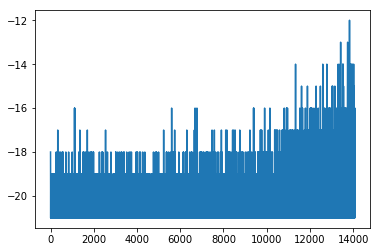

In [8]:
plt.plot(score_avg)

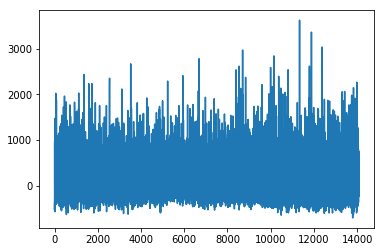

In [9]:
plt.plot(ac_loss_list)

In [10]:
n_iter = 5
for iter in range(n_iter):
    state = get_screen(env.reset())
    log_probs = []
    values = []
    rewards = []
    masks = []
    entropy = 0
    env.reset()
    reward_sum = 0

    for i in count():
        env.render()
        logit, values = actor_critic(state)
        
        probs = F.softmax(logit)
        actions = probs.multinomial(1).data
        
        state, rewards, dones, _ = env.step(actions.cpu().numpy())
        reward_sum += rewards
        masks = (1. - torch.from_numpy(np.array(dones, dtype=np.float32))).unsqueeze(-1)
        #rewards = torch.from_numpy(rewards)
        #rewards = torch.from_numpy(np.array(rewards, dtype=np.float32)).unsqueeze(-1)
        #rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
        #masks.append(torch.tensor([1-done], dtype=torch.float, device=device))
        
        
        state = get_screen(state)
        #state = Variable(state)
        
        #reward_sum += rewards
        
        steps.append((rewards, masks, actions, logit, values))
        if done:
            break
env.close()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


NameError: name 'done' is not defined

In [ ]:
torch.save(actor, 'results/actor.pkl')
torch.save(critic, 'results/critic.pkl')
env.close()